<a href="https://colab.research.google.com/github/shockless/microcirculation-solution/blob/main/Pipeline%20Notebooks/Train_LoD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подготовка сессии

## Импорты

In [1]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!gdown 16OObQ8_WdEWM97BlMOVnlVSorOp1gU3N -O /content/train/
!gdown 12hNXcrHr0v48m9VRr-GLj5eq3pnYU7Im
!N | unzip -q /content/train/train_dataset_mc.zip -d /content/train
!gdown 1dTi50FWqeYUDY27V2ufVe6wB5SEyBgdG

Downloading...
From: https://drive.google.com/uc?id=16OObQ8_WdEWM97BlMOVnlVSorOp1gU3N
To: /content/train/train_dataset_mc.zip
100% 1.99G/1.99G [00:59<00:00, 33.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=12hNXcrHr0v48m9VRr-GLj5eq3pnYU7Im
To: /content/requirements.txt
100% 225/225 [00:00<00:00, 409kB/s]
replace /content/train/1.geojson? [y]es, [n]o, [A]ll, [N]one, [r]ename: /bin/bash: N: command not found
 NULL
(EOF or read error, treating as "[N]one" ...)
Downloading...
From: https://drive.google.com/uc?id=1dTi50FWqeYUDY27V2ufVe6wB5SEyBgdG
To: /content/dataset.txt
100% 13.6k/13.6k [00:00<00:00, 21.3MB/s]


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
drive_location = '/content/drive/MyDrive'

In [5]:
!pip install -r /content/requirements.txt -q

In [6]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

import pandas as pd 
import numpy as np
import glob
import multiprocessing
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18
from torchvision.utils import draw_segmentation_masks

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore")
import json
from GPUtil import showUtilization as gpu_usage
import GPUtil

# Датасет

Прежде чем разбираться с моделями, нам надо в первую очередь разобраться с тем, как грузить датасет. Давайте напишем класс в торче для этого.

## Класс датасета

In [7]:
class EyeDataset(Dataset):
    """
    Класс датасета, организующий загрузку и получение изображений и соответствующих разметок
    """

    def __init__(self, data_folder: str, mode: str = "train", transform=None):
        self.class_ids = {"vessel": 1}

        self.mode = mode.lower()

        self.data_folder = data_folder
        self.transform = transform
        self._image_files = glob.glob(f"{data_folder}/*.png")
        if self.mode == "train":
            self._mask_files = glob.glob(f"{data_folder}/*.geojson")

        image_file_ids = set([el.split(".")[0] for el in self._image_files])
        if self.mode == "train":
            mask_file_ids = set([el.split(".")[0] for el in self._mask_files])

        if self.mode == "train":
            intersecting_ids = list(image_file_ids.intersection(mask_file_ids))
            self._image_files = [el + ".png" for el in intersecting_ids]
            self._mask_files = [el + ".geojson" for el in intersecting_ids]

    @staticmethod
    def read_image(path: str) -> np.ndarray:
        image = cv2.imread(str(path), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.array(image / 255, dtype=np.float32)
        return image

    @staticmethod 
    def parse_polygon(coordinates, image_size): 
        mask = np.zeros(image_size, dtype=np.float32) 
    
        if len(coordinates) == 1: 
            points = [np.int32(coordinates)] 
            cv2.fillPoly(mask, points, 1) 
        else: 
            points = [np.int32([coordinates[0]])] 
            cv2.fillPoly(mask, points, 1) 
    
            for polygon in coordinates[1:]: 
                points = [np.int32([polygon])] 
                cv2.fillPoly(mask, points, 0) 
    
        return mask

    @staticmethod
    def parse_mask(shape: dict, image_size: tuple) -> np.ndarray:
        """
        Метод для парсинга фигур из geojson файла
        """
        mask = np.zeros(image_size, dtype=np.float32)
        coordinates = shape['coordinates']
        if shape['type'] == 'MultiPolygon':
            for polygon in coordinates:
                mask += EyeDataset.parse_polygon(polygon, image_size)
        else:
            mask += EyeDataset.parse_polygon(coordinates, image_size)
        return mask

    def read_layout(self, path: str, image_size: tuple) -> np.ndarray:
        """
        Метод для чтения geojson разметки и перевода в numpy маску
        """
        with open(path, 'r', encoding='cp1251') as f:  # some files contain cyrillic letters, thus cp1251
            json_contents = json.load(f)

        num_channels = 1 + max(self.class_ids.values())
        mask_channels = [np.zeros(image_size, dtype=np.float32) for _ in range(num_channels)]
        mask = np.zeros(image_size, dtype=np.float32)

        if type(json_contents) == dict and json_contents['type'] == 'FeatureCollection':
            features = json_contents['features']
        elif type(json_contents) == list:
            features = json_contents
        else:
            features = [json_contents]

        for shape in features:
            channel_id = self.class_ids["vessel"]
            mask = self.parse_mask(shape['geometry'], image_size)
            mask_channels[channel_id] = np.maximum(mask_channels[channel_id], mask)

        mask_channels[0] = 1 - np.max(mask_channels[1:], axis=0)

        return np.stack(mask_channels, axis=-1)


    def __getitem__(self, idx: int) -> dict:
        # Достаём имя файла по индексу
        image_path = self._image_files[idx]

        # Получаем соответствующий файл разметки
        if self.mode == "train":
            json_path = image_path.replace("png", "geojson")

        image = self.read_image(image_path)

        if self.mode == "train":
            mask = self.read_layout(json_path, image.shape[:2])

        if self.mode == "train":
            sample = {'image': image,
                      'mask': mask}
        else:
            sample = {"image": image}

        if self.transform is not None:
            sample = self.transform(**sample)

        return sample

    def __len__(self):
        return len(self._image_files)

    # Метод для проверки состояния датасета
    def make_report(self):
      reports = []
      if (not self.data_folder):
        reports.append("Путь к датасету не указан")
      if (len(self._image_files) == 0):
        reports.append("Изображения для распознавания не найдены")
      else:
        reports.append(f"Найдено {len(self._image_files)} изображений")
      cnt_images_without_masks = sum([1 - len(glob.glob(filepath.replace("png", "geojson"))) for filepath in self._image_files])
      if cnt_images_without_masks > 0:
        reports.append(f"Найдено {cnt_images_without_masks} изображений без разметки")
      else:
        reports.append(f"Для всех изображений есть файл разметки")
      return reports


class DatasetPart(Dataset):
    """
    Обертка над классом датасета для его разбиения на части
    """
    def __init__(self, dataset: Dataset,
                 indices: np.ndarray,
                 transform: A.Compose = None):
        self.dataset = dataset
        self.indices = indices

        self.transform = transform

    def __getitem__(self, idx: int) -> dict:
        sample = self.dataset[self.indices[idx]]

        if self.transform is not None:
            sample = self.transform(**sample)

        return sample

    def __len__(self) -> int:
        return len(self.indices)


## Преобразование

In [8]:
# Задаем преобразование изображений
size = 1024
train_list = [A.LongestMaxSize(size, interpolation=cv2.INTER_CUBIC),
              A.PadIfNeeded(size, size),
              ToTensorV2(transpose_mask=True),
              ]
eval_list = [A.LongestMaxSize(size, interpolation=cv2.INTER_CUBIC),
              A.PadIfNeeded(size, size),
              ToTensorV2(transpose_mask=True)]

transforms = {'train': A.Compose(train_list), 'test': A.Compose(eval_list)}


In [9]:
# Инициализируем датасет
dataset = EyeDataset("/content/train")

In [10]:
for j in range(2):
    try:
        for i in range(len(dataset)):
            if glob.glob(dataset._image_files[i].replace("png", "geojson"))==[]:
                dataset._image_files.pop(i)
    except:
        j-=1

In [11]:
with open('dataset.txt') as f:
    dat_str = f.readlines()
for i in range(len(dat_str)):
  dat_str[i] = dat_str[i].replace('\n','')
dataset._image_files = list(dat_str)

In [12]:
for msg in dataset.make_report():
  print(msg)

Найдено 596 изображений
Для всех изображений есть файл разметки


## Визуализация

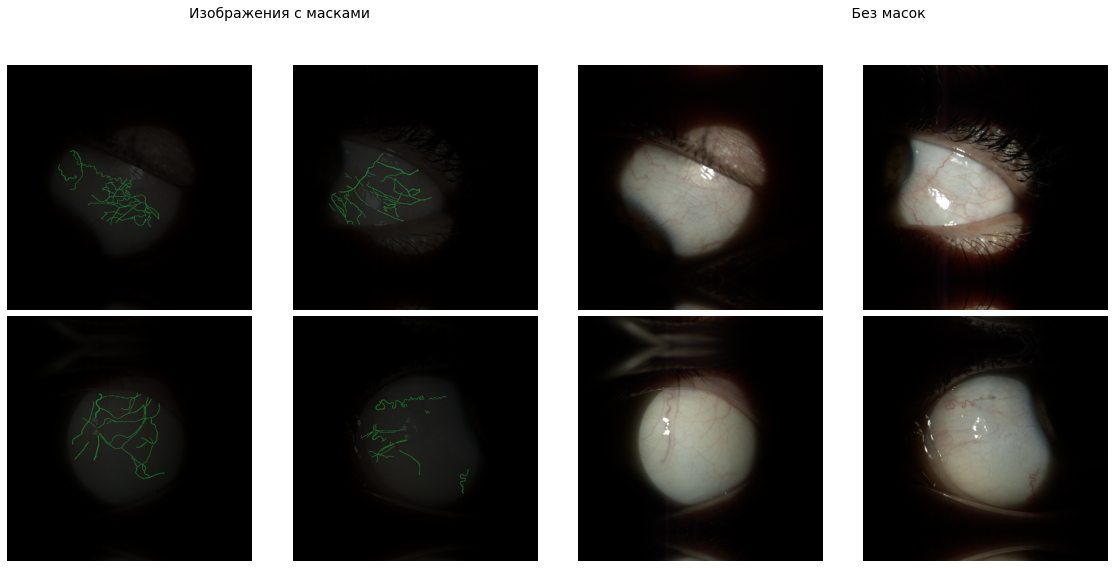

In [13]:
# Посмотрим на картинки из датасета

fig, axs = plt.subplots(2, 4, figsize=(16,8))
fig.suptitle(f'Изображения с масками {" "*105} Без масок', fontsize=14)

for i, sample in zip(range(4), dataset):
    transformed = transforms['test'](**sample)
    image, mask = transformed["image"], transformed["mask"]

    image_with_mask = draw_segmentation_masks((image.cpu() * 255).type(torch.uint8), mask.type(torch.bool))
    image_with_mask = np.moveaxis(image_with_mask.cpu().numpy(), 0, -1)

    axs[i // 2, (i % 2)].imshow(image_with_mask)
    axs[i // 2, (i % 2)].axis('off')

    image = np.moveaxis(image.cpu().numpy(), 0, -1)    
    axs[i // 2, (i % 2)+2].imshow(image)
    axs[i // 2, (i % 2)+2].axis('off')

fig.tight_layout()
fig.subplots_adjust(top=0.88)

## Вспомогательные функции

In [14]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

# Класс тренировщика модели

In [15]:
from typing import Tuple, List, Callable, Iterator, Optional, Dict, Any
from collections import defaultdict

class UnetTrainer:
    """
    Класс, реализующий обучение модели
    """

    def __init__(self, model: nn.Module, optimizer: torch.optim.Optimizer,
                 criterion: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
                 device: str, metric_functions: List[Tuple[str, Callable]] = [],
                 epoch_number: int = 0,
                 lr_scheduler: Optional[Any] = None):
        self.model = model
        self.optimizer = optimizer  
        self.criterion = criterion
        self.lr_scheduler = lr_scheduler

        self.device = device

        self.metric_functions = metric_functions

        self.epoch_number = epoch_number

    @torch.no_grad()
    def evaluate_batch(self, val_iterator: Iterator, eval_on_n_batches: int) -> Optional[Dict[str, float]]:     
        predictions = []
        targets = []

        losses = []

        for real_batch_number in range(eval_on_n_batches):
            try:
                batch = next(val_iterator)

                xs = batch['image'].to(self.device)
                ys_true = batch['mask'].to(self.device)
            except StopIteration:
                if real_batch_number == 0:
                    return None
                else:
                    break
            ys_pred = self.model.eval()(xs)
            loss = self.criterion(ys_pred, ys_true)

            losses.append(loss.item())

            predictions.append(ys_pred.cpu())
            targets.append(ys_true.cpu())

        predictions = torch.cat(predictions, dim=0)
        targets = torch.cat(targets, dim=0)

        metrics = {'loss': np.mean(losses)}

        for metric_name, metric_fn in self.metric_functions:
            metrics[metric_name] = metric_fn(predictions, targets).item()

        return metrics

    @torch.no_grad()
    def evaluate(self, val_loader, eval_on_n_batches: int = 1) -> Dict[str, float]:
        """
        Вычисление метрик для эпохи
        """
        metrics_sum = defaultdict(float)
        num_batches = 0

        val_iterator = iter(val_loader)

        while True:
            batch_metrics = self.evaluate_batch(val_iterator, eval_on_n_batches)

            if batch_metrics is None:
                break

            for metric_name in batch_metrics:
                metrics_sum[metric_name] += batch_metrics[metric_name]

            num_batches += 1

        metrics = {}

        for metric_name in metrics_sum:
            metrics[metric_name] = metrics_sum[metric_name] / num_batches

        return metrics

    def fit_batch(self, train_iterator: Iterator, update_every_n_batches: int) -> Optional[Dict[str, float]]:
        """
        Тренировка модели на одном батче
        """
        self.model.train()
    
        predictions = []
        targets = []

        losses = []

        for real_batch_number in range(update_every_n_batches):
            self.optimizer.zero_grad()
            try:
                batch = next(train_iterator)

                xs = batch['image'].to(self.device)
                ys_true = batch['mask'].to(self.device)
            except StopIteration:
                if real_batch_number == 0:
                    return None
                else:
                    break

            ys_pred = self.model.train()(xs)
            loss = self.criterion(ys_pred, ys_true)

            (loss / update_every_n_batches).backward()

            losses.append(loss.item())

            predictions.append(ys_pred.cpu())
            targets.append(ys_true.cpu())

        self.optimizer.step()
        predictions = torch.cat(predictions, dim=0)
        targets = torch.cat(targets, dim=0)

        metrics = {'loss': np.mean(losses)}

        for metric_name, metric_fn in self.metric_functions:
            metrics[metric_name] = metric_fn(predictions, targets).item()
        print(metrics)
        return metrics

    def fit_epoch(self, train_loader, update_every_n_batches: int = 1) -> Dict[str, float]:
        """
        Одна эпоха тренировки модели
        """

        metrics_sum = defaultdict(float)
        num_batches = 0

        train_iterator = iter(train_loader)
        n_batches = len(train_loader)
        with tqdm(total=n_batches) as pbar:
            while True:
                batch_metrics = self.fit_batch(train_iterator, update_every_n_batches)

                if batch_metrics is None:
                    break

                for metric_name in batch_metrics:
                    metrics_sum[metric_name] += batch_metrics[metric_name]

                pbar.update(1)
                num_batches += 1

        metrics = {}

        for metric_name in metrics_sum:
            metrics[metric_name] = metrics_sum[metric_name] / num_batches

        return metrics

    def fit(self, train_loader, num_epochs: int,
            val_loader = None, update_every_n_batches: int = 1,
            ) -> Dict[str, np.ndarray]:
        """
        Метод, тренирующий модель и вычисляющий метрики для каждой эпохи
        """

        summary = defaultdict(list)

        def save_metrics(metrics: Dict[str, float], postfix: str = '') -> None:
          # Сохранение метрик в summary
            nonlocal summary, self

            for metric in metrics:
                metric_name, metric_value = f'{metric}{postfix}', metrics[metric]

                summary[metric_name].append(metric_value)

        for _ in tqdm(range(num_epochs - self.epoch_number), initial=self.epoch_number, total=num_epochs):
            self.epoch_number += 1

            train_metrics = self.fit_epoch(train_loader, update_every_n_batches)

            with torch.no_grad():
                save_metrics(train_metrics, postfix='_train')

                if val_loader is not None:
                    test_metrics = self.evaluate(val_loader)
                    print('epoch metrics:')
                    print(f"train: {train_metrics} \n test: {test_metrics}")
                    save_metrics(test_metrics, postfix='_test')

            if self.lr_scheduler is not None:
                self.lr_scheduler.step()

        summary = {metric: np.array(summary[metric]) for metric in summary}

        return summary


# Метрики

In [16]:
# F1-мера
class SoftDice:
    def __init__(self, epsilon=1e-8):
        self.epsilon = epsilon

    def __call__(self, predictions: List[Dict[str, torch.Tensor]],
                 targets: List[Dict[str, torch.Tensor]]) -> torch.Tensor:
        numerator = torch.sum(2 * predictions * targets)
        denominator = torch.sum(predictions + targets)
        return numerator / (denominator + self.epsilon)

# Метрика полноты
class Recall:
    def __init__(self, epsilon=1e-70):
        self.epsilon = epsilon

    def __call__(self, predictions: List[Dict[str, torch.Tensor]],
                 targets: List[Dict[str, torch.Tensor]]) -> torch.Tensor:
        numerator = torch.sum(predictions * targets)
        denominator = torch.sum(targets)

        return numerator / (denominator + self.epsilon)

# Метрика точности
class Accuracy:
    def __init__(self, epsilon=1e-8):
        self.epsilon = epsilon

    def __call__(self, predictions: list, targets: list) -> torch.Tensor:
        numerator = torch.sum(predictions * targets)
        denominator = torch.sum(predictions)

        return numerator / (denominator + self.epsilon)

def make_metrics():
    soft_dice = SoftDice()
    recall = Recall()
    accuracy = Accuracy()

    def exp_dice(pred, target):
        return soft_dice(torch.exp(pred[:, 1:]), target[:, 1:])

    def exp_accuracy(pred, target):
        return accuracy(torch.exp(pred[:, 1:]), target[:, 1:])

    def exp_recall(pred, target):
        return recall(torch.exp(pred[:, 1:]), target[:, 1:])

    return [('dice', exp_dice),
            ('accuracy', exp_accuracy),
            ('recall', exp_recall),
            ]

# Cross-Validation

In [17]:
from sklearn.model_selection import StratifiedKFold
from copy import deepcopy
import random

In [18]:
def density(dataset: list=Any):
    densities=[]
    for i in tqdm(range(len(dataset))):
        mask = dataset[i]['mask'][:,:,1]
        densities.append(mask.sum()/(mask.shape[0] * mask.shape[1]))
    return densities

In [19]:
!mkdir {drive_location}/Competitions/LeadersOfDigital/models/cv

mkdir: cannot create directory ‘/content/drive/MyDrive/Competitions/LeadersOfDigital/models/cv’: File exists


In [20]:
def cv(base_model,
       dataset,
       device: str,
       loss_function: Any,
       lr: float = 1e-6,
       eps: float = 1e-8,
       random_state: int = 69,
       shuffle: bool = True,
       n_folds: int = 4,
       epochs: int = 10,
       batch_size: int = 1,
       metric_functions: list = [],
       transform: Dict = None,
       lr_scheduler: Any = None, 
       importances: list = [],
       optimizer: Any = None,
       start_fold: int = 0) -> List[Dict]:
    random.seed(random_state),
    np.random.seed(random_state)
    torch.manual_seed(random_state)
    torch.cuda.manual_seed_all(random_state)

    #loss_function.to(device)

    kfold = StratifiedKFold(n_folds, shuffle=shuffle)
    summaries = []

    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset, importances)):
        if(fold>=start_fold):
            print(f'FOLD {fold}')
            print('--------------------------------')

            model = deepcopy(base_model)


            trainer = UnetTrainer(
                model=model,
                optimizer=optimizer,
                criterion=loss_function,
                device=device,
                metric_functions=metric_functions,
                lr_scheduler=lr_scheduler
            )

            train_subset = DatasetPart(dataset, indices=train_ids, transform=transform["train"] if transform else None)
            train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size,shuffle=True)
            
            test_subset = DatasetPart(dataset, indices=test_ids, transform=transform["test"] if transform else None)
            val_loader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size,shuffle=True)
            
            summary = trainer.fit(train_loader, epochs, val_loader=val_loader)

            summaries.append(summary)
        

    return summaries

# Модель

In [21]:
def make_criterion():
    soft_dice = SoftDice()
    def exp_dice(pred, target):
        return 1 - soft_dice(torch.exp(pred[:, 1:]), target[:, 1:])

    return exp_dice

In [22]:
torch.cuda.empty_cache()

In [23]:
#denses=density(dataset)

  4%|▍         | 24/596 [00:12<04:53,  1.95it/s]


KeyboardInterrupt: ignored

In [ ]:
values, threshes = np.histogram(denses, bins=15)

In [ ]:
def bining(value):
    for bin, thresh in enumerate(threshes[1:]):
        if value < thresh:
            return bin
    return bin + 1

In [ ]:
binary_denses = list(map(bining, denses))

In [24]:
!pip install madgrad

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
import madgrad

In [26]:
!pip install inplace_abn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
from inplace_abn import InPlaceABN

In [28]:
cores = multiprocessing.cpu_count()
batch_size=2
lr_e =  1e-5
lr_d = 1e-3
encoder_pretrain='timm-regnety_064'

#model = torch.load(f"{drive_location}/Competitions/LeadersOfDigital/models/model_pretrain.pt")

model_pretrain = smp.UnetPlusPlus(encoder_pretrain, activation='logsoftmax', classes=2, decoder_use_batchnorm=InPlaceABN).cuda()

def make_criterion():
    soft_dice = SoftDice()
    def exp_dice(pred, target):
        return 1 - soft_dice(torch.exp(pred[:, 1:]), target[:, 1:])

    return exp_dice

criterion = make_criterion()
optimizer = madgrad.MADGRAD(model_pretrain.parameters(), 1e-4)
trainer_pretrain = UnetTrainer(model_pretrain, optimizer, criterion, 'cuda', metric_functions=make_metrics())

#cv(model, dataset, 'cuda',loss_function=criterion, batch_size=1, metric_functions=make_metrics(), transform=transforms, importances=binary_denses, optimizer=optimizer, start_fold=0)

# Процесс обучения

In [29]:
# разделим датасет на тренировочный и валидационный, чтобы смотреть на качество
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.25)

In [30]:
# Разбиваем объект датасета на тренировачный и валидационный
train_dataset = DatasetPart(dataset, train_indices, transform=transforms['train'])
valid_dataset = DatasetPart(dataset, test_indices, transform=transforms['test'])


In [31]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size,
                                           num_workers=cores,
                                   shuffle=True, drop_last=True)

valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size,
                                           num_workers=cores,
                                   shuffle=True, drop_last=True)

In [32]:
trainer = UnetTrainer(model_pretrain, optimizer, criterion, 'cuda', metric_functions=make_metrics())
summary = trainer.fit(train_loader, 6, val_loader=valid_loader)

  0%|          | 1/223 [00:07<29:31,  7.98s/it]

{'loss': 0.9803597331047058, 'dice': 0.01964028924703598, 'accuracy': 0.009976018220186234, 'recall': 0.628495454788208}



  1%|          | 2/223 [00:10<18:00,  4.89s/it]

{'loss': 0.97662353515625, 'dice': 0.02337649092078209, 'accuracy': 0.011906200088560581, 'recall': 0.638488233089447}



  1%|▏         | 3/223 [00:13<14:34,  3.97s/it]

{'loss': 0.9740362167358398, 'dice': 0.025963809341192245, 'accuracy': 0.013232524506747723, 'recall': 0.6854344010353088}



  2%|▏         | 4/223 [00:16<13:17,  3.64s/it]

{'loss': 0.9554287195205688, 'dice': 0.044571273028850555, 'accuracy': 0.022990288212895393, 'recall': 0.7271009683609009}



  2%|▏         | 5/223 [00:19<12:02,  3.31s/it]

{'loss': 0.9850277900695801, 'dice': 0.014972195960581303, 'accuracy': 0.007554177660495043, 'recall': 0.8306668400764465}



  3%|▎         | 6/223 [00:22<11:11,  3.09s/it]

{'loss': 0.9588574171066284, 'dice': 0.04114256426692009, 'accuracy': 0.02110401913523674, 'recall': 0.8149157762527466}



  3%|▎         | 7/223 [00:24<10:48,  3.00s/it]

{'loss': 0.928400993347168, 'dice': 0.07159903645515442, 'accuracy': 0.03735272213816643, 'recall': 0.8609374165534973}



  4%|▎         | 8/223 [00:27<10:35,  2.95s/it]

{'loss': 0.9564899802207947, 'dice': 0.04351000487804413, 'accuracy': 0.022305922582745552, 'recall': 0.8808279037475586}



  4%|▍         | 9/223 [00:30<10:26,  2.93s/it]

{'loss': 0.9613103270530701, 'dice': 0.03868970274925232, 'accuracy': 0.01975136622786522, 'recall': 0.939906120300293}



  4%|▍         | 10/223 [00:33<10:09,  2.86s/it]

{'loss': 0.9653252363204956, 'dice': 0.03467478230595589, 'accuracy': 0.0176603551954031, 'recall': 0.9480432271957397}



  5%|▍         | 11/223 [00:35<09:51,  2.79s/it]

{'loss': 0.9565761685371399, 'dice': 0.0434238500893116, 'accuracy': 0.022237051278352737, 'recall': 0.9194149374961853}



  5%|▌         | 12/223 [00:38<09:37,  2.74s/it]

{'loss': 0.960578441619873, 'dice': 0.03942155838012695, 'accuracy': 0.02012106217443943, 'recall': 0.966654360294342}



  6%|▌         | 13/223 [00:41<09:27,  2.70s/it]

{'loss': 0.9545627236366272, 'dice': 0.045437250286340714, 'accuracy': 0.02326723001897335, 'recall': 0.963533878326416}



  6%|▋         | 14/223 [00:43<09:19,  2.68s/it]

{'loss': 0.9551935195922852, 'dice': 0.04480651021003723, 'accuracy': 0.022938523441553116, 'recall': 0.9600754976272583}



  7%|▋         | 15/223 [00:46<09:13,  2.66s/it]

{'loss': 0.9767219424247742, 'dice': 0.023278068751096725, 'accuracy': 0.011777197942137718, 'recall': 0.9921321272850037}



  7%|▋         | 16/223 [00:49<09:08,  2.65s/it]

{'loss': 0.9837062358856201, 'dice': 0.016293764114379883, 'accuracy': 0.008216063492000103, 'recall': 0.9675299525260925}



  8%|▊         | 17/223 [00:51<09:06,  2.65s/it]

{'loss': 0.9579808712005615, 'dice': 0.042019158601760864, 'accuracy': 0.02146918512880802, 'recall': 0.9814048409461975}



  8%|▊         | 18/223 [00:54<09:02,  2.65s/it]

{'loss': 0.9761386513710022, 'dice': 0.023861320689320564, 'accuracy': 0.012079128995537758, 'recall': 0.9706644415855408}



  9%|▊         | 19/223 [00:57<08:59,  2.64s/it]

{'loss': 0.9536482095718384, 'dice': 0.04635179042816162, 'accuracy': 0.023737778887152672, 'recall': 0.9791074395179749}



  9%|▉         | 20/223 [00:59<08:56,  2.64s/it]

{'loss': 0.9607458114624023, 'dice': 0.039254192262887955, 'accuracy': 0.020043862983584404, 'recall': 0.9439411759376526}



  9%|▉         | 21/223 [01:02<08:53,  2.64s/it]

{'loss': 0.9330704212188721, 'dice': 0.06692960113286972, 'accuracy': 0.034640781581401825, 'recall': 0.9857702255249023}



 10%|▉         | 22/223 [01:04<08:51,  2.64s/it]

{'loss': 0.9625147581100464, 'dice': 0.037485260516405106, 'accuracy': 0.01910308003425598, 'recall': 0.9933180212974548}



 10%|█         | 23/223 [01:07<08:48,  2.64s/it]

{'loss': 0.972602128982544, 'dice': 0.027397843077778816, 'accuracy': 0.013891570270061493, 'recall': 0.9878033995628357}



 11%|█         | 24/223 [01:10<08:46,  2.64s/it]

{'loss': 0.9692513346672058, 'dice': 0.030748633667826653, 'accuracy': 0.015616091899573803, 'recall': 0.9930153489112854}



 11%|█         | 25/223 [01:12<08:42,  2.64s/it]

{'loss': 0.945560872554779, 'dice': 0.054439134895801544, 'accuracy': 0.027995474636554718, 'recall': 0.9821082353591919}



 12%|█▏        | 26/223 [01:15<08:40,  2.64s/it]

{'loss': 0.9714285731315613, 'dice': 0.02857143245637417, 'accuracy': 0.014494522474706173, 'recall': 0.9916544556617737}



 12%|█▏        | 27/223 [01:18<08:38,  2.65s/it]

{'loss': 0.9514379501342773, 'dice': 0.04856207221746445, 'accuracy': 0.024903355166316032, 'recall': 0.9716548919677734}



 13%|█▎        | 28/223 [01:20<08:37,  2.65s/it]

{'loss': 0.9485003352165222, 'dice': 0.051499657332897186, 'accuracy': 0.02646380290389061, 'recall': 0.9544302821159363}



 13%|█▎        | 29/223 [01:23<08:35,  2.65s/it]

{'loss': 0.9404103755950928, 'dice': 0.05958959460258484, 'accuracy': 0.0307572353631258, 'recall': 0.952171266078949}



 13%|█▎        | 30/223 [01:26<08:32,  2.66s/it]

{'loss': 0.9421378374099731, 'dice': 0.057862136512994766, 'accuracy': 0.029829606413841248, 'recall': 0.9604523777961731}



 14%|█▍        | 31/223 [01:28<08:30,  2.66s/it]

{'loss': 0.9700170755386353, 'dice': 0.0299829188734293, 'accuracy': 0.015227992087602615, 'recall': 0.9651527404785156}



 14%|█▍        | 32/223 [01:31<08:27,  2.66s/it]

{'loss': 0.9530155062675476, 'dice': 0.0469844825565815, 'accuracy': 0.024186141788959503, 'recall': 0.818829357624054}



 15%|█▍        | 33/223 [01:34<08:25,  2.66s/it]

{'loss': 0.9298315048217773, 'dice': 0.07016851007938385, 'accuracy': 0.03646843135356903, 'recall': 0.9243528246879578}



 15%|█▌        | 34/223 [01:36<08:23,  2.66s/it]

{'loss': 0.9566362500190735, 'dice': 0.04336373135447502, 'accuracy': 0.022167980670928955, 'recall': 0.9887458086013794}



 16%|█▌        | 35/223 [01:39<08:21,  2.67s/it]

{'loss': 0.930896520614624, 'dice': 0.06910347938537598, 'accuracy': 0.035791948437690735, 'recall': 0.9971500039100647}



 16%|█▌        | 36/223 [01:42<08:19,  2.67s/it]

{'loss': 0.9612760543823242, 'dice': 0.03872396796941757, 'accuracy': 0.019751887768507004, 'recall': 0.9808440208435059}



 17%|█▋        | 37/223 [01:44<08:16,  2.67s/it]

{'loss': 0.9508850574493408, 'dice': 0.04911491647362709, 'accuracy': 0.025188440456986427, 'recall': 0.9803184270858765}



 17%|█▋        | 38/223 [01:47<08:14,  2.67s/it]

{'loss': 0.9173575043678284, 'dice': 0.08264248818159103, 'accuracy': 0.043236810714006424, 'recall': 0.9326733946800232}



 17%|█▋        | 39/223 [01:50<08:12,  2.67s/it]

{'loss': 0.9102405905723572, 'dice': 0.08975938707590103, 'accuracy': 0.047089964151382446, 'recall': 0.9561654329299927}



 18%|█▊        | 40/223 [01:52<08:09,  2.67s/it]

{'loss': 0.9329632520675659, 'dice': 0.0670367181301117, 'accuracy': 0.03498600795865059, 'recall': 0.7990150451660156}



 18%|█▊        | 41/223 [01:55<08:12,  2.71s/it]

{'loss': 0.9219134449958801, 'dice': 0.07808658480644226, 'accuracy': 0.040698908269405365, 'recall': 0.9597725868225098}



 19%|█▉        | 42/223 [01:58<08:12,  2.72s/it]

{'loss': 0.8830280303955078, 'dice': 0.1169719472527504, 'accuracy': 0.06223446875810623, 'recall': 0.9710157513618469}



 19%|█▉        | 43/223 [02:01<08:07,  2.71s/it]

{'loss': 0.9096885919570923, 'dice': 0.09031139314174652, 'accuracy': 0.04749395325779915, 'recall': 0.9171877503395081}



 20%|█▉        | 44/223 [02:03<08:03,  2.70s/it]

{'loss': 0.9105607271194458, 'dice': 0.08943929523229599, 'accuracy': 0.04688360542058945, 'recall': 0.9688812494277954}



 20%|██        | 45/223 [02:06<08:01,  2.71s/it]

{'loss': 0.929713249206543, 'dice': 0.07028678059577942, 'accuracy': 0.03642955794930458, 'recall': 0.9954069256782532}



 21%|██        | 46/223 [02:09<07:59,  2.71s/it]

{'loss': 0.9435694217681885, 'dice': 0.056430596858263016, 'accuracy': 0.029050597921013832, 'recall': 0.9812918901443481}



 21%|██        | 47/223 [02:11<07:55,  2.70s/it]

{'loss': 0.9339495897293091, 'dice': 0.06605041027069092, 'accuracy': 0.03415714576840401, 'recall': 0.9965593814849854}



 22%|██▏       | 48/223 [02:14<07:54,  2.71s/it]

{'loss': 0.8940759897232056, 'dice': 0.10592404752969742, 'accuracy': 0.05606222152709961, 'recall': 0.9577363729476929}



 22%|██▏       | 49/223 [02:17<07:51,  2.71s/it]

{'loss': 0.9127870202064514, 'dice': 0.08721299469470978, 'accuracy': 0.04571446031332016, 'recall': 0.9456750750541687}



 22%|██▏       | 50/223 [02:20<07:49,  2.71s/it]

{'loss': 0.911939263343811, 'dice': 0.08806074410676956, 'accuracy': 0.04613228514790535, 'recall': 0.9663673043251038}



 23%|██▎       | 51/223 [02:22<07:46,  2.71s/it]

{'loss': 0.9375841617584229, 'dice': 0.062415849417448044, 'accuracy': 0.03222712501883507, 'recall': 0.9867950677871704}



 23%|██▎       | 52/223 [02:25<07:43,  2.71s/it]

{'loss': 0.8134145736694336, 'dice': 0.1865854114294052, 'accuracy': 0.10447850078344345, 'recall': 0.8713794946670532}



 24%|██▍       | 53/223 [02:28<07:41,  2.71s/it]

{'loss': 0.930383026599884, 'dice': 0.06961696594953537, 'accuracy': 0.036089539527893066, 'recall': 0.9806146025657654}



 24%|██▍       | 54/223 [02:30<07:37,  2.71s/it]

{'loss': 0.867003858089447, 'dice': 0.13299615681171417, 'accuracy': 0.07158213108778, 'recall': 0.9362753629684448}



 25%|██▍       | 55/223 [02:33<07:35,  2.71s/it]

{'loss': 0.8777583837509155, 'dice': 0.12224158644676208, 'accuracy': 0.06517545133829117, 'recall': 0.9824681282043457}



 25%|██▌       | 56/223 [02:36<07:33,  2.71s/it]

{'loss': 0.9242945909500122, 'dice': 0.0757053941488266, 'accuracy': 0.03941580280661583, 'recall': 0.9545049071311951}



 26%|██▌       | 57/223 [02:39<07:30,  2.71s/it]

{'loss': 0.86797034740448, 'dice': 0.13202962279319763, 'accuracy': 0.07106981426477432, 'recall': 0.9281222820281982}



 26%|██▌       | 58/223 [02:41<07:28,  2.72s/it]

{'loss': 0.9015260338783264, 'dice': 0.09847397357225418, 'accuracy': 0.05217945948243141, 'recall': 0.8731294870376587}



 26%|██▋       | 59/223 [02:44<07:25,  2.72s/it]

{'loss': 0.9116945862770081, 'dice': 0.08830543607473373, 'accuracy': 0.046287473291158676, 'recall': 0.9573549628257751}



 27%|██▋       | 60/223 [02:47<07:22,  2.72s/it]

{'loss': 0.8649818897247314, 'dice': 0.13501814007759094, 'accuracy': 0.07296714186668396, 'recall': 0.9025072455406189}



 27%|██▋       | 61/223 [02:49<07:21,  2.72s/it]

{'loss': 0.8480203151702881, 'dice': 0.15197964012622833, 'accuracy': 0.08299566805362701, 'recall': 0.9002228379249573}



 28%|██▊       | 62/223 [02:52<07:18,  2.72s/it]

{'loss': 0.8621348142623901, 'dice': 0.13786518573760986, 'accuracy': 0.07573629915714264, 'recall': 0.7673321962356567}



 28%|██▊       | 63/223 [02:55<07:16,  2.73s/it]

{'loss': 0.9209678769111633, 'dice': 0.07903210073709488, 'accuracy': 0.04132219776511192, 'recall': 0.90407395362854}



 29%|██▊       | 64/223 [02:58<07:14,  2.73s/it]

{'loss': 0.7967782020568848, 'dice': 0.20322173833847046, 'accuracy': 0.11570489406585693, 'recall': 0.8341745138168335}



 29%|██▉       | 65/223 [03:00<07:11,  2.73s/it]

{'loss': 0.761309802532196, 'dice': 0.23869019746780396, 'accuracy': 0.13734637200832367, 'recall': 0.9105806946754456}



 30%|██▉       | 66/223 [03:03<07:08,  2.73s/it]

{'loss': 0.7872533798217773, 'dice': 0.21274663507938385, 'accuracy': 0.12017858773469925, 'recall': 0.926008403301239}



 30%|███       | 67/223 [03:06<07:06,  2.73s/it]

{'loss': 0.8023570775985718, 'dice': 0.19764292240142822, 'accuracy': 0.11084587126970291, 'recall': 0.9109769463539124}



 30%|███       | 68/223 [03:09<07:04,  2.74s/it]

{'loss': 0.8264956474304199, 'dice': 0.17350433766841888, 'accuracy': 0.09538422524929047, 'recall': 0.9586114287376404}



 31%|███       | 69/223 [03:11<07:01,  2.74s/it]

{'loss': 0.7814179062843323, 'dice': 0.2185821235179901, 'accuracy': 0.126244455575943, 'recall': 0.8138423562049866}



 31%|███▏      | 70/223 [03:14<06:58,  2.74s/it]

{'loss': 0.7964600324630737, 'dice': 0.20353993773460388, 'accuracy': 0.11567611247301102, 'recall': 0.8465580940246582}



 32%|███▏      | 71/223 [03:17<06:56,  2.74s/it]

{'loss': 0.7996130585670471, 'dice': 0.20038695633411407, 'accuracy': 0.11334635317325592, 'recall': 0.8634294271469116}



 32%|███▏      | 72/223 [03:20<06:53,  2.74s/it]

{'loss': 0.758031964302063, 'dice': 0.2419680655002594, 'accuracy': 0.13965779542922974, 'recall': 0.9048181772232056}



 33%|███▎      | 73/223 [03:22<06:51,  2.74s/it]

{'loss': 0.738684356212616, 'dice': 0.26131564378738403, 'accuracy': 0.1557687371969223, 'recall': 0.8105003833770752}



 33%|███▎      | 74/223 [03:25<06:48,  2.74s/it]

{'loss': 0.7441486120223999, 'dice': 0.2558514177799225, 'accuracy': 0.15102940797805786, 'recall': 0.8362526893615723}



 34%|███▎      | 75/223 [03:28<06:46,  2.75s/it]

{'loss': 0.7065654993057251, 'dice': 0.2934345006942749, 'accuracy': 0.182193785905838, 'recall': 0.7534829378128052}



 34%|███▍      | 76/223 [03:31<06:43,  2.75s/it]

{'loss': 0.8605105876922607, 'dice': 0.13948944211006165, 'accuracy': 0.0777551680803299, 'recall': 0.6769921183586121}



 35%|███▍      | 77/223 [03:33<06:41,  2.75s/it]

{'loss': 0.7394413948059082, 'dice': 0.2605585753917694, 'accuracy': 0.15435808897018433, 'recall': 0.8351603746414185}



 35%|███▍      | 78/223 [03:36<06:38,  2.75s/it]

{'loss': 0.7858625650405884, 'dice': 0.21413742005825043, 'accuracy': 0.12149042636156082, 'recall': 0.9019601941108704}



 35%|███▌      | 79/223 [03:39<06:35,  2.75s/it]

{'loss': 0.8126691579818726, 'dice': 0.18733081221580505, 'accuracy': 0.10590481013059616, 'recall': 0.8104652762413025}



 36%|███▌      | 80/223 [03:42<06:33,  2.75s/it]

{'loss': 0.6965751051902771, 'dice': 0.3034248948097229, 'accuracy': 0.18433918058872223, 'recall': 0.857166051864624}



 36%|███▋      | 81/223 [03:44<06:30,  2.75s/it]

{'loss': 0.8148826360702515, 'dice': 0.18511739373207092, 'accuracy': 0.1030689924955368, 'recall': 0.9076756238937378}



 37%|███▋      | 82/223 [03:47<06:29,  2.77s/it]

{'loss': 0.8365901708602905, 'dice': 0.16340985894203186, 'accuracy': 0.09040714055299759, 'recall': 0.8488317131996155}



 37%|███▋      | 83/223 [03:50<06:28,  2.77s/it]

{'loss': 0.7798173427581787, 'dice': 0.22018268704414368, 'accuracy': 0.12535330653190613, 'recall': 0.9042296409606934}



 38%|███▊      | 84/223 [03:53<06:25,  2.77s/it]

{'loss': 0.7578645944595337, 'dice': 0.24213533103466034, 'accuracy': 0.14415617287158966, 'recall': 0.755902111530304}



 38%|███▊      | 85/223 [03:55<06:22,  2.77s/it]

{'loss': 0.6496870517730713, 'dice': 0.3503129780292511, 'accuracy': 0.22428388893604279, 'recall': 0.799651026725769}



 39%|███▊      | 86/223 [03:58<06:20,  2.77s/it]

{'loss': 0.6792083978652954, 'dice': 0.3207916021347046, 'accuracy': 0.21325330436229706, 'recall': 0.6471160054206848}



 39%|███▉      | 87/223 [04:01<06:17,  2.78s/it]

{'loss': 0.7181923389434814, 'dice': 0.28180769085884094, 'accuracy': 0.1667020469903946, 'recall': 0.9104882478713989}



 39%|███▉      | 88/223 [04:04<06:14,  2.77s/it]

{'loss': 0.6884498000144958, 'dice': 0.31155019998550415, 'accuracy': 0.19366231560707092, 'recall': 0.7962512373924255}



 40%|███▉      | 89/223 [04:07<06:11,  2.77s/it]

{'loss': 0.7062860727310181, 'dice': 0.29371392726898193, 'accuracy': 0.18319308757781982, 'recall': 0.7403974533081055}



 40%|████      | 90/223 [04:09<06:08,  2.77s/it]

{'loss': 0.6813125610351562, 'dice': 0.31868746876716614, 'accuracy': 0.2013549506664276, 'recall': 0.7637160420417786}



 41%|████      | 91/223 [04:12<06:04,  2.76s/it]

{'loss': 0.63871830701828, 'dice': 0.36128172278404236, 'accuracy': 0.23159940540790558, 'recall': 0.820986807346344}



 41%|████▏     | 92/223 [04:15<06:02,  2.76s/it]

{'loss': 0.7216689586639404, 'dice': 0.27833104133605957, 'accuracy': 0.17371782660484314, 'recall': 0.699679434299469}



 42%|████▏     | 93/223 [04:18<05:59,  2.76s/it]

{'loss': 0.6470404863357544, 'dice': 0.35295945405960083, 'accuracy': 0.22428210079669952, 'recall': 0.8280187249183655}



 42%|████▏     | 94/223 [04:20<05:56,  2.76s/it]

{'loss': 0.6008526086807251, 'dice': 0.3991473615169525, 'accuracy': 0.2700815796852112, 'recall': 0.7644699811935425}



 43%|████▎     | 95/223 [04:23<05:54,  2.77s/it]

{'loss': 0.6865609288215637, 'dice': 0.31343910098075867, 'accuracy': 0.1912212371826172, 'recall': 0.8685986995697021}



 43%|████▎     | 96/223 [04:26<05:51,  2.77s/it]

{'loss': 0.5563714504241943, 'dice': 0.4436285197734833, 'accuracy': 0.34246841073036194, 'recall': 0.6296043395996094}



 43%|████▎     | 97/223 [04:29<05:48,  2.77s/it]

{'loss': 0.6080838441848755, 'dice': 0.3919161260128021, 'accuracy': 0.29886382818222046, 'recall': 0.5691106915473938}



 44%|████▍     | 98/223 [04:31<05:46,  2.77s/it]

{'loss': 0.6787073612213135, 'dice': 0.3212926685810089, 'accuracy': 0.20568782091140747, 'recall': 0.7336123585700989}



 44%|████▍     | 99/223 [04:34<05:43,  2.77s/it]

{'loss': 0.6352758407592773, 'dice': 0.36472412943840027, 'accuracy': 0.23737964034080505, 'recall': 0.7868220806121826}



 45%|████▍     | 100/223 [04:37<05:41,  2.77s/it]

{'loss': 0.5534018278121948, 'dice': 0.4465981125831604, 'accuracy': 0.37013593316078186, 'recall': 0.5628763437271118}



 45%|████▌     | 101/223 [04:40<05:38,  2.77s/it]

{'loss': 0.7282449007034302, 'dice': 0.2717550992965698, 'accuracy': 0.16172869503498077, 'recall': 0.8500709533691406}



 46%|████▌     | 102/223 [04:43<05:35,  2.77s/it]

{'loss': 0.570279598236084, 'dice': 0.429720401763916, 'accuracy': 0.30633801221847534, 'recall': 0.7195170521736145}



 46%|████▌     | 103/223 [04:45<05:32,  2.77s/it]

{'loss': 0.577316403388977, 'dice': 0.42268356680870056, 'accuracy': 0.294756680727005, 'recall': 0.7468017339706421}



 47%|████▋     | 104/223 [04:48<05:30,  2.77s/it]

{'loss': 0.5232877731323242, 'dice': 0.4767121970653534, 'accuracy': 0.33752575516700745, 'recall': 0.811249315738678}



 47%|████▋     | 105/223 [04:51<05:27,  2.77s/it]

{'loss': 0.6557485461235046, 'dice': 0.34425148367881775, 'accuracy': 0.21509075164794922, 'recall': 0.8616929054260254}



 48%|████▊     | 106/223 [04:54<05:24,  2.77s/it]

{'loss': 0.5190740823745728, 'dice': 0.48092588782310486, 'accuracy': 0.3867758512496948, 'recall': 0.6356599926948547}



 48%|████▊     | 107/223 [04:56<05:21,  2.78s/it]

{'loss': 0.6013585925102234, 'dice': 0.3986414074897766, 'accuracy': 0.2874487638473511, 'recall': 0.6501277089118958}



 48%|████▊     | 108/223 [04:59<05:19,  2.78s/it]

{'loss': 0.560971200466156, 'dice': 0.439028799533844, 'accuracy': 0.3907548487186432, 'recall': 0.5009114742279053}



 49%|████▉     | 109/223 [05:02<05:16,  2.78s/it]

{'loss': 0.6678941249847412, 'dice': 0.3321058750152588, 'accuracy': 0.20375940203666687, 'recall': 0.8973225355148315}



 49%|████▉     | 110/223 [05:05<05:14,  2.78s/it]

{'loss': 0.4791297912597656, 'dice': 0.5208701491355896, 'accuracy': 0.4198095202445984, 'recall': 0.6860141158103943}



 50%|████▉     | 111/223 [05:08<05:11,  2.78s/it]

{'loss': 0.5709176063537598, 'dice': 0.4290824234485626, 'accuracy': 0.3273617625236511, 'recall': 0.6225161552429199}



 50%|█████     | 112/223 [05:10<05:09,  2.78s/it]

{'loss': 0.4478316307067871, 'dice': 0.5521683692932129, 'accuracy': 0.43857523798942566, 'recall': 0.7451713681221008}



 51%|█████     | 113/223 [05:13<05:06,  2.78s/it]

{'loss': 0.4282858967781067, 'dice': 0.5717142224311829, 'accuracy': 0.4655589759349823, 'recall': 0.7405784130096436}



 51%|█████     | 114/223 [05:16<05:03,  2.79s/it]

{'loss': 0.4630061984062195, 'dice': 0.5369938015937805, 'accuracy': 0.42792728543281555, 'recall': 0.7206730842590332}



 52%|█████▏    | 115/223 [05:19<05:00,  2.79s/it]

{'loss': 0.439849853515625, 'dice': 0.560150146484375, 'accuracy': 0.42302629351615906, 'recall': 0.8288081288337708}



 52%|█████▏    | 116/223 [05:21<04:58,  2.79s/it]

{'loss': 0.45138776302337646, 'dice': 0.5486122369766235, 'accuracy': 0.500117838382721, 'recall': 0.6075211763381958}



 52%|█████▏    | 117/223 [05:24<04:55,  2.79s/it]

{'loss': 0.4115046262741089, 'dice': 0.5884954333305359, 'accuracy': 0.6357223987579346, 'recall': 0.5478000640869141}



 53%|█████▎    | 118/223 [05:27<04:52,  2.78s/it]

{'loss': 0.7781108021736145, 'dice': 0.2218891978263855, 'accuracy': 0.16496288776397705, 'recall': 0.3388062119483948}



 53%|█████▎    | 119/223 [05:30<04:49,  2.79s/it]

{'loss': 0.5012329816818237, 'dice': 0.49876704812049866, 'accuracy': 0.4256020486354828, 'recall': 0.6023098230361938}



 54%|█████▍    | 120/223 [05:33<04:46,  2.78s/it]

{'loss': 0.6882992386817932, 'dice': 0.3117007613182068, 'accuracy': 0.21407043933868408, 'recall': 0.5730493664741516}



 54%|█████▍    | 121/223 [05:35<04:44,  2.79s/it]

{'loss': 0.4592058062553406, 'dice': 0.540794312953949, 'accuracy': 0.509181022644043, 'recall': 0.5765928030014038}



 55%|█████▍    | 122/223 [05:38<04:41,  2.79s/it]

{'loss': 0.37808120250701904, 'dice': 0.621918797492981, 'accuracy': 0.5009010434150696, 'recall': 0.820040762424469}



 55%|█████▌    | 123/223 [05:41<04:38,  2.78s/it]

{'loss': 0.5150073170661926, 'dice': 0.4849926233291626, 'accuracy': 0.3936206102371216, 'recall': 0.6316095590591431}



 56%|█████▌    | 124/223 [05:44<04:35,  2.78s/it]

{'loss': 0.5659953355789185, 'dice': 0.43400469422340393, 'accuracy': 0.3024800717830658, 'recall': 0.7679064869880676}



 56%|█████▌    | 125/223 [05:47<04:32,  2.78s/it]

{'loss': 0.508543074131012, 'dice': 0.49145686626434326, 'accuracy': 0.39623597264289856, 'recall': 0.6469207406044006}



 57%|█████▋    | 126/223 [05:49<04:30,  2.79s/it]

{'loss': 0.5657243728637695, 'dice': 0.43427568674087524, 'accuracy': 0.3129025399684906, 'recall': 0.7094781398773193}



 57%|█████▋    | 127/223 [05:52<04:28,  2.79s/it]

{'loss': 0.47145533561706543, 'dice': 0.5285444855690002, 'accuracy': 0.455983430147171, 'recall': 0.6285695433616638}



 57%|█████▋    | 128/223 [05:55<04:25,  2.79s/it]

{'loss': 0.5623395442962646, 'dice': 0.4376603960990906, 'accuracy': 0.6878383755683899, 'recall': 0.32093217968940735}



 58%|█████▊    | 129/223 [05:58<04:22,  2.79s/it]

{'loss': 0.4420754909515381, 'dice': 0.5579245686531067, 'accuracy': 0.6027600765228271, 'recall': 0.5192973613739014}



 58%|█████▊    | 130/223 [06:00<04:19,  2.79s/it]

{'loss': 0.4410631060600281, 'dice': 0.5589369535446167, 'accuracy': 0.4953615367412567, 'recall': 0.6412338018417358}



 59%|█████▊    | 131/223 [06:03<04:16,  2.79s/it]

{'loss': 0.34993916749954224, 'dice': 0.6500608325004578, 'accuracy': 0.5582863092422485, 'recall': 0.7779439687728882}



 59%|█████▉    | 132/223 [06:06<04:15,  2.80s/it]

{'loss': 0.4060283899307251, 'dice': 0.5939715504646301, 'accuracy': 0.5221400260925293, 'recall': 0.6887197494506836}



 60%|█████▉    | 133/223 [06:09<04:12,  2.81s/it]

{'loss': 0.5340670347213745, 'dice': 0.46593302488327026, 'accuracy': 0.4025793671607971, 'recall': 0.5529504418373108}



 60%|██████    | 134/223 [06:12<04:10,  2.81s/it]

{'loss': 0.542444109916687, 'dice': 0.4575558602809906, 'accuracy': 0.3256744146347046, 'recall': 0.7689351439476013}



 61%|██████    | 135/223 [06:15<04:07,  2.82s/it]

{'loss': 0.3467136025428772, 'dice': 0.6532863974571228, 'accuracy': 0.5421106219291687, 'recall': 0.821826159954071}



 61%|██████    | 136/223 [06:17<04:04,  2.81s/it]

{'loss': 0.4309351444244385, 'dice': 0.5690649151802063, 'accuracy': 0.5320034623146057, 'recall': 0.6116766929626465}



 61%|██████▏   | 137/223 [06:20<04:01,  2.81s/it]

{'loss': 0.45766913890838623, 'dice': 0.5423308610916138, 'accuracy': 0.4751402735710144, 'recall': 0.6316545009613037}



 62%|██████▏   | 138/223 [06:23<03:58,  2.80s/it]

{'loss': 0.4547231197357178, 'dice': 0.5452768802642822, 'accuracy': 0.6870126128196716, 'recall': 0.4520215690135956}



 62%|██████▏   | 139/223 [06:26<03:55,  2.80s/it]

{'loss': 0.4253431558609009, 'dice': 0.5746567845344543, 'accuracy': 0.4772133529186249, 'recall': 0.7221054434776306}



 63%|██████▎   | 140/223 [06:29<03:52,  2.80s/it]

{'loss': 0.7159320712089539, 'dice': 0.28406792879104614, 'accuracy': 0.1704471856355667, 'recall': 0.8520428538322449}



 63%|██████▎   | 141/223 [06:31<03:49,  2.80s/it]

{'loss': 0.6265265941619873, 'dice': 0.3734734356403351, 'accuracy': 0.24520564079284668, 'recall': 0.7831321954727173}



 64%|██████▎   | 142/223 [06:34<03:46,  2.80s/it]

{'loss': 0.5780576467514038, 'dice': 0.4219423234462738, 'accuracy': 0.30340826511383057, 'recall': 0.6924752593040466}



 64%|██████▍   | 143/223 [06:37<03:44,  2.80s/it]

{'loss': 0.5093984007835388, 'dice': 0.4906015396118164, 'accuracy': 0.3476463258266449, 'recall': 0.833235502243042}



 65%|██████▍   | 144/223 [06:40<03:41,  2.80s/it]

{'loss': 0.43488889932632446, 'dice': 0.5651111006736755, 'accuracy': 0.6079444289207458, 'recall': 0.5279163122177124}



 65%|██████▌   | 145/223 [06:43<03:38,  2.80s/it]

{'loss': 0.5187807083129883, 'dice': 0.48121926188468933, 'accuracy': 0.48608431220054626, 'recall': 0.47645074129104614}



 65%|██████▌   | 146/223 [06:45<03:36,  2.81s/it]

{'loss': 0.37198108434677124, 'dice': 0.6280189156532288, 'accuracy': 0.6229174137115479, 'recall': 0.6332045793533325}



 66%|██████▌   | 147/223 [06:48<03:33,  2.81s/it]

{'loss': 0.5000789761543274, 'dice': 0.4999210238456726, 'accuracy': 0.4426913559436798, 'recall': 0.5741446614265442}



 66%|██████▋   | 148/223 [06:51<03:30,  2.80s/it]

{'loss': 0.48047125339508057, 'dice': 0.5195286870002747, 'accuracy': 0.5434324741363525, 'recall': 0.49763914942741394}



 67%|██████▋   | 149/223 [06:54<03:27,  2.80s/it]

{'loss': 0.5641449689865112, 'dice': 0.4358549416065216, 'accuracy': 0.3306397795677185, 'recall': 0.6392870545387268}



 67%|██████▋   | 150/223 [06:57<03:24,  2.80s/it]

{'loss': 0.4545714259147644, 'dice': 0.5454285144805908, 'accuracy': 0.6062809228897095, 'recall': 0.4956773519515991}



 68%|██████▊   | 151/223 [06:59<03:21,  2.81s/it]

{'loss': 0.4521191716194153, 'dice': 0.5478808283805847, 'accuracy': 0.4020345211029053, 'recall': 0.8597860336303711}



 68%|██████▊   | 152/223 [07:02<03:18,  2.80s/it]

{'loss': 0.6278625726699829, 'dice': 0.37213748693466187, 'accuracy': 0.30765965580940247, 'recall': 0.4708067774772644}



 69%|██████▊   | 153/223 [07:05<03:16,  2.80s/it]

{'loss': 0.5624028444290161, 'dice': 0.43759724497795105, 'accuracy': 0.29624468088150024, 'recall': 0.8369429111480713}



 69%|██████▉   | 154/223 [07:08<03:13,  2.80s/it]

{'loss': 0.45082902908325195, 'dice': 0.549170970916748, 'accuracy': 0.6283984184265137, 'recall': 0.48768457770347595}



 70%|██████▉   | 155/223 [07:11<03:10,  2.80s/it]

{'loss': 0.3537619709968567, 'dice': 0.6462379693984985, 'accuracy': 0.6917274594306946, 'recall': 0.6063622832298279}



 70%|██████▉   | 156/223 [07:13<03:07,  2.80s/it]

{'loss': 0.38677626848220825, 'dice': 0.613223671913147, 'accuracy': 0.6527013778686523, 'recall': 0.5782490968704224}



 70%|███████   | 157/223 [07:16<03:05,  2.80s/it]

{'loss': 0.49314916133880615, 'dice': 0.5068507790565491, 'accuracy': 0.4123811721801758, 'recall': 0.6574649810791016}



 71%|███████   | 158/223 [07:19<03:02,  2.81s/it]

{'loss': 0.44472330808639526, 'dice': 0.5552767515182495, 'accuracy': 0.6897717118263245, 'recall': 0.464672714471817}



 71%|███████▏  | 159/223 [07:22<02:59,  2.81s/it]

{'loss': 0.45326942205429077, 'dice': 0.5467305183410645, 'accuracy': 0.4292116165161133, 'recall': 0.7528668642044067}



 72%|███████▏  | 160/223 [07:25<02:56,  2.81s/it]

{'loss': 0.32882922887802124, 'dice': 0.6711708307266235, 'accuracy': 0.7807500958442688, 'recall': 0.588564932346344}



 72%|███████▏  | 161/223 [07:27<02:54,  2.81s/it]

{'loss': 0.38420718908309937, 'dice': 0.6157928705215454, 'accuracy': 0.5536898374557495, 'recall': 0.693587064743042}



 73%|███████▎  | 162/223 [07:30<02:51,  2.81s/it]

{'loss': 0.6208757758140564, 'dice': 0.3791241943836212, 'accuracy': 0.23713354766368866, 'recall': 0.944926917552948}



 73%|███████▎  | 163/223 [07:33<02:48,  2.81s/it]

{'loss': 0.4578702449798584, 'dice': 0.5421298742294312, 'accuracy': 0.5032878518104553, 'recall': 0.5874685645103455}



 74%|███████▎  | 164/223 [07:36<02:45,  2.81s/it]

{'loss': 0.4052286744117737, 'dice': 0.5947713255882263, 'accuracy': 0.6225255131721497, 'recall': 0.5693861842155457}



 74%|███████▍  | 165/223 [07:39<02:42,  2.81s/it]

{'loss': 0.39987248182296753, 'dice': 0.6001275181770325, 'accuracy': 0.6717388033866882, 'recall': 0.5423136353492737}



 74%|███████▍  | 166/223 [07:41<02:40,  2.81s/it]

{'loss': 0.5972465872764587, 'dice': 0.40275344252586365, 'accuracy': 0.26545220613479614, 'recall': 0.8342643976211548}



 75%|███████▍  | 167/223 [07:44<02:37,  2.82s/it]

{'loss': 0.4161323308944702, 'dice': 0.5838676691055298, 'accuracy': 0.5019668340682983, 'recall': 0.697705090045929}



 75%|███████▌  | 168/223 [07:47<02:34,  2.81s/it]

{'loss': 0.4444662928581238, 'dice': 0.5555337071418762, 'accuracy': 0.4339517652988434, 'recall': 0.7717608213424683}



 76%|███████▌  | 169/223 [07:50<02:31,  2.81s/it]

{'loss': 0.4331122040748596, 'dice': 0.5668878555297852, 'accuracy': 0.5175608396530151, 'recall': 0.6266077756881714}



 76%|███████▌  | 170/223 [07:53<02:28,  2.81s/it]

{'loss': 0.6261026263237, 'dice': 0.37389734387397766, 'accuracy': 0.2359336018562317, 'recall': 0.9004298448562622}



 77%|███████▋  | 171/223 [07:56<02:26,  2.81s/it]

{'loss': 0.3526637554168701, 'dice': 0.6473362445831299, 'accuracy': 0.6591094136238098, 'recall': 0.635976254940033}



 77%|███████▋  | 172/223 [07:58<02:23,  2.81s/it]

{'loss': 0.5097994208335876, 'dice': 0.49020057916641235, 'accuracy': 0.42992067337036133, 'recall': 0.5701411366462708}



 78%|███████▊  | 173/223 [08:01<02:20,  2.81s/it]

{'loss': 0.40556854009628296, 'dice': 0.5944313406944275, 'accuracy': 0.5145622491836548, 'recall': 0.7036502957344055}



 78%|███████▊  | 174/223 [08:04<02:17,  2.81s/it]

{'loss': 0.4582584500312805, 'dice': 0.5417414307594299, 'accuracy': 0.6813556551933289, 'recall': 0.4496128559112549}



 78%|███████▊  | 175/223 [08:07<02:14,  2.81s/it]

{'loss': 0.36675864458084106, 'dice': 0.6332414150238037, 'accuracy': 0.7330530881881714, 'recall': 0.5573528409004211}



 79%|███████▉  | 176/223 [08:10<02:11,  2.81s/it]

{'loss': 0.44393491744995117, 'dice': 0.5560651421546936, 'accuracy': 0.43627098202705383, 'recall': 0.766549289226532}



 79%|███████▉  | 177/223 [08:12<02:09,  2.80s/it]

{'loss': 0.4751734137535095, 'dice': 0.52482670545578, 'accuracy': 0.4207445979118347, 'recall': 0.697329044342041}



 80%|███████▉  | 178/223 [08:15<02:06,  2.81s/it]

{'loss': 0.403286337852478, 'dice': 0.5967135429382324, 'accuracy': 0.7293717861175537, 'recall': 0.5048850774765015}



 80%|████████  | 179/223 [08:18<02:03,  2.81s/it]

{'loss': 0.4063259959220886, 'dice': 0.5936739444732666, 'accuracy': 0.7821992039680481, 'recall': 0.4783760905265808}



 81%|████████  | 180/223 [08:21<02:00,  2.81s/it]

{'loss': 0.33362048864364624, 'dice': 0.6663795113563538, 'accuracy': 0.6721214652061462, 'recall': 0.660735011100769}



 81%|████████  | 181/223 [08:24<01:57,  2.81s/it]

{'loss': 0.4083184003829956, 'dice': 0.5916815400123596, 'accuracy': 0.5303139686584473, 'recall': 0.6691105961799622}



 82%|████████▏ | 182/223 [08:26<01:55,  2.81s/it]

{'loss': 0.3904973268508911, 'dice': 0.6095026731491089, 'accuracy': 0.524095356464386, 'recall': 0.7281653881072998}



 82%|████████▏ | 183/223 [08:29<01:52,  2.81s/it]

{'loss': 0.3499780297279358, 'dice': 0.6500219106674194, 'accuracy': 0.6577503085136414, 'recall': 0.6424729228019714}



 83%|████████▎ | 184/223 [08:32<01:49,  2.80s/it]

{'loss': 0.34241199493408203, 'dice': 0.6575880646705627, 'accuracy': 0.6698652505874634, 'recall': 0.6457526087760925}



 83%|████████▎ | 185/223 [08:35<01:46,  2.81s/it]

{'loss': 0.39079272747039795, 'dice': 0.609207272529602, 'accuracy': 0.602655827999115, 'recall': 0.6159027218818665}



 83%|████████▎ | 186/223 [08:38<01:44,  2.81s/it]

{'loss': 0.47440898418426514, 'dice': 0.5255910158157349, 'accuracy': 0.3692833185195923, 'recall': 0.9113341569900513}



 84%|████████▍ | 187/223 [08:40<01:41,  2.81s/it]

{'loss': 0.5000233054161072, 'dice': 0.49997666478157043, 'accuracy': 0.38324639201164246, 'recall': 0.7189592719078064}



 84%|████████▍ | 188/223 [08:43<01:38,  2.81s/it]

{'loss': 0.4481496810913086, 'dice': 0.5518503189086914, 'accuracy': 0.4479042589664459, 'recall': 0.7186225056648254}



 85%|████████▍ | 189/223 [08:46<01:35,  2.81s/it]

{'loss': 0.35083818435668945, 'dice': 0.6491618156433105, 'accuracy': 0.5446871519088745, 'recall': 0.8032259345054626}



 85%|████████▌ | 190/223 [08:49<01:32,  2.81s/it]

{'loss': 0.5130047798156738, 'dice': 0.48699522018432617, 'accuracy': 0.44338127970695496, 'recall': 0.5401256680488586}



 86%|████████▌ | 191/223 [08:52<01:30,  2.81s/it]

{'loss': 0.5233403444290161, 'dice': 0.4766595959663391, 'accuracy': 0.5496655106544495, 'recall': 0.4207730293273926}



 86%|████████▌ | 192/223 [08:55<01:27,  2.81s/it]

{'loss': 0.438396692276001, 'dice': 0.561603307723999, 'accuracy': 0.4479946196079254, 'recall': 0.7524097561836243}



 87%|████████▋ | 193/223 [08:57<01:24,  2.81s/it]

{'loss': 0.3584718704223633, 'dice': 0.6415280699729919, 'accuracy': 0.7030261158943176, 'recall': 0.5899238586425781}



 87%|████████▋ | 194/223 [09:00<01:21,  2.81s/it]

{'loss': 0.2867162823677063, 'dice': 0.7132837176322937, 'accuracy': 0.7136618494987488, 'recall': 0.7129059433937073}



 87%|████████▋ | 195/223 [09:03<01:18,  2.81s/it]

{'loss': 0.44957417249679565, 'dice': 0.5504257678985596, 'accuracy': 0.5094699263572693, 'recall': 0.5985420942306519}



 88%|████████▊ | 196/223 [09:06<01:16,  2.82s/it]

{'loss': 0.6385599374771118, 'dice': 0.3614400029182434, 'accuracy': 0.23110665380954742, 'recall': 0.8289019465446472}



 88%|████████▊ | 197/223 [09:09<01:13,  2.81s/it]

{'loss': 0.519087553024292, 'dice': 0.48091238737106323, 'accuracy': 0.41196274757385254, 'recall': 0.5775812864303589}



 89%|████████▉ | 198/223 [09:11<01:10,  2.82s/it]

{'loss': 0.41186803579330444, 'dice': 0.5881319046020508, 'accuracy': 0.5034820437431335, 'recall': 0.706998884677887}



 89%|████████▉ | 199/223 [09:14<01:07,  2.82s/it]

{'loss': 0.5415731072425842, 'dice': 0.45842689275741577, 'accuracy': 0.5522230863571167, 'recall': 0.39186742901802063}



 90%|████████▉ | 200/223 [09:17<01:04,  2.82s/it]

{'loss': 0.5336222052574158, 'dice': 0.46637776494026184, 'accuracy': 0.6596013307571411, 'recall': 0.36071109771728516}



 90%|█████████ | 201/223 [09:20<01:01,  2.82s/it]

{'loss': 0.48412054777145386, 'dice': 0.5158794522285461, 'accuracy': 0.6054545640945435, 'recall': 0.4493931233882904}



 91%|█████████ | 202/223 [09:23<00:59,  2.82s/it]

{'loss': 0.4359647035598755, 'dice': 0.5640352964401245, 'accuracy': 0.7780231237411499, 'recall': 0.4423665404319763}



 91%|█████████ | 203/223 [09:26<00:56,  2.82s/it]

{'loss': 0.4450097680091858, 'dice': 0.5549901723861694, 'accuracy': 0.6498556137084961, 'recall': 0.4842933416366577}



 91%|█████████▏| 204/223 [09:28<00:53,  2.82s/it]

{'loss': 0.3917499780654907, 'dice': 0.6082499623298645, 'accuracy': 0.6098532676696777, 'recall': 0.6066550612449646}



 92%|█████████▏| 205/223 [09:31<00:50,  2.82s/it]

{'loss': 0.4317024350166321, 'dice': 0.5682976245880127, 'accuracy': 0.4910399317741394, 'recall': 0.6744049191474915}



 92%|█████████▏| 206/223 [09:34<00:48,  2.83s/it]

{'loss': 0.38606196641921997, 'dice': 0.61393803358078, 'accuracy': 0.47055187821388245, 'recall': 0.883007287979126}



 93%|█████████▎| 207/223 [09:37<00:45,  2.82s/it]

{'loss': 0.4844266176223755, 'dice': 0.5155733823776245, 'accuracy': 0.4139147698879242, 'recall': 0.6834243535995483}



 93%|█████████▎| 208/223 [09:40<00:42,  2.82s/it]

{'loss': 0.45834189653396606, 'dice': 0.5416581034660339, 'accuracy': 0.4573982357978821, 'recall': 0.6639721989631653}



 94%|█████████▎| 209/223 [09:42<00:39,  2.82s/it]

{'loss': 0.5168658494949341, 'dice': 0.4831341803073883, 'accuracy': 0.3830966353416443, 'recall': 0.6538812518119812}



 94%|█████████▍| 210/223 [09:45<00:36,  2.82s/it]

{'loss': 0.5139983296394348, 'dice': 0.4860016703605652, 'accuracy': 0.4230588674545288, 'recall': 0.5709474086761475}



 95%|█████████▍| 211/223 [09:48<00:33,  2.82s/it]

{'loss': 0.35401225090026855, 'dice': 0.6459877490997314, 'accuracy': 0.664763331413269, 'recall': 0.628243625164032}



 95%|█████████▌| 212/223 [09:51<00:30,  2.82s/it]

{'loss': 0.370349645614624, 'dice': 0.6296504139900208, 'accuracy': 0.6717644333839417, 'recall': 0.5925052165985107}



 96%|█████████▌| 213/223 [09:54<00:28,  2.82s/it]

{'loss': 0.37686091661453247, 'dice': 0.6231390833854675, 'accuracy': 0.5896939039230347, 'recall': 0.6606062650680542}



 96%|█████████▌| 214/223 [09:57<00:25,  2.82s/it]

{'loss': 0.3690531253814697, 'dice': 0.6309469938278198, 'accuracy': 0.6087436676025391, 'recall': 0.6548312306404114}



 96%|█████████▋| 215/223 [09:59<00:22,  2.82s/it]

{'loss': 0.5659255981445312, 'dice': 0.4340743124485016, 'accuracy': 0.2891537547111511, 'recall': 0.8702174425125122}



 97%|█████████▋| 216/223 [10:02<00:19,  2.82s/it]

{'loss': 0.3663361668586731, 'dice': 0.6336638331413269, 'accuracy': 0.5783770680427551, 'recall': 0.7006375789642334}



 97%|█████████▋| 217/223 [10:05<00:16,  2.82s/it]

{'loss': 0.48931264877319336, 'dice': 0.5106873512268066, 'accuracy': 0.5924016237258911, 'recall': 0.44878339767456055}



 98%|█████████▊| 218/223 [10:08<00:14,  2.82s/it]

{'loss': 0.37172138690948486, 'dice': 0.6282786130905151, 'accuracy': 0.5399011373519897, 'recall': 0.7512527108192444}



 98%|█████████▊| 219/223 [10:11<00:11,  2.82s/it]

{'loss': 0.7456550598144531, 'dice': 0.2543449401855469, 'accuracy': 0.1786831021308899, 'recall': 0.4411432147026062}



 99%|█████████▊| 220/223 [10:13<00:08,  2.82s/it]

{'loss': 0.4413030743598938, 'dice': 0.5586969256401062, 'accuracy': 0.7002035975456238, 'recall': 0.4647698700428009}



 99%|█████████▉| 221/223 [10:16<00:05,  2.81s/it]

{'loss': 0.49443715810775757, 'dice': 0.5055628418922424, 'accuracy': 0.44541746377944946, 'recall': 0.5844870209693909}



100%|█████████▉| 222/223 [10:19<00:02,  2.81s/it]

{'loss': 0.39687883853912354, 'dice': 0.6031211018562317, 'accuracy': 0.5651273131370544, 'recall': 0.64659184217453}



100%|██████████| 223/223 [10:22<00:00,  2.79s/it]

{'loss': 0.5106382369995117, 'dice': 0.4893617331981659, 'accuracy': 0.636085569858551, 'recall': 0.39763951301574707}



 17%|█▋        | 1/6 [11:36<58:02, 696.51s/it]

epoch metrics:
train: {'loss': 0.6465486878771418, 'dice': 0.35345130894466764, 'accuracy': 0.305604484422976, 'recall': 0.751011736189838} 
 test: {'loss': 0.4568411619276614, 'dice': 0.5431588372668704, 'accuracy': 0.5199035267169411, 'recall': 0.617092116660363}



  0%|          | 1/223 [00:03<13:06,  3.54s/it]

{'loss': 0.5057458877563477, 'dice': 0.49425408244132996, 'accuracy': 0.5730100870132446, 'recall': 0.434531033039093}



  1%|          | 2/223 [00:06<11:26,  3.10s/it]

{'loss': 0.3709532618522644, 'dice': 0.6290467977523804, 'accuracy': 0.5984728336334229, 'recall': 0.662912905216217}



  1%|▏         | 3/223 [00:09<10:52,  2.97s/it]

{'loss': 0.29060906171798706, 'dice': 0.7093909382820129, 'accuracy': 0.5995168685913086, 'recall': 0.8685757517814636}



  2%|▏         | 4/223 [00:11<10:35,  2.90s/it]

{'loss': 0.34300220012664795, 'dice': 0.656997799873352, 'accuracy': 0.5779306888580322, 'recall': 0.7611283659934998}



  2%|▏         | 5/223 [00:14<10:24,  2.86s/it]

{'loss': 0.41773390769958496, 'dice': 0.5822659730911255, 'accuracy': 0.6992384195327759, 'recall': 0.49882057309150696}



  3%|▎         | 6/223 [00:17<10:17,  2.85s/it]

{'loss': 0.32891416549682617, 'dice': 0.671085774898529, 'accuracy': 0.614028811454773, 'recall': 0.739832878112793}



  3%|▎         | 7/223 [00:20<10:11,  2.83s/it]

{'loss': 0.3483923673629761, 'dice': 0.6516075730323792, 'accuracy': 0.7690684199333191, 'recall': 0.565272867679596}



  4%|▎         | 8/223 [00:23<10:07,  2.82s/it]

{'loss': 0.3805558681488037, 'dice': 0.6194441318511963, 'accuracy': 0.622450053691864, 'recall': 0.6164671778678894}



  4%|▍         | 9/223 [00:25<10:03,  2.82s/it]

{'loss': 0.39948779344558716, 'dice': 0.6005122661590576, 'accuracy': 0.5097417235374451, 'recall': 0.7306139469146729}



  4%|▍         | 10/223 [00:28<10:00,  2.82s/it]

{'loss': 0.417591392993927, 'dice': 0.5824084877967834, 'accuracy': 0.5155900716781616, 'recall': 0.6691245436668396}



  5%|▍         | 11/223 [00:31<09:56,  2.81s/it]

{'loss': 0.3241751790046692, 'dice': 0.6758248805999756, 'accuracy': 0.6430235505104065, 'recall': 0.7121525406837463}



  5%|▌         | 12/223 [00:34<09:53,  2.81s/it]

{'loss': 0.578423261642456, 'dice': 0.42157673835754395, 'accuracy': 0.2857678532600403, 'recall': 0.8033736944198608}



  6%|▌         | 13/223 [00:37<09:49,  2.81s/it]

{'loss': 0.5101538896560669, 'dice': 0.4898460805416107, 'accuracy': 0.4895887076854706, 'recall': 0.4901038110256195}



  6%|▋         | 14/223 [00:40<09:47,  2.81s/it]

{'loss': 0.5679142475128174, 'dice': 0.4320857524871826, 'accuracy': 0.3079625964164734, 'recall': 0.7238179445266724}



  7%|▋         | 15/223 [00:42<09:44,  2.81s/it]

{'loss': 0.30132609605789185, 'dice': 0.6986739635467529, 'accuracy': 0.7320166230201721, 'recall': 0.6682364344596863}



  7%|▋         | 16/223 [00:45<09:41,  2.81s/it]

{'loss': 0.3515043258666992, 'dice': 0.6484957337379456, 'accuracy': 0.770636796951294, 'recall': 0.5597748756408691}



  8%|▊         | 17/223 [00:48<09:39,  2.81s/it]

{'loss': 0.5504851341247559, 'dice': 0.44951486587524414, 'accuracy': 0.3000764846801758, 'recall': 0.8954492807388306}



  8%|▊         | 18/223 [00:51<09:36,  2.81s/it]

{'loss': 0.42081671953201294, 'dice': 0.5791832208633423, 'accuracy': 0.503720223903656, 'recall': 0.6812409162521362}



  9%|▊         | 19/223 [00:54<09:33,  2.81s/it]

{'loss': 0.46604663133621216, 'dice': 0.5339534282684326, 'accuracy': 0.4543154239654541, 'recall': 0.6474456787109375}



  9%|▉         | 20/223 [00:56<09:30,  2.81s/it]

{'loss': 0.43949395418167114, 'dice': 0.5605059862136841, 'accuracy': 0.7044422626495361, 'recall': 0.46541038155555725}



  9%|▉         | 21/223 [00:59<09:27,  2.81s/it]

{'loss': 0.3874815106391907, 'dice': 0.6125184893608093, 'accuracy': 0.6832815408706665, 'recall': 0.5550369620323181}



 10%|▉         | 22/223 [01:02<09:25,  2.81s/it]

{'loss': 0.4973076581954956, 'dice': 0.5026923418045044, 'accuracy': 0.36888620257377625, 'recall': 0.7888214588165283}



 10%|█         | 23/223 [01:05<09:22,  2.81s/it]

{'loss': 0.5899506211280823, 'dice': 0.41004934906959534, 'accuracy': 0.38896456360816956, 'recall': 0.4335511028766632}



 11%|█         | 24/223 [01:08<09:19,  2.81s/it]

{'loss': 0.5234251022338867, 'dice': 0.47657492756843567, 'accuracy': 0.3839028477668762, 'recall': 0.6282250285148621}



 11%|█         | 25/223 [01:10<09:16,  2.81s/it]

{'loss': 0.3322485089302063, 'dice': 0.6677513718605042, 'accuracy': 0.6644389033317566, 'recall': 0.6710969805717468}



 12%|█▏        | 26/223 [01:13<09:13,  2.81s/it]

{'loss': 0.36172300577163696, 'dice': 0.6382768750190735, 'accuracy': 0.7434079051017761, 'recall': 0.5591965913772583}



 12%|█▏        | 27/223 [01:16<09:11,  2.81s/it]

{'loss': 0.3253852128982544, 'dice': 0.6746147871017456, 'accuracy': 0.7068106532096863, 'recall': 0.6452241539955139}



 13%|█▎        | 28/223 [01:19<09:08,  2.81s/it]

{'loss': 0.38881170749664307, 'dice': 0.6111882328987122, 'accuracy': 0.6201344132423401, 'recall': 0.6024965047836304}



 13%|█▎        | 29/223 [01:22<09:05,  2.81s/it]

{'loss': 0.34629881381988525, 'dice': 0.6537012457847595, 'accuracy': 0.5795180201530457, 'recall': 0.7496646642684937}



 13%|█▎        | 30/223 [01:25<09:02,  2.81s/it]

{'loss': 0.42097538709640503, 'dice': 0.5790244936943054, 'accuracy': 0.5069471597671509, 'recall': 0.674994945526123}



 14%|█▍        | 31/223 [01:27<08:59,  2.81s/it]

{'loss': 0.55528324842453, 'dice': 0.44471684098243713, 'accuracy': 0.2886151671409607, 'recall': 0.968595564365387}



 14%|█▍        | 32/223 [01:30<08:56,  2.81s/it]

{'loss': 0.36860090494155884, 'dice': 0.6313990950584412, 'accuracy': 0.6704698801040649, 'recall': 0.5966312289237976}



 15%|█▍        | 33/223 [01:33<08:53,  2.81s/it]

{'loss': 0.42605650424957275, 'dice': 0.5739434957504272, 'accuracy': 0.6245993971824646, 'recall': 0.5308876633644104}



 15%|█▌        | 34/223 [01:36<08:50,  2.81s/it]

{'loss': 0.42491257190704346, 'dice': 0.5750874280929565, 'accuracy': 0.42350131273269653, 'recall': 0.8956847190856934}



 16%|█▌        | 35/223 [01:39<08:49,  2.82s/it]

{'loss': 0.41679638624191284, 'dice': 0.5832035541534424, 'accuracy': 0.4632999002933502, 'recall': 0.7868407368659973}



 16%|█▌        | 36/223 [01:41<08:47,  2.82s/it]

{'loss': 0.4601736068725586, 'dice': 0.5398263931274414, 'accuracy': 0.4654116630554199, 'recall': 0.642566442489624}



 17%|█▋        | 37/223 [01:44<08:43,  2.82s/it]

{'loss': 0.5486999154090881, 'dice': 0.45130008459091187, 'accuracy': 0.3785325884819031, 'recall': 0.5587026476860046}



 17%|█▋        | 38/223 [01:47<08:40,  2.81s/it]

{'loss': 0.34294354915618896, 'dice': 0.6570565104484558, 'accuracy': 0.840869665145874, 'recall': 0.5391901731491089}



 17%|█▋        | 39/223 [01:50<08:37,  2.81s/it]

{'loss': 0.35707879066467285, 'dice': 0.6429211497306824, 'accuracy': 0.6174865365028381, 'recall': 0.6705411076545715}



 18%|█▊        | 40/223 [01:53<08:34,  2.81s/it]

{'loss': 0.3722606301307678, 'dice': 0.6277394890785217, 'accuracy': 0.7979797124862671, 'recall': 0.5173652768135071}



 18%|█▊        | 41/223 [01:55<08:31,  2.81s/it]

{'loss': 0.524181604385376, 'dice': 0.4758184254169464, 'accuracy': 0.6082242727279663, 'recall': 0.39075416326522827}



 19%|█▉        | 42/223 [01:58<08:27,  2.81s/it]

{'loss': 0.4343722462654114, 'dice': 0.5656277537345886, 'accuracy': 0.8715896010398865, 'recall': 0.41866135597229004}



 19%|█▉        | 43/223 [02:01<08:25,  2.81s/it]

{'loss': 0.35398048162460327, 'dice': 0.6460195183753967, 'accuracy': 0.5826440453529358, 'recall': 0.7248646020889282}



 20%|█▉        | 44/223 [02:04<08:22,  2.81s/it]

{'loss': 0.39486533403396606, 'dice': 0.6051344871520996, 'accuracy': 0.6012930274009705, 'recall': 0.6090253591537476}



 20%|██        | 45/223 [02:07<08:19,  2.80s/it]

{'loss': 0.4124426245689392, 'dice': 0.5875573754310608, 'accuracy': 0.4716082513332367, 'recall': 0.7791081070899963}



 21%|██        | 46/223 [02:09<08:17,  2.81s/it]

{'loss': 0.3346570134162903, 'dice': 0.6653429865837097, 'accuracy': 0.6122931838035583, 'recall': 0.7284573912620544}



 21%|██        | 47/223 [02:12<08:14,  2.81s/it]

{'loss': 0.4094868302345276, 'dice': 0.5905132293701172, 'accuracy': 0.4607236087322235, 'recall': 0.8221073746681213}



 22%|██▏       | 48/223 [02:15<08:11,  2.81s/it]

{'loss': 0.6719842553138733, 'dice': 0.3280157446861267, 'accuracy': 0.20009569823741913, 'recall': 0.9093719124794006}



 22%|██▏       | 49/223 [02:18<08:08,  2.81s/it]

{'loss': 0.3832765817642212, 'dice': 0.6167234182357788, 'accuracy': 0.4702143967151642, 'recall': 0.895852267742157}



 22%|██▏       | 50/223 [02:21<08:05,  2.81s/it]

{'loss': 0.4162660837173462, 'dice': 0.5837339162826538, 'accuracy': 0.4522813558578491, 'recall': 0.822905957698822}



 23%|██▎       | 51/223 [02:24<08:03,  2.81s/it]

{'loss': 0.392067015171051, 'dice': 0.6079329252243042, 'accuracy': 0.5166467428207397, 'recall': 0.7384008765220642}



 23%|██▎       | 52/223 [02:26<08:00,  2.81s/it]

{'loss': 0.42547935247421265, 'dice': 0.5745206475257874, 'accuracy': 0.7280339002609253, 'recall': 0.474473237991333}



 24%|██▍       | 53/223 [02:29<07:57,  2.81s/it]

{'loss': 0.34839504957199097, 'dice': 0.6516050100326538, 'accuracy': 0.6654832363128662, 'recall': 0.6382937431335449}



 24%|██▍       | 54/223 [02:32<07:55,  2.81s/it]

{'loss': 0.2628594636917114, 'dice': 0.7371405959129333, 'accuracy': 0.7344304919242859, 'recall': 0.7398706674575806}



 25%|██▍       | 55/223 [02:35<07:52,  2.81s/it]

{'loss': 0.2876911759376526, 'dice': 0.7123088240623474, 'accuracy': 0.5970350503921509, 'recall': 0.8827471137046814}



 25%|██▌       | 56/223 [02:38<07:49,  2.81s/it]

{'loss': 0.5186470150947571, 'dice': 0.48135292530059814, 'accuracy': 0.6538126468658447, 'recall': 0.38088488578796387}



 26%|██▌       | 57/223 [02:40<07:46,  2.81s/it]

{'loss': 0.5282396078109741, 'dice': 0.4717603027820587, 'accuracy': 0.7815040349960327, 'recall': 0.33785414695739746}



 26%|██▌       | 58/223 [02:43<07:43,  2.81s/it]

{'loss': 0.43048930168151855, 'dice': 0.5695106983184814, 'accuracy': 0.7478194832801819, 'recall': 0.4598620533943176}



 26%|██▋       | 59/223 [02:46<07:40,  2.81s/it]

{'loss': 0.45248061418533325, 'dice': 0.5475194454193115, 'accuracy': 0.6179912090301514, 'recall': 0.49147480726242065}



 27%|██▋       | 60/223 [02:49<07:37,  2.81s/it]

{'loss': 0.36343228816986084, 'dice': 0.6365677118301392, 'accuracy': 0.5939995050430298, 'recall': 0.6857081651687622}



 27%|██▋       | 61/223 [02:52<07:34,  2.81s/it]

{'loss': 0.37662601470947266, 'dice': 0.6233738660812378, 'accuracy': 0.7333971858024597, 'recall': 0.5420554280281067}



 28%|██▊       | 62/223 [02:54<07:32,  2.81s/it]

{'loss': 0.43120408058166504, 'dice': 0.568795919418335, 'accuracy': 0.5377037525177002, 'recall': 0.6037045121192932}



 28%|██▊       | 63/223 [02:57<07:29,  2.81s/it]

{'loss': 0.32797420024871826, 'dice': 0.672025740146637, 'accuracy': 0.5703164339065552, 'recall': 0.8178864121437073}



 29%|██▊       | 64/223 [03:00<07:27,  2.81s/it]

{'loss': 0.3884211778640747, 'dice': 0.6115788221359253, 'accuracy': 0.45710667967796326, 'recall': 0.9237439632415771}



 29%|██▉       | 65/223 [03:03<07:24,  2.82s/it]

{'loss': 0.41308164596557617, 'dice': 0.5869183540344238, 'accuracy': 0.47530651092529297, 'recall': 0.7670338153839111}



 30%|██▉       | 66/223 [03:06<07:21,  2.81s/it]

{'loss': 0.530810534954071, 'dice': 0.46918946504592896, 'accuracy': 0.3446536064147949, 'recall': 0.7346423864364624}



 30%|███       | 67/223 [03:09<07:20,  2.83s/it]

{'loss': 0.377991259098053, 'dice': 0.622008740901947, 'accuracy': 0.6425453424453735, 'recall': 0.6027442216873169}



 30%|███       | 68/223 [03:11<07:19,  2.83s/it]

{'loss': 0.4626052975654602, 'dice': 0.537394642829895, 'accuracy': 0.5947092771530151, 'recall': 0.4901563227176666}



 31%|███       | 69/223 [03:14<07:15,  2.83s/it]

{'loss': 0.33653509616851807, 'dice': 0.6634649634361267, 'accuracy': 0.6236068606376648, 'recall': 0.7087660431861877}



 31%|███▏      | 70/223 [03:17<07:12,  2.82s/it]

{'loss': 0.4188995361328125, 'dice': 0.5811004042625427, 'accuracy': 0.5549461245536804, 'recall': 0.6098418235778809}



 32%|███▏      | 71/223 [03:20<07:08,  2.82s/it]

{'loss': 0.44625163078308105, 'dice': 0.5537483096122742, 'accuracy': 0.6764609217643738, 'recall': 0.4687206745147705}



 32%|███▏      | 72/223 [03:23<07:06,  2.82s/it]

{'loss': 0.4185192584991455, 'dice': 0.5814807415008545, 'accuracy': 0.6296061277389526, 'recall': 0.5401900410652161}



 33%|███▎      | 73/223 [03:25<07:03,  2.82s/it]

{'loss': 0.35232847929000854, 'dice': 0.6476715207099915, 'accuracy': 0.6034824848175049, 'recall': 0.698843240737915}



 33%|███▎      | 74/223 [03:28<07:00,  2.82s/it]

{'loss': 0.40273183584213257, 'dice': 0.5972681045532227, 'accuracy': 0.6265840530395508, 'recall': 0.5705727934837341}



 34%|███▎      | 75/223 [03:31<07:03,  2.86s/it]

{'loss': 0.5590061545372009, 'dice': 0.44099390506744385, 'accuracy': 0.354661762714386, 'recall': 0.5828789472579956}



 34%|███▍      | 76/223 [03:34<06:59,  2.85s/it]

{'loss': 0.4163867235183716, 'dice': 0.5836132764816284, 'accuracy': 0.4490983188152313, 'recall': 0.833164393901825}



 35%|███▍      | 77/223 [03:37<06:55,  2.84s/it]

{'loss': 0.419303834438324, 'dice': 0.5806961059570312, 'accuracy': 0.5611315965652466, 'recall': 0.6016743183135986}



 35%|███▍      | 78/223 [03:40<06:50,  2.83s/it]

{'loss': 0.4201332926750183, 'dice': 0.5798667073249817, 'accuracy': 0.6626570224761963, 'recall': 0.5154659748077393}



 35%|███▌      | 79/223 [03:43<06:46,  2.83s/it]

{'loss': 0.38620030879974365, 'dice': 0.6137996912002563, 'accuracy': 0.7029879093170166, 'recall': 0.544694185256958}



 36%|███▌      | 80/223 [03:45<06:43,  2.82s/it]

{'loss': 0.43545079231262207, 'dice': 0.5645492672920227, 'accuracy': 0.46320030093193054, 'recall': 0.72267085313797}



 36%|███▋      | 81/223 [03:48<06:40,  2.82s/it]

{'loss': 0.3346490263938904, 'dice': 0.6653509140014648, 'accuracy': 0.593644917011261, 'recall': 0.7567594051361084}



 37%|███▋      | 82/223 [03:51<06:37,  2.82s/it]

{'loss': 0.35437095165252686, 'dice': 0.6456291079521179, 'accuracy': 0.6042239665985107, 'recall': 0.6931263208389282}



 37%|███▋      | 83/223 [03:54<06:34,  2.82s/it]

{'loss': 0.39837008714675903, 'dice': 0.6016298532485962, 'accuracy': 0.5207546949386597, 'recall': 0.7122441530227661}



 38%|███▊      | 84/223 [03:57<06:31,  2.82s/it]

{'loss': 0.302631139755249, 'dice': 0.6973689794540405, 'accuracy': 0.6310393214225769, 'recall': 0.7792803049087524}



 38%|███▊      | 85/223 [03:59<06:29,  2.82s/it]

{'loss': 0.28948014974594116, 'dice': 0.7105197906494141, 'accuracy': 0.6997931003570557, 'recall': 0.7215806245803833}



 39%|███▊      | 86/223 [04:02<06:26,  2.82s/it]

{'loss': 0.3762551546096802, 'dice': 0.623744785785675, 'accuracy': 0.6418889760971069, 'recall': 0.6065980195999146}



 39%|███▉      | 87/223 [04:05<06:23,  2.82s/it]

{'loss': 0.3324092626571655, 'dice': 0.6675907373428345, 'accuracy': 0.7291989326477051, 'recall': 0.615581750869751}



 39%|███▉      | 88/223 [04:08<06:20,  2.82s/it]

{'loss': 0.3397618532180786, 'dice': 0.6602380275726318, 'accuracy': 0.6481507420539856, 'recall': 0.6727846264839172}



 40%|███▉      | 89/223 [04:11<06:17,  2.82s/it]

{'loss': 0.3860018849372864, 'dice': 0.6139981746673584, 'accuracy': 0.5999059677124023, 'recall': 0.6287684440612793}



 40%|████      | 90/223 [04:14<06:15,  2.82s/it]

{'loss': 0.4363524317741394, 'dice': 0.5636476874351501, 'accuracy': 0.5880840420722961, 'recall': 0.5411610007286072}



 41%|████      | 91/223 [04:16<06:12,  2.82s/it]

{'loss': 0.41320061683654785, 'dice': 0.5867994427680969, 'accuracy': 0.7773194909095764, 'recall': 0.47128739953041077}



 41%|████▏     | 92/223 [04:19<06:09,  2.82s/it]

{'loss': 0.396905779838562, 'dice': 0.6030943393707275, 'accuracy': 0.4997004270553589, 'recall': 0.7604378461837769}



 42%|████▏     | 93/223 [04:22<06:07,  2.83s/it]

{'loss': 0.2791591286659241, 'dice': 0.7208408713340759, 'accuracy': 0.6681448221206665, 'recall': 0.7825607061386108}



 42%|████▏     | 94/223 [04:25<06:03,  2.82s/it]

{'loss': 0.5411934852600098, 'dice': 0.45880645513534546, 'accuracy': 0.35863828659057617, 'recall': 0.6366136074066162}



 43%|████▎     | 95/223 [04:28<06:01,  2.82s/it]

{'loss': 0.3861302137374878, 'dice': 0.613869845867157, 'accuracy': 0.5589858293533325, 'recall': 0.6807047724723816}



 43%|████▎     | 96/223 [04:30<05:58,  2.82s/it]

{'loss': 0.3281494379043579, 'dice': 0.6718505620956421, 'accuracy': 0.6219204068183899, 'recall': 0.7304977178573608}



 43%|████▎     | 97/223 [04:33<05:54,  2.82s/it]

{'loss': 0.4458919167518616, 'dice': 0.5541081428527832, 'accuracy': 0.3945331573486328, 'recall': 0.9304379224777222}



 44%|████▍     | 98/223 [04:36<05:52,  2.82s/it]

{'loss': 0.4591366648674011, 'dice': 0.5408633351325989, 'accuracy': 0.40179118514060974, 'recall': 0.827173113822937}



 44%|████▍     | 99/223 [04:39<05:49,  2.82s/it]

{'loss': 0.34841346740722656, 'dice': 0.6515865325927734, 'accuracy': 0.5425333380699158, 'recall': 0.8155100345611572}



 45%|████▍     | 100/223 [04:42<05:46,  2.82s/it]

{'loss': 0.3846951127052307, 'dice': 0.6153049468994141, 'accuracy': 0.558225154876709, 'recall': 0.6853873133659363}



 45%|████▌     | 101/223 [04:45<05:43,  2.82s/it]

{'loss': 0.3070674538612366, 'dice': 0.6929325461387634, 'accuracy': 0.6911070942878723, 'recall': 0.6947676539421082}



 46%|████▌     | 102/223 [04:47<05:41,  2.82s/it]

{'loss': 0.2798139452934265, 'dice': 0.7201860547065735, 'accuracy': 0.7581226825714111, 'recall': 0.6858652234077454}



 46%|████▌     | 103/223 [04:50<05:39,  2.83s/it]

{'loss': 0.3980306386947632, 'dice': 0.6019693613052368, 'accuracy': 0.8157916069030762, 'recall': 0.4769569933414459}



 47%|████▋     | 104/223 [04:53<05:35,  2.82s/it]

{'loss': 0.35276103019714355, 'dice': 0.6472389698028564, 'accuracy': 0.8182679414749146, 'recall': 0.5353447794914246}



 47%|████▋     | 105/223 [04:56<05:32,  2.82s/it]

{'loss': 0.47973722219467163, 'dice': 0.5202628374099731, 'accuracy': 0.777219831943512, 'recall': 0.3909956216812134}



 48%|████▊     | 106/223 [04:59<05:29,  2.82s/it]

{'loss': 0.4218626022338867, 'dice': 0.5781373977661133, 'accuracy': 0.508079469203949, 'recall': 0.6706055402755737}



 48%|████▊     | 107/223 [05:01<05:26,  2.81s/it]

{'loss': 0.3137374520301819, 'dice': 0.6862626075744629, 'accuracy': 0.7471985220909119, 'recall': 0.634516179561615}



 48%|████▊     | 108/223 [05:04<05:23,  2.81s/it]

{'loss': 0.36773133277893066, 'dice': 0.6322687268257141, 'accuracy': 0.5302108526229858, 'recall': 0.7829812169075012}



 49%|████▉     | 109/223 [05:07<05:20,  2.81s/it]

{'loss': 0.43888556957244873, 'dice': 0.5611143708229065, 'accuracy': 0.6446356177330017, 'recall': 0.4967532455921173}



 49%|████▉     | 110/223 [05:10<05:17,  2.81s/it]

{'loss': 0.443472683429718, 'dice': 0.5565273761749268, 'accuracy': 0.4197865426540375, 'recall': 0.825388491153717}



 50%|████▉     | 111/223 [05:13<05:14,  2.81s/it]

{'loss': 0.6055324673652649, 'dice': 0.39446747303009033, 'accuracy': 0.30604562163352966, 'recall': 0.5547419190406799}



 50%|█████     | 112/223 [05:16<05:12,  2.81s/it]

{'loss': 0.5292657017707825, 'dice': 0.4707343578338623, 'accuracy': 0.4863578975200653, 'recall': 0.4560833275318146}



 51%|█████     | 113/223 [05:18<05:09,  2.81s/it]

{'loss': 0.37587428092956543, 'dice': 0.624125599861145, 'accuracy': 0.6422100067138672, 'recall': 0.6070318818092346}



 51%|█████     | 114/223 [05:21<05:07,  2.82s/it]

{'loss': 0.4784548282623291, 'dice': 0.5215451717376709, 'accuracy': 0.4179821014404297, 'recall': 0.6933311820030212}



 52%|█████▏    | 115/223 [05:24<05:04,  2.82s/it]

{'loss': 0.4078901410102844, 'dice': 0.5921098589897156, 'accuracy': 0.44883349537849426, 'recall': 0.869751513004303}



 52%|█████▏    | 116/223 [05:27<05:01,  2.82s/it]

{'loss': 0.5194288492202759, 'dice': 0.4805712401866913, 'accuracy': 0.34725773334503174, 'recall': 0.7800261378288269}



 52%|█████▏    | 117/223 [05:30<04:58,  2.82s/it]

{'loss': 0.3125583529472351, 'dice': 0.6874417066574097, 'accuracy': 0.5894692540168762, 'recall': 0.8244727253913879}



 53%|█████▎    | 118/223 [05:32<04:55,  2.82s/it]

{'loss': 0.3640297055244446, 'dice': 0.635970413684845, 'accuracy': 0.6574101448059082, 'recall': 0.6158848404884338}



 53%|█████▎    | 119/223 [05:35<04:53,  2.82s/it]

{'loss': 0.38357287645339966, 'dice': 0.6164271831512451, 'accuracy': 0.6476383805274963, 'recall': 0.5880860090255737}



 54%|█████▍    | 120/223 [05:38<04:50,  2.82s/it]

{'loss': 0.3570302128791809, 'dice': 0.6429697871208191, 'accuracy': 0.7904932498931885, 'recall': 0.5418488383293152}



 54%|█████▍    | 121/223 [05:41<04:47,  2.82s/it]

{'loss': 0.45603495836257935, 'dice': 0.5439651012420654, 'accuracy': 0.5408303737640381, 'recall': 0.5471363067626953}



 55%|█████▍    | 122/223 [05:44<04:44,  2.82s/it]

{'loss': 0.3872864246368408, 'dice': 0.6127136945724487, 'accuracy': 0.6352682113647461, 'recall': 0.5917056798934937}



 55%|█████▌    | 123/223 [05:47<04:41,  2.81s/it]

{'loss': 0.35498058795928955, 'dice': 0.6450194120407104, 'accuracy': 0.6569201946258545, 'recall': 0.6335421800613403}



 56%|█████▌    | 124/223 [05:49<04:38,  2.81s/it]

{'loss': 0.2757359743118286, 'dice': 0.7242639660835266, 'accuracy': 0.7913796305656433, 'recall': 0.6676424145698547}



 56%|█████▌    | 125/223 [05:52<04:35,  2.81s/it]

{'loss': 0.3689904808998108, 'dice': 0.6310095191001892, 'accuracy': 0.7114322185516357, 'recall': 0.566922664642334}



 57%|█████▋    | 126/223 [05:55<04:32,  2.81s/it]

{'loss': 0.4197773337364197, 'dice': 0.5802227854728699, 'accuracy': 0.46082380414009094, 'recall': 0.7831311821937561}



 57%|█████▋    | 127/223 [05:58<04:30,  2.82s/it]

{'loss': 0.2932546138763428, 'dice': 0.7067452669143677, 'accuracy': 0.7086010575294495, 'recall': 0.7048991322517395}



 57%|█████▋    | 128/223 [06:01<04:27,  2.81s/it]

{'loss': 0.3422531485557556, 'dice': 0.6577467918395996, 'accuracy': 0.694895327091217, 'recall': 0.6243687272071838}



 58%|█████▊    | 129/223 [06:03<04:24,  2.82s/it]

{'loss': 0.3570433259010315, 'dice': 0.6429566740989685, 'accuracy': 0.7937290072441101, 'recall': 0.5403204560279846}



 58%|█████▊    | 130/223 [06:06<04:22,  2.82s/it]

{'loss': 0.2903710603713989, 'dice': 0.7096289396286011, 'accuracy': 0.6679218411445618, 'recall': 0.7568915486335754}



 59%|█████▊    | 131/223 [06:09<04:19,  2.82s/it]

{'loss': 0.35928624868392944, 'dice': 0.6407138109207153, 'accuracy': 0.6243746280670166, 'recall': 0.6579310297966003}



 59%|█████▉    | 132/223 [06:12<04:16,  2.82s/it]

{'loss': 0.3988938331604004, 'dice': 0.6011061668395996, 'accuracy': 0.6474716067314148, 'recall': 0.5609373450279236}



 60%|█████▉    | 133/223 [06:15<04:13,  2.82s/it]

{'loss': 0.5039511919021606, 'dice': 0.49604880809783936, 'accuracy': 0.43153294920921326, 'recall': 0.5832463502883911}



 60%|██████    | 134/223 [06:18<04:11,  2.82s/it]

{'loss': 0.5681642293930054, 'dice': 0.4318356513977051, 'accuracy': 0.27939334511756897, 'recall': 0.9503819942474365}



 61%|██████    | 135/223 [06:20<04:08,  2.82s/it]

{'loss': 0.3386176824569702, 'dice': 0.6613823175430298, 'accuracy': 0.6087827086448669, 'recall': 0.7239306569099426}



 61%|██████    | 136/223 [06:23<04:05,  2.82s/it]

{'loss': 0.4727490544319153, 'dice': 0.5272508859634399, 'accuracy': 0.40787890553474426, 'recall': 0.7454048991203308}



 61%|██████▏   | 137/223 [06:26<04:02,  2.82s/it]

{'loss': 0.3652796149253845, 'dice': 0.6347203254699707, 'accuracy': 0.5060899257659912, 'recall': 0.851020097732544}



 62%|██████▏   | 138/223 [06:29<03:59,  2.82s/it]

{'loss': 0.4182240962982178, 'dice': 0.5817759037017822, 'accuracy': 0.6605149507522583, 'recall': 0.5198100805282593}



 62%|██████▏   | 139/223 [06:32<03:58,  2.83s/it]

{'loss': 0.3508222699165344, 'dice': 0.6491778492927551, 'accuracy': 0.787412703037262, 'recall': 0.5522304773330688}



 63%|██████▎   | 140/223 [06:35<03:55,  2.83s/it]

{'loss': 0.34277409315109253, 'dice': 0.6572259068489075, 'accuracy': 0.5509046316146851, 'recall': 0.8144004344940186}



 63%|██████▎   | 141/223 [06:37<03:52,  2.83s/it]

{'loss': 0.3441588282585144, 'dice': 0.6558411717414856, 'accuracy': 0.6168439388275146, 'recall': 0.7001019716262817}



 64%|██████▎   | 142/223 [06:40<03:48,  2.83s/it]

{'loss': 0.36075758934020996, 'dice': 0.63924241065979, 'accuracy': 0.5947999358177185, 'recall': 0.6908624768257141}



 64%|██████▍   | 143/223 [06:43<03:45,  2.82s/it]

{'loss': 0.3896682858467102, 'dice': 0.6103317141532898, 'accuracy': 0.746290385723114, 'recall': 0.5162767171859741}



 65%|██████▍   | 144/223 [06:46<03:43,  2.82s/it]

{'loss': 0.5302711129188538, 'dice': 0.46972888708114624, 'accuracy': 0.3489157259464264, 'recall': 0.7185180187225342}



 65%|██████▌   | 145/223 [06:49<03:40,  2.82s/it]

{'loss': 0.44953280687332153, 'dice': 0.5504670739173889, 'accuracy': 0.4833013713359833, 'recall': 0.6393145322799683}



 65%|██████▌   | 146/223 [06:51<03:37,  2.82s/it]

{'loss': 0.39543795585632324, 'dice': 0.6045620441436768, 'accuracy': 0.7199954390525818, 'recall': 0.5210280418395996}



 66%|██████▌   | 147/223 [06:54<03:34,  2.82s/it]

{'loss': 0.32118475437164307, 'dice': 0.6788153052330017, 'accuracy': 0.7272323966026306, 'recall': 0.6364426612854004}



 66%|██████▋   | 148/223 [06:57<03:31,  2.82s/it]

{'loss': 0.39627325534820557, 'dice': 0.6037268042564392, 'accuracy': 0.6086519956588745, 'recall': 0.5988807082176208}



 67%|██████▋   | 149/223 [07:00<03:28,  2.82s/it]

{'loss': 0.47288644313812256, 'dice': 0.5271135568618774, 'accuracy': 0.5107749700546265, 'recall': 0.544532060623169}



 67%|██████▋   | 150/223 [07:03<03:25,  2.81s/it]

{'loss': 0.5690141916275024, 'dice': 0.43098583817481995, 'accuracy': 0.30836963653564453, 'recall': 0.7154805064201355}



 68%|██████▊   | 151/223 [07:06<03:22,  2.82s/it]

{'loss': 0.34406620264053345, 'dice': 0.6559337973594666, 'accuracy': 0.6990089416503906, 'recall': 0.6178593635559082}



 68%|██████▊   | 152/223 [07:08<03:20,  2.83s/it]

{'loss': 0.3732740879058838, 'dice': 0.6267259120941162, 'accuracy': 0.5932677388191223, 'recall': 0.664183497428894}



 69%|██████▊   | 153/223 [07:11<03:18,  2.84s/it]

{'loss': 0.3995537757873535, 'dice': 0.6004462838172913, 'accuracy': 0.5613811016082764, 'recall': 0.6453549265861511}



 69%|██████▉   | 154/223 [07:14<03:15,  2.84s/it]

{'loss': 0.3794976472854614, 'dice': 0.6205024123191833, 'accuracy': 0.5273627042770386, 'recall': 0.7535983920097351}



 70%|██████▉   | 155/223 [07:17<03:12,  2.83s/it]

{'loss': 0.37834179401397705, 'dice': 0.6216580867767334, 'accuracy': 0.5878285765647888, 'recall': 0.659619152545929}



 70%|██████▉   | 156/223 [07:20<03:09,  2.83s/it]

{'loss': 0.39327073097229004, 'dice': 0.6067293286323547, 'accuracy': 0.4961310029029846, 'recall': 0.7807825803756714}



 70%|███████   | 157/223 [07:22<03:06,  2.82s/it]

{'loss': 0.37423306703567505, 'dice': 0.6257667541503906, 'accuracy': 0.594851553440094, 'recall': 0.6600716710090637}



 71%|███████   | 158/223 [07:25<03:03,  2.82s/it]

{'loss': 0.41096991300582886, 'dice': 0.5890300869941711, 'accuracy': 0.49059611558914185, 'recall': 0.7368785738945007}



 71%|███████▏  | 159/223 [07:28<03:00,  2.82s/it]

{'loss': 0.36114442348480225, 'dice': 0.638855516910553, 'accuracy': 0.5644859671592712, 'recall': 0.7357945442199707}



 72%|███████▏  | 160/223 [07:31<02:57,  2.81s/it]

{'loss': 0.40269291400909424, 'dice': 0.597307026386261, 'accuracy': 0.5204365253448486, 'recall': 0.7008209824562073}



 72%|███████▏  | 161/223 [07:34<02:54,  2.81s/it]

{'loss': 0.6449935436248779, 'dice': 0.3550064265727997, 'accuracy': 0.234477698802948, 'recall': 0.7305120229721069}



 73%|███████▎  | 162/223 [07:37<02:51,  2.81s/it]

{'loss': 0.42059093713760376, 'dice': 0.579409122467041, 'accuracy': 0.48933476209640503, 'recall': 0.7101253271102905}



 73%|███████▎  | 163/223 [07:39<02:48,  2.82s/it]

{'loss': 0.3970787525177002, 'dice': 0.6029212474822998, 'accuracy': 0.7454537749290466, 'recall': 0.5061451196670532}



 74%|███████▎  | 164/223 [07:42<02:45,  2.81s/it]

{'loss': 0.4633946418762207, 'dice': 0.5366052985191345, 'accuracy': 0.5226094126701355, 'recall': 0.5513715147972107}



 74%|███████▍  | 165/223 [07:45<02:43,  2.81s/it]

{'loss': 0.37110573053359985, 'dice': 0.6288942694664001, 'accuracy': 0.651251494884491, 'recall': 0.6080212593078613}



 74%|███████▍  | 166/223 [07:48<02:40,  2.81s/it]

{'loss': 0.423611581325531, 'dice': 0.5763884782791138, 'accuracy': 0.599482536315918, 'recall': 0.5550076365470886}



 75%|███████▍  | 167/223 [07:51<02:37,  2.81s/it]

{'loss': 0.482275128364563, 'dice': 0.517724871635437, 'accuracy': 0.6200608015060425, 'recall': 0.4443831145763397}



 75%|███████▌  | 168/223 [07:53<02:34,  2.81s/it]

{'loss': 0.3297548294067383, 'dice': 0.6702451705932617, 'accuracy': 0.6797694563865662, 'recall': 0.6609839200973511}



 76%|███████▌  | 169/223 [07:56<02:31,  2.81s/it]

{'loss': 0.33254456520080566, 'dice': 0.6674554347991943, 'accuracy': 0.7824277877807617, 'recall': 0.5819429159164429}



 76%|███████▌  | 170/223 [07:59<02:29,  2.81s/it]

{'loss': 0.3647680878639221, 'dice': 0.6352319121360779, 'accuracy': 0.7040136456489563, 'recall': 0.5786938071250916}



 77%|███████▋  | 171/223 [08:02<02:26,  2.81s/it]

{'loss': 0.3689555525779724, 'dice': 0.6310443878173828, 'accuracy': 0.6494280099868774, 'recall': 0.6136728525161743}



 77%|███████▋  | 172/223 [08:05<02:23,  2.82s/it]

{'loss': 0.36871063709259033, 'dice': 0.6312894821166992, 'accuracy': 0.5762671828269958, 'recall': 0.6979277729988098}



 78%|███████▊  | 173/223 [08:08<02:20,  2.82s/it]

{'loss': 0.512169361114502, 'dice': 0.48783066868782043, 'accuracy': 0.3662700355052948, 'recall': 0.730163037776947}



 78%|███████▊  | 174/223 [08:10<02:18,  2.82s/it]

{'loss': 0.3198571801185608, 'dice': 0.680142879486084, 'accuracy': 0.697226881980896, 'recall': 0.6638760566711426}



 78%|███████▊  | 175/223 [08:13<02:15,  2.82s/it]

{'loss': 0.5558518171310425, 'dice': 0.4441481828689575, 'accuracy': 0.2947513461112976, 'recall': 0.9006481170654297}



 79%|███████▉  | 176/223 [08:16<02:12,  2.82s/it]

{'loss': 0.41322028636932373, 'dice': 0.5867797136306763, 'accuracy': 0.6887796521186829, 'recall': 0.511093020439148}



 79%|███████▉  | 177/223 [08:19<02:09,  2.81s/it]

{'loss': 0.346463680267334, 'dice': 0.653536319732666, 'accuracy': 0.537030041217804, 'recall': 0.8345986008644104}



 80%|███████▉  | 178/223 [08:22<02:06,  2.82s/it]

{'loss': 0.2899514436721802, 'dice': 0.710048496723175, 'accuracy': 0.7707266211509705, 'recall': 0.658227264881134}



 80%|████████  | 179/223 [08:24<02:03,  2.82s/it]

{'loss': 0.41278231143951416, 'dice': 0.5872176289558411, 'accuracy': 0.445975124835968, 'recall': 0.859391450881958}



 81%|████████  | 180/223 [08:27<02:01,  2.82s/it]

{'loss': 0.36014968156814575, 'dice': 0.6398503184318542, 'accuracy': 0.7004618644714355, 'recall': 0.5888928174972534}



 81%|████████  | 181/223 [08:30<01:58,  2.82s/it]

{'loss': 0.3319641351699829, 'dice': 0.6680358052253723, 'accuracy': 0.6750568151473999, 'recall': 0.661159336566925}



 82%|████████▏ | 182/223 [08:33<01:55,  2.81s/it]

{'loss': 0.32237398624420166, 'dice': 0.6776259541511536, 'accuracy': 0.5698223114013672, 'recall': 0.8357377052307129}



 82%|████████▏ | 183/223 [08:36<01:52,  2.82s/it]

{'loss': 0.47312939167022705, 'dice': 0.5268705487251282, 'accuracy': 0.5584585666656494, 'recall': 0.4986645579338074}



 83%|████████▎ | 184/223 [08:38<01:49,  2.82s/it]

{'loss': 0.28480690717697144, 'dice': 0.715192973613739, 'accuracy': 0.778411865234375, 'recall': 0.6614714860916138}



 83%|████████▎ | 185/223 [08:41<01:47,  2.82s/it]

{'loss': 0.4128185510635376, 'dice': 0.5871815085411072, 'accuracy': 0.4771445095539093, 'recall': 0.7631832361221313}



 83%|████████▎ | 186/223 [08:44<01:44,  2.82s/it]

{'loss': 0.3126881718635559, 'dice': 0.6873117089271545, 'accuracy': 0.7473295331001282, 'recall': 0.6362172961235046}



 84%|████████▍ | 187/223 [08:47<01:41,  2.81s/it]

{'loss': 0.287398099899292, 'dice': 0.712601900100708, 'accuracy': 0.6887339353561401, 'recall': 0.7381836771965027}



 84%|████████▍ | 188/223 [08:50<01:38,  2.82s/it]

{'loss': 0.39515215158462524, 'dice': 0.6048478484153748, 'accuracy': 0.5406750440597534, 'recall': 0.686305582523346}



 85%|████████▍ | 189/223 [08:53<01:35,  2.82s/it]

{'loss': 0.3585726022720337, 'dice': 0.6414273977279663, 'accuracy': 0.673943281173706, 'recall': 0.6119046807289124}



 85%|████████▌ | 190/223 [08:55<01:32,  2.82s/it]

{'loss': 0.44163960218429565, 'dice': 0.5583604574203491, 'accuracy': 0.560534656047821, 'recall': 0.5562029480934143}



 86%|████████▌ | 191/223 [08:58<01:30,  2.82s/it]

{'loss': 0.3782591223716736, 'dice': 0.6217408180236816, 'accuracy': 0.7179098129272461, 'recall': 0.5482931733131409}



 86%|████████▌ | 192/223 [09:01<01:27,  2.82s/it]

{'loss': 0.3530917763710022, 'dice': 0.6469082832336426, 'accuracy': 0.6100730895996094, 'recall': 0.6884772181510925}



 87%|████████▋ | 193/223 [09:04<01:24,  2.82s/it]

{'loss': 0.2753463387489319, 'dice': 0.7246536612510681, 'accuracy': 0.7690520286560059, 'recall': 0.6851018667221069}



 87%|████████▋ | 194/223 [09:07<01:21,  2.82s/it]

{'loss': 0.3502657413482666, 'dice': 0.6497341990470886, 'accuracy': 0.5512409210205078, 'recall': 0.7910810708999634}



 87%|████████▋ | 195/223 [09:09<01:18,  2.81s/it]

{'loss': 0.4205300211906433, 'dice': 0.5794700384140015, 'accuracy': 0.6761152148246765, 'recall': 0.506998598575592}



 88%|████████▊ | 196/223 [09:12<01:16,  2.82s/it]

{'loss': 0.44187992811203003, 'dice': 0.55812007188797, 'accuracy': 0.4978826940059662, 'recall': 0.6349395513534546}



 88%|████████▊ | 197/223 [09:15<01:13,  2.81s/it]

{'loss': 0.3595930337905884, 'dice': 0.6404070258140564, 'accuracy': 0.5357270836830139, 'recall': 0.7959299087524414}



 89%|████████▉ | 198/223 [09:18<01:10,  2.81s/it]

{'loss': 0.30353522300720215, 'dice': 0.6964647769927979, 'accuracy': 0.7734495997428894, 'recall': 0.6334179043769836}



 89%|████████▉ | 199/223 [09:21<01:07,  2.82s/it]

{'loss': 0.28922557830810547, 'dice': 0.7107743620872498, 'accuracy': 0.6772828698158264, 'recall': 0.7477505803108215}



 90%|████████▉ | 200/223 [09:24<01:04,  2.82s/it]

{'loss': 0.47679853439331055, 'dice': 0.5232014656066895, 'accuracy': 0.37341153621673584, 'recall': 0.8736608028411865}



 90%|█████████ | 201/223 [09:26<01:01,  2.82s/it]

{'loss': 0.45022714138031006, 'dice': 0.5497728586196899, 'accuracy': 0.5512077212333679, 'recall': 0.5483453869819641}



 91%|█████████ | 202/223 [09:29<00:59,  2.82s/it]

{'loss': 0.4209560751914978, 'dice': 0.5790439248085022, 'accuracy': 0.5335848927497864, 'recall': 0.6329700946807861}



 91%|█████████ | 203/223 [09:32<00:56,  2.82s/it]

{'loss': 0.3609287142753601, 'dice': 0.6390712857246399, 'accuracy': 0.6545714735984802, 'recall': 0.6242881417274475}



 91%|█████████▏| 204/223 [09:35<00:53,  2.82s/it]

{'loss': 0.36303645372390747, 'dice': 0.6369635462760925, 'accuracy': 0.7625154852867126, 'recall': 0.5469118356704712}



 92%|█████████▏| 205/223 [09:38<00:50,  2.81s/it]

{'loss': 0.4225499629974365, 'dice': 0.5774499177932739, 'accuracy': 0.734829306602478, 'recall': 0.47559186816215515}



 92%|█████████▏| 206/223 [09:40<00:47,  2.81s/it]

{'loss': 0.34041595458984375, 'dice': 0.659584105014801, 'accuracy': 0.7438162565231323, 'recall': 0.592488706111908}



 93%|█████████▎| 207/223 [09:43<00:45,  2.82s/it]

{'loss': 0.4560663104057312, 'dice': 0.5439336895942688, 'accuracy': 0.44814273715019226, 'recall': 0.6918083429336548}



 93%|█████████▎| 208/223 [09:46<00:42,  2.82s/it]

{'loss': 0.3235064744949341, 'dice': 0.6764935255050659, 'accuracy': 0.636405885219574, 'recall': 0.7219708561897278}



 94%|█████████▎| 209/223 [09:49<00:39,  2.81s/it]

{'loss': 0.3936443328857422, 'dice': 0.6063556671142578, 'accuracy': 0.535460889339447, 'recall': 0.6988880634307861}



 94%|█████████▍| 210/223 [09:52<00:36,  2.82s/it]

{'loss': 0.3569295406341553, 'dice': 0.6430704593658447, 'accuracy': 0.7284533381462097, 'recall': 0.5756032466888428}



 95%|█████████▍| 211/223 [09:55<00:33,  2.81s/it]

{'loss': 0.38264137506484985, 'dice': 0.6173586845397949, 'accuracy': 0.5046880841255188, 'recall': 0.7947948575019836}



 95%|█████████▌| 212/223 [09:57<00:30,  2.81s/it]

{'loss': 0.337371289730072, 'dice': 0.662628710269928, 'accuracy': 0.6541482210159302, 'recall': 0.6713318824768066}



 96%|█████████▌| 213/223 [10:00<00:28,  2.82s/it]

{'loss': 0.35683107376098633, 'dice': 0.6431688666343689, 'accuracy': 0.5598471164703369, 'recall': 0.7556288242340088}



 96%|█████████▌| 214/223 [10:03<00:25,  2.81s/it]

{'loss': 0.4135403037071228, 'dice': 0.5864596962928772, 'accuracy': 0.47099417448043823, 'recall': 0.7769250869750977}



 96%|█████████▋| 215/223 [10:06<00:22,  2.82s/it]

{'loss': 0.40339916944503784, 'dice': 0.5966007709503174, 'accuracy': 0.49250760674476624, 'recall': 0.7564867734909058}



 97%|█████████▋| 216/223 [10:09<00:19,  2.82s/it]

{'loss': 0.46467500925064087, 'dice': 0.5353250503540039, 'accuracy': 0.41522467136383057, 'recall': 0.7531745433807373}



 97%|█████████▋| 217/223 [10:11<00:16,  2.81s/it]

{'loss': 0.3768688440322876, 'dice': 0.6231311559677124, 'accuracy': 0.8271322250366211, 'recall': 0.4998498857021332}



 98%|█████████▊| 218/223 [10:14<00:14,  2.82s/it]

{'loss': 0.4386051893234253, 'dice': 0.5613947510719299, 'accuracy': 0.5815365314483643, 'recall': 0.5426014065742493}



 98%|█████████▊| 219/223 [10:17<00:11,  2.82s/it]

{'loss': 0.43140101432800293, 'dice': 0.5685990452766418, 'accuracy': 0.4896433353424072, 'recall': 0.6779134273529053}



 99%|█████████▊| 220/223 [10:20<00:08,  2.81s/it]

{'loss': 0.44713884592056274, 'dice': 0.5528610944747925, 'accuracy': 0.56319659948349, 'recall': 0.5428981781005859}



 99%|█████████▉| 221/223 [10:23<00:05,  2.82s/it]

{'loss': 0.3373119831085205, 'dice': 0.6626878976821899, 'accuracy': 0.7933699488639832, 'recall': 0.5689687132835388}



100%|█████████▉| 222/223 [10:26<00:02,  2.81s/it]

{'loss': 0.4611625671386719, 'dice': 0.5388374924659729, 'accuracy': 0.38984039425849915, 'recall': 0.8721879124641418}



100%|██████████| 223/223 [10:28<00:00,  2.82s/it]

{'loss': 0.3115425705909729, 'dice': 0.6884574294090271, 'accuracy': 0.7809584140777588, 'recall': 0.6155485510826111}



 33%|███▎      | 2/6 [23:19<46:40, 700.18s/it]

epoch metrics:
train: {'loss': 0.4004670763764146, 'dice': 0.5995329202825178, 'accuracy': 0.5871253372441493, 'recall': 0.6586701656136278} 
 test: {'loss': 0.40579873565081004, 'dice': 0.5942012566972423, 'accuracy': 0.6405275633206239, 'recall': 0.5900141514233641}



  0%|          | 1/223 [00:04<16:21,  4.42s/it]

{'loss': 0.4402328133583069, 'dice': 0.5597671866416931, 'accuracy': 0.7258542776107788, 'recall': 0.4555336833000183}



  1%|          | 2/223 [00:07<12:47,  3.47s/it]

{'loss': 0.3300851583480835, 'dice': 0.6699149012565613, 'accuracy': 0.6465375423431396, 'recall': 0.6950462460517883}



  1%|▏         | 3/223 [00:10<11:38,  3.17s/it]

{'loss': 0.398820161819458, 'dice': 0.6011797785758972, 'accuracy': 0.5244989991188049, 'recall': 0.7041211724281311}



  2%|▏         | 4/223 [00:12<11:03,  3.03s/it]

{'loss': 0.4023810625076294, 'dice': 0.5976189374923706, 'accuracy': 0.577279806137085, 'recall': 0.6194435358047485}



  2%|▏         | 5/223 [00:15<10:43,  2.95s/it]

{'loss': 0.29548776149749756, 'dice': 0.7045121788978577, 'accuracy': 0.6919604539871216, 'recall': 0.7175278067588806}



  3%|▎         | 6/223 [00:18<10:29,  2.90s/it]

{'loss': 0.2653787136077881, 'dice': 0.7346212863922119, 'accuracy': 0.7814856171607971, 'recall': 0.6930596828460693}



  3%|▎         | 7/223 [00:21<10:21,  2.88s/it]

{'loss': 0.3432617783546448, 'dice': 0.6567381620407104, 'accuracy': 0.6317182183265686, 'recall': 0.6838218569755554}



  4%|▎         | 8/223 [00:24<10:14,  2.86s/it]

{'loss': 0.35088199377059937, 'dice': 0.6491179466247559, 'accuracy': 0.7997065186500549, 'recall': 0.5462554693222046}



  4%|▍         | 9/223 [00:26<10:08,  2.84s/it]

{'loss': 0.3308265209197998, 'dice': 0.669173538684845, 'accuracy': 0.6156065464019775, 'recall': 0.7329512238502502}



  4%|▍         | 10/223 [00:29<10:03,  2.84s/it]

{'loss': 0.3592461943626404, 'dice': 0.6407538056373596, 'accuracy': 0.661041796207428, 'recall': 0.6216740012168884}



  5%|▍         | 11/223 [00:32<09:59,  2.83s/it]

{'loss': 0.3708745837211609, 'dice': 0.6291254162788391, 'accuracy': 0.6115429401397705, 'recall': 0.6477488279342651}



  5%|▌         | 12/223 [00:35<09:55,  2.82s/it]

{'loss': 0.5010498762130737, 'dice': 0.49895018339157104, 'accuracy': 0.3690405786037445, 'recall': 0.7700084447860718}



  6%|▌         | 13/223 [00:38<09:51,  2.82s/it]

{'loss': 0.3784656524658203, 'dice': 0.6215343475341797, 'accuracy': 0.48980721831321716, 'recall': 0.850178599357605}



  6%|▋         | 14/223 [00:40<09:47,  2.81s/it]

{'loss': 0.4970599412918091, 'dice': 0.5029400587081909, 'accuracy': 0.388423889875412, 'recall': 0.7132107615470886}



  7%|▋         | 15/223 [00:43<09:44,  2.81s/it]

{'loss': 0.33158159255981445, 'dice': 0.6684185266494751, 'accuracy': 0.6529232263565063, 'recall': 0.6846671104431152}



  7%|▋         | 16/223 [00:46<09:42,  2.81s/it]

{'loss': 0.302171528339386, 'dice': 0.6978285312652588, 'accuracy': 0.6869767904281616, 'recall': 0.7090284824371338}



  8%|▊         | 17/223 [00:49<09:37,  2.81s/it]

{'loss': 0.366471529006958, 'dice': 0.6335284113883972, 'accuracy': 0.716886579990387, 'recall': 0.5675364136695862}



  8%|▊         | 18/223 [00:52<09:34,  2.80s/it]

{'loss': 0.4014115333557129, 'dice': 0.5985885262489319, 'accuracy': 0.582358717918396, 'recall': 0.6157487630844116}



  9%|▊         | 19/223 [00:54<09:32,  2.81s/it]

{'loss': 0.26924657821655273, 'dice': 0.730753481388092, 'accuracy': 0.7341628670692444, 'recall': 0.7273755073547363}



  9%|▉         | 20/223 [00:57<09:29,  2.81s/it]

{'loss': 0.3197815418243408, 'dice': 0.6802184581756592, 'accuracy': 0.6503000259399414, 'recall': 0.7130225300788879}



  9%|▉         | 21/223 [01:00<09:27,  2.81s/it]

{'loss': 0.4556170105934143, 'dice': 0.5443829894065857, 'accuracy': 0.3914880156517029, 'recall': 0.8932338356971741}



 10%|▉         | 22/223 [01:03<09:24,  2.81s/it]

{'loss': 0.4582957625389099, 'dice': 0.5417041778564453, 'accuracy': 0.49275389313697815, 'recall': 0.6014527082443237}



 10%|█         | 23/223 [01:06<09:21,  2.81s/it]

{'loss': 0.5440147519111633, 'dice': 0.4559851884841919, 'accuracy': 0.31266969442367554, 'recall': 0.8418616652488708}



 11%|█         | 24/223 [01:09<09:18,  2.81s/it]

{'loss': 0.38378387689590454, 'dice': 0.6162160634994507, 'accuracy': 0.6041193008422852, 'recall': 0.6288072466850281}



 11%|█         | 25/223 [01:11<09:15,  2.80s/it]

{'loss': 0.2965502142906189, 'dice': 0.7034499049186707, 'accuracy': 0.8470421433448792, 'recall': 0.6014848351478577}



 12%|█▏        | 26/223 [01:14<09:12,  2.80s/it]

{'loss': 0.28803765773773193, 'dice': 0.7119624018669128, 'accuracy': 0.6943420171737671, 'recall': 0.730500340461731}



 12%|█▏        | 27/223 [01:17<09:08,  2.80s/it]

{'loss': 0.2977483868598938, 'dice': 0.7022516131401062, 'accuracy': 0.7547830939292908, 'recall': 0.6565565466880798}



 13%|█▎        | 28/223 [01:20<09:06,  2.80s/it]

{'loss': 0.42460983991622925, 'dice': 0.575390100479126, 'accuracy': 0.7687499523162842, 'recall': 0.4597511291503906}



 13%|█▎        | 29/223 [01:23<09:03,  2.80s/it]

{'loss': 0.4396365284919739, 'dice': 0.5603635311126709, 'accuracy': 0.6451120972633362, 'recall': 0.49529629945755005}



 13%|█▎        | 30/223 [01:25<09:00,  2.80s/it]

{'loss': 0.3651912808418274, 'dice': 0.6348087787628174, 'accuracy': 0.711553156375885, 'recall': 0.5730071663856506}



 14%|█▍        | 31/223 [01:28<08:57,  2.80s/it]

{'loss': 0.6972537040710449, 'dice': 0.3027462661266327, 'accuracy': 0.23772768676280975, 'recall': 0.4167192280292511}



 14%|█▍        | 32/223 [01:31<08:55,  2.80s/it]

{'loss': 0.326469361782074, 'dice': 0.6735305786132812, 'accuracy': 0.6721903681755066, 'recall': 0.6748762130737305}



 15%|█▍        | 33/223 [01:34<08:54,  2.81s/it]

{'loss': 0.45784157514572144, 'dice': 0.5421584248542786, 'accuracy': 0.5671377778053284, 'recall': 0.5192866325378418}



 15%|█▌        | 34/223 [01:37<08:50,  2.81s/it]

{'loss': 0.26420122385025024, 'dice': 0.7357986569404602, 'accuracy': 0.7582446932792664, 'recall': 0.7146435379981995}



 16%|█▌        | 35/223 [01:39<08:47,  2.81s/it]

{'loss': 0.29855871200561523, 'dice': 0.7014412879943848, 'accuracy': 0.578640878200531, 'recall': 0.8904050588607788}



 16%|█▌        | 36/223 [01:42<08:44,  2.81s/it]

{'loss': 0.4441441297531128, 'dice': 0.5558559894561768, 'accuracy': 0.5638118982315063, 'recall': 0.548121452331543}



 17%|█▋        | 37/223 [01:45<08:43,  2.82s/it]

{'loss': 0.3192288875579834, 'dice': 0.6807711124420166, 'accuracy': 0.6066215634346008, 'recall': 0.7755719423294067}



 17%|█▋        | 38/223 [01:48<08:42,  2.83s/it]

{'loss': 0.4435993432998657, 'dice': 0.5564005374908447, 'accuracy': 0.4535878300666809, 'recall': 0.7194826602935791}



 17%|█▋        | 39/223 [01:51<08:39,  2.82s/it]

{'loss': 0.3421633839607239, 'dice': 0.6578366756439209, 'accuracy': 0.5316136479377747, 'recall': 0.8626614212989807}



 18%|█▊        | 40/223 [01:53<08:36,  2.82s/it]

{'loss': 0.37147337198257446, 'dice': 0.6285266280174255, 'accuracy': 0.5459594130516052, 'recall': 0.7405175566673279}



 18%|█▊        | 41/223 [01:56<08:32,  2.82s/it]

{'loss': 0.34604769945144653, 'dice': 0.6539523005485535, 'accuracy': 0.6996214985847473, 'recall': 0.6138801574707031}



 19%|█▉        | 42/223 [01:59<08:29,  2.81s/it]

{'loss': 0.4133652448654175, 'dice': 0.586634635925293, 'accuracy': 0.5862752795219421, 'recall': 0.5869945883750916}



 19%|█▉        | 43/223 [02:02<08:26,  2.81s/it]

{'loss': 0.41403186321258545, 'dice': 0.585968017578125, 'accuracy': 0.47818776965141296, 'recall': 0.7564716935157776}



 20%|█▉        | 44/223 [02:05<08:23,  2.81s/it]

{'loss': 0.32354044914245605, 'dice': 0.676459550857544, 'accuracy': 0.8047404289245605, 'recall': 0.5834532380104065}



 20%|██        | 45/223 [02:08<08:21,  2.82s/it]

{'loss': 0.29842686653137207, 'dice': 0.7015731930732727, 'accuracy': 0.6632092595100403, 'recall': 0.7446480989456177}



 21%|██        | 46/223 [02:10<08:18,  2.82s/it]

{'loss': 0.30873000621795654, 'dice': 0.6912699937820435, 'accuracy': 0.7228602170944214, 'recall': 0.6623253226280212}



 21%|██        | 47/223 [02:13<08:15,  2.82s/it]

{'loss': 0.30102723836898804, 'dice': 0.6989728212356567, 'accuracy': 0.7287442684173584, 'recall': 0.6715383529663086}



 22%|██▏       | 48/223 [02:16<08:12,  2.81s/it]

{'loss': 0.41455817222595215, 'dice': 0.5854418277740479, 'accuracy': 0.48220184445381165, 'recall': 0.7449328899383545}



 22%|██▏       | 49/223 [02:19<08:10,  2.82s/it]

{'loss': 0.5681470632553101, 'dice': 0.43185296654701233, 'accuracy': 0.32615554332733154, 'recall': 0.6389024257659912}



 22%|██▏       | 50/223 [02:22<08:07,  2.82s/it]

{'loss': 0.39321911334991455, 'dice': 0.6067808866500854, 'accuracy': 0.6691447496414185, 'recall': 0.5550505518913269}



 23%|██▎       | 51/223 [02:24<08:04,  2.82s/it]

{'loss': 0.3567734956741333, 'dice': 0.6432264447212219, 'accuracy': 0.7496761679649353, 'recall': 0.5632484555244446}



 23%|██▎       | 52/223 [02:27<08:02,  2.82s/it]

{'loss': 0.25152158737182617, 'dice': 0.7484784126281738, 'accuracy': 0.7006073594093323, 'recall': 0.8033711910247803}



 24%|██▍       | 53/223 [02:30<07:59,  2.82s/it]

{'loss': 0.3480258584022522, 'dice': 0.651974081993103, 'accuracy': 0.6609839200973511, 'recall': 0.6432064771652222}



 24%|██▍       | 54/223 [02:33<07:56,  2.82s/it]

{'loss': 0.34574657678604126, 'dice': 0.6542534828186035, 'accuracy': 0.5685438513755798, 'recall': 0.7703922390937805}



 25%|██▍       | 55/223 [02:36<07:53,  2.82s/it]

{'loss': 0.3424973487854004, 'dice': 0.6575025916099548, 'accuracy': 0.6375514268875122, 'recall': 0.6787429451942444}



 25%|██▌       | 56/223 [02:39<07:51,  2.82s/it]

{'loss': 0.4107334613800049, 'dice': 0.5892665386199951, 'accuracy': 0.6119160652160645, 'recall': 0.568233847618103}



 26%|██▌       | 57/223 [02:41<07:48,  2.82s/it]

{'loss': 0.42262446880340576, 'dice': 0.5773755311965942, 'accuracy': 0.6114578247070312, 'recall': 0.546891987323761}



 26%|██▌       | 58/223 [02:44<07:46,  2.83s/it]

{'loss': 0.38684725761413574, 'dice': 0.613152801990509, 'accuracy': 0.7479194402694702, 'recall': 0.5195378661155701}



 26%|██▋       | 59/223 [02:47<07:44,  2.83s/it]

{'loss': 0.3496456742286682, 'dice': 0.6503543257713318, 'accuracy': 0.6208521723747253, 'recall': 0.6828001737594604}



 27%|██▋       | 60/223 [02:50<07:41,  2.83s/it]

{'loss': 0.3619859218597412, 'dice': 0.6380141377449036, 'accuracy': 0.5962737202644348, 'recall': 0.6860381364822388}



 27%|██▋       | 61/223 [02:53<07:37,  2.83s/it]

{'loss': 0.3715932369232178, 'dice': 0.6284068822860718, 'accuracy': 0.5233199000358582, 'recall': 0.7863028049468994}



 28%|██▊       | 62/223 [02:56<07:34,  2.83s/it]

{'loss': 0.296816349029541, 'dice': 0.7031837105751038, 'accuracy': 0.5940826535224915, 'recall': 0.8613709807395935}



 28%|██▊       | 63/223 [02:58<07:31,  2.82s/it]

{'loss': 0.4120606780052185, 'dice': 0.587939441204071, 'accuracy': 0.47616684436798096, 'recall': 0.7682808637619019}



 29%|██▊       | 64/223 [03:01<07:29,  2.82s/it]

{'loss': 0.30386883020401, 'dice': 0.6961311101913452, 'accuracy': 0.708973228931427, 'recall': 0.6837458610534668}



 29%|██▉       | 65/223 [03:04<07:25,  2.82s/it]

{'loss': 0.2765498757362366, 'dice': 0.7234500646591187, 'accuracy': 0.777927815914154, 'recall': 0.6761031150817871}



 30%|██▉       | 66/223 [03:07<07:23,  2.82s/it]

{'loss': 0.40415525436401367, 'dice': 0.5958446860313416, 'accuracy': 0.6216189861297607, 'recall': 0.5721227526664734}



 30%|███       | 67/223 [03:10<07:20,  2.83s/it]

{'loss': 0.356500506401062, 'dice': 0.6434993743896484, 'accuracy': 0.5958027839660645, 'recall': 0.6994970440864563}



 30%|███       | 68/223 [03:12<07:18,  2.83s/it]

{'loss': 0.4602413773536682, 'dice': 0.5397586226463318, 'accuracy': 0.5177369117736816, 'recall': 0.5637367963790894}



 31%|███       | 69/223 [03:15<07:14,  2.82s/it]

{'loss': 0.39758914709091187, 'dice': 0.6024107933044434, 'accuracy': 0.7616321444511414, 'recall': 0.49825015664100647}



 31%|███▏      | 70/223 [03:18<07:12,  2.82s/it]

{'loss': 0.36589282751083374, 'dice': 0.6341071128845215, 'accuracy': 0.5957759022712708, 'recall': 0.6777098178863525}



 32%|███▏      | 71/223 [03:21<07:09,  2.83s/it]

{'loss': 0.4369663596153259, 'dice': 0.5630336999893188, 'accuracy': 0.4890369772911072, 'recall': 0.6634158492088318}



 32%|███▏      | 72/223 [03:24<07:06,  2.83s/it]

{'loss': 0.2725825309753418, 'dice': 0.7274174690246582, 'accuracy': 0.8040496110916138, 'recall': 0.6641215682029724}



 33%|███▎      | 73/223 [03:27<07:03,  2.82s/it]

{'loss': 0.34219688177108765, 'dice': 0.6578031182289124, 'accuracy': 0.5760936737060547, 'recall': 0.766521692276001}



 33%|███▎      | 74/223 [03:29<07:00,  2.82s/it]

{'loss': 0.4015268087387085, 'dice': 0.598473310470581, 'accuracy': 0.6993110775947571, 'recall': 0.523051381111145}



 34%|███▎      | 75/223 [03:32<06:57,  2.82s/it]

{'loss': 0.3537420630455017, 'dice': 0.6462578773498535, 'accuracy': 0.6071858406066895, 'recall': 0.690704345703125}



 34%|███▍      | 76/223 [03:35<06:54,  2.82s/it]

{'loss': 0.4744763970375061, 'dice': 0.5255236625671387, 'accuracy': 0.5105690956115723, 'recall': 0.5413807034492493}



 35%|███▍      | 77/223 [03:38<06:51,  2.82s/it]

{'loss': 0.4101099371910095, 'dice': 0.5898900628089905, 'accuracy': 0.853161096572876, 'recall': 0.45078539848327637}



 35%|███▍      | 78/223 [03:41<06:49,  2.82s/it]

{'loss': 0.29113370180130005, 'dice': 0.7088662981987, 'accuracy': 0.7089486122131348, 'recall': 0.7087838649749756}



 35%|███▌      | 79/223 [03:44<06:46,  2.82s/it]

{'loss': 0.3447023034095764, 'dice': 0.6552976369857788, 'accuracy': 0.5738604664802551, 'recall': 0.7636709809303284}



 36%|███▌      | 80/223 [03:46<06:42,  2.82s/it]

{'loss': 0.6556545495986938, 'dice': 0.34434548020362854, 'accuracy': 0.21266783773899078, 'recall': 0.9041979312896729}



 36%|███▋      | 81/223 [03:49<06:40,  2.82s/it]

{'loss': 0.5882055759429932, 'dice': 0.411794513463974, 'accuracy': 0.392110139131546, 'recall': 0.43355971574783325}



 37%|███▋      | 82/223 [03:52<06:36,  2.81s/it]

{'loss': 0.4687651991844177, 'dice': 0.5312348008155823, 'accuracy': 0.4643130898475647, 'recall': 0.6206963658332825}



 37%|███▋      | 83/223 [03:55<06:34,  2.81s/it]

{'loss': 0.34230953454971313, 'dice': 0.6576905250549316, 'accuracy': 0.5465534925460815, 'recall': 0.8255613446235657}



 38%|███▊      | 84/223 [03:58<06:30,  2.81s/it]

{'loss': 0.3114498257637024, 'dice': 0.6885501742362976, 'accuracy': 0.7989189624786377, 'recall': 0.6049743890762329}



 38%|███▊      | 85/223 [04:00<06:28,  2.82s/it]

{'loss': 0.3758534789085388, 'dice': 0.6241465210914612, 'accuracy': 0.7776023149490356, 'recall': 0.521275520324707}



 39%|███▊      | 86/223 [04:03<06:25,  2.81s/it]

{'loss': 0.2791101336479187, 'dice': 0.7208898663520813, 'accuracy': 0.6945900321006775, 'recall': 0.7492596507072449}



 39%|███▉      | 87/223 [04:06<06:23,  2.82s/it]

{'loss': 0.3745964765548706, 'dice': 0.6254034638404846, 'accuracy': 0.568903923034668, 'recall': 0.6943626999855042}



 39%|███▉      | 88/223 [04:09<06:20,  2.82s/it]

{'loss': 0.36371999979019165, 'dice': 0.6362800002098083, 'accuracy': 0.6221502423286438, 'recall': 0.6510665416717529}



 40%|███▉      | 89/223 [04:12<06:18,  2.82s/it]

{'loss': 0.2862233519554138, 'dice': 0.7137765884399414, 'accuracy': 0.7231320738792419, 'recall': 0.7046601176261902}



 40%|████      | 90/223 [04:15<06:15,  2.82s/it]

{'loss': 0.3517296314239502, 'dice': 0.6482704281806946, 'accuracy': 0.5676557421684265, 'recall': 0.7555715441703796}



 41%|████      | 91/223 [04:17<06:12,  2.82s/it]

{'loss': 0.4046931266784668, 'dice': 0.5953068733215332, 'accuracy': 0.44724541902542114, 'recall': 0.8899151086807251}



 41%|████▏     | 92/223 [04:20<06:09,  2.82s/it]

{'loss': 0.3396679162979126, 'dice': 0.6603321433067322, 'accuracy': 0.7755507230758667, 'recall': 0.5749199986457825}



 42%|████▏     | 93/223 [04:23<06:06,  2.82s/it]

{'loss': 0.35992181301116943, 'dice': 0.6400781869888306, 'accuracy': 0.80589759349823, 'recall': 0.5308514833450317}



 42%|████▏     | 94/223 [04:26<06:04,  2.83s/it]

{'loss': 0.29436439275741577, 'dice': 0.7056355476379395, 'accuracy': 0.6708516478538513, 'recall': 0.7442238330841064}



 43%|████▎     | 95/223 [04:29<06:01,  2.82s/it]

{'loss': 0.590789794921875, 'dice': 0.409210205078125, 'accuracy': 0.2877555787563324, 'recall': 0.7080689668655396}



 43%|████▎     | 96/223 [04:31<05:58,  2.82s/it]

{'loss': 0.3736739158630371, 'dice': 0.6263260245323181, 'accuracy': 0.6885568499565125, 'recall': 0.5744115710258484}



 43%|████▎     | 97/223 [04:34<05:57,  2.84s/it]

{'loss': 0.38071197271347046, 'dice': 0.6192880272865295, 'accuracy': 0.5954253673553467, 'recall': 0.6451432108879089}



 44%|████▍     | 98/223 [04:37<05:58,  2.87s/it]

{'loss': 0.4084084630012512, 'dice': 0.591591477394104, 'accuracy': 0.5208570957183838, 'recall': 0.6845569610595703}



 44%|████▍     | 99/223 [04:40<05:55,  2.87s/it]

{'loss': 0.5651326179504395, 'dice': 0.43486738204956055, 'accuracy': 0.3559209704399109, 'recall': 0.5588181614875793}



 45%|████▍     | 100/223 [04:43<05:51,  2.86s/it]

{'loss': 0.3686654567718506, 'dice': 0.6313345432281494, 'accuracy': 0.7263962626457214, 'recall': 0.558274507522583}



 45%|████▌     | 101/223 [04:46<05:47,  2.85s/it]

{'loss': 0.41559529304504395, 'dice': 0.5844046473503113, 'accuracy': 0.6229379177093506, 'recall': 0.5503608584403992}



 46%|████▌     | 102/223 [04:49<05:44,  2.84s/it]

{'loss': 0.4389703869819641, 'dice': 0.5610296130180359, 'accuracy': 0.5597978830337524, 'recall': 0.5622668266296387}



 46%|████▌     | 103/223 [04:51<05:40,  2.84s/it]

{'loss': 0.47082412242889404, 'dice': 0.529175877571106, 'accuracy': 0.3996586799621582, 'recall': 0.7828848958015442}



 47%|████▋     | 104/223 [04:54<05:37,  2.83s/it]

{'loss': 0.30537813901901245, 'dice': 0.6946219801902771, 'accuracy': 0.6445521116256714, 'recall': 0.7531259655952454}



 47%|████▋     | 105/223 [04:57<05:33,  2.83s/it]

{'loss': 0.42234814167022705, 'dice': 0.5776519179344177, 'accuracy': 0.5223950743675232, 'recall': 0.6459811329841614}



 48%|████▊     | 106/223 [05:00<05:30,  2.83s/it]

{'loss': 0.4464675784111023, 'dice': 0.5535324215888977, 'accuracy': 0.5004543662071228, 'recall': 0.6192050576210022}



 48%|████▊     | 107/223 [05:03<05:27,  2.82s/it]

{'loss': 0.34035974740982056, 'dice': 0.6596401929855347, 'accuracy': 0.6409132480621338, 'recall': 0.6794944405555725}



 48%|████▊     | 108/223 [05:06<05:24,  2.82s/it]

{'loss': 0.36941033601760864, 'dice': 0.6305896639823914, 'accuracy': 0.5783634185791016, 'recall': 0.6931841969490051}



 49%|████▉     | 109/223 [05:08<05:20,  2.81s/it]

{'loss': 0.5306462049484253, 'dice': 0.4693538546562195, 'accuracy': 0.39292728900909424, 'recall': 0.582690417766571}



 49%|████▉     | 110/223 [05:11<05:17,  2.81s/it]

{'loss': 0.3441658020019531, 'dice': 0.6558341383934021, 'accuracy': 0.5346581935882568, 'recall': 0.8480342030525208}



 50%|████▉     | 111/223 [05:14<05:14,  2.81s/it]

{'loss': 0.36663275957107544, 'dice': 0.6333672404289246, 'accuracy': 0.5069883465766907, 'recall': 0.8436725735664368}



 50%|█████     | 112/223 [05:17<05:11,  2.81s/it]

{'loss': 0.3943871855735779, 'dice': 0.6056128144264221, 'accuracy': 0.8378517627716064, 'recall': 0.474178284406662}



 51%|█████     | 113/223 [05:20<05:08,  2.81s/it]

{'loss': 0.3907391428947449, 'dice': 0.6092608571052551, 'accuracy': 0.7764230966567993, 'recall': 0.5013263821601868}



 51%|█████     | 114/223 [05:22<05:06,  2.81s/it]

{'loss': 0.4031945466995239, 'dice': 0.5968055129051208, 'accuracy': 0.823157787322998, 'recall': 0.46808987855911255}



 52%|█████▏    | 115/223 [05:25<05:03,  2.81s/it]

{'loss': 0.3061581254005432, 'dice': 0.693841814994812, 'accuracy': 0.7047010064125061, 'recall': 0.6833122968673706}



 52%|█████▏    | 116/223 [05:28<05:00,  2.81s/it]

{'loss': 0.37410324811935425, 'dice': 0.625896692276001, 'accuracy': 0.5761845707893372, 'recall': 0.684997022151947}



 52%|█████▏    | 117/223 [05:31<04:58,  2.81s/it]

{'loss': 0.3920596241950989, 'dice': 0.6079404354095459, 'accuracy': 0.517640233039856, 'recall': 0.7364028692245483}



 53%|█████▎    | 118/223 [05:34<04:55,  2.81s/it]

{'loss': 0.3969804644584656, 'dice': 0.6030194759368896, 'accuracy': 0.4878826141357422, 'recall': 0.7892851829528809}



 53%|█████▎    | 119/223 [05:36<04:52,  2.81s/it]

{'loss': 0.30799686908721924, 'dice': 0.6920031309127808, 'accuracy': 0.6277477741241455, 'recall': 0.7709127068519592}



 54%|█████▍    | 120/223 [05:39<04:50,  2.82s/it]

{'loss': 0.4438607692718506, 'dice': 0.5561392307281494, 'accuracy': 0.5760316252708435, 'recall': 0.537574827671051}



 54%|█████▍    | 121/223 [05:42<04:47,  2.82s/it]

{'loss': 0.3635432720184326, 'dice': 0.6364567279815674, 'accuracy': 0.8418343663215637, 'recall': 0.5116358399391174}



 55%|█████▍    | 122/223 [05:45<04:44,  2.82s/it]

{'loss': 0.41826891899108887, 'dice': 0.5817310810089111, 'accuracy': 0.658198893070221, 'recall': 0.5211815237998962}



 55%|█████▌    | 123/223 [05:48<04:41,  2.82s/it]

{'loss': 0.48715782165527344, 'dice': 0.5128422379493713, 'accuracy': 0.4611958861351013, 'recall': 0.5775143504142761}



 56%|█████▌    | 124/223 [05:51<04:38,  2.82s/it]

{'loss': 0.3913649320602417, 'dice': 0.6086350679397583, 'accuracy': 0.6345148682594299, 'recall': 0.5847836136817932}



 56%|█████▌    | 125/223 [05:53<04:36,  2.82s/it]

{'loss': 0.32185983657836914, 'dice': 0.6781401634216309, 'accuracy': 0.6584533452987671, 'recall': 0.6990403532981873}



 57%|█████▋    | 126/223 [05:56<04:33,  2.82s/it]

{'loss': 0.3342694640159607, 'dice': 0.6657304167747498, 'accuracy': 0.5958242416381836, 'recall': 0.7542210221290588}



 57%|█████▋    | 127/223 [05:59<04:30,  2.81s/it]

{'loss': 0.379520058631897, 'dice': 0.620479941368103, 'accuracy': 0.4844372272491455, 'recall': 0.8627679347991943}



 57%|█████▋    | 128/223 [06:02<04:27,  2.82s/it]

{'loss': 0.3840186595916748, 'dice': 0.6159812211990356, 'accuracy': 0.5109034776687622, 'recall': 0.7754732370376587}



 58%|█████▊    | 129/223 [06:05<04:24,  2.82s/it]

{'loss': 0.30453258752822876, 'dice': 0.695467472076416, 'accuracy': 0.7771859765052795, 'recall': 0.6292988061904907}



 58%|█████▊    | 130/223 [06:07<04:22,  2.82s/it]

{'loss': 0.5098339319229126, 'dice': 0.4901660680770874, 'accuracy': 0.585235059261322, 'recall': 0.4216679334640503}



 59%|█████▊    | 131/223 [06:10<04:19,  2.82s/it]

{'loss': 0.3071872591972351, 'dice': 0.6928128004074097, 'accuracy': 0.7779608964920044, 'recall': 0.6244648694992065}



 59%|█████▉    | 132/223 [06:13<04:16,  2.82s/it]

{'loss': 0.38661348819732666, 'dice': 0.6133865714073181, 'accuracy': 0.5833184123039246, 'recall': 0.6467228531837463}



 60%|█████▉    | 133/223 [06:16<04:14,  2.83s/it]

{'loss': 0.3466780185699463, 'dice': 0.6533219218254089, 'accuracy': 0.6585884690284729, 'recall': 0.6481389403343201}



 60%|██████    | 134/223 [06:19<04:11,  2.82s/it]

{'loss': 0.3088229298591614, 'dice': 0.6911770701408386, 'accuracy': 0.6574334502220154, 'recall': 0.7285719513893127}



 61%|██████    | 135/223 [06:22<04:08,  2.83s/it]

{'loss': 0.33166950941085815, 'dice': 0.6683304309844971, 'accuracy': 0.6507921814918518, 'recall': 0.6868399977684021}



 61%|██████    | 136/223 [06:24<04:05,  2.83s/it]

{'loss': 0.32525646686553955, 'dice': 0.6747435331344604, 'accuracy': 0.6701110601425171, 'recall': 0.6794406175613403}



 61%|██████▏   | 137/223 [06:27<04:03,  2.83s/it]

{'loss': 0.29860907793045044, 'dice': 0.7013909220695496, 'accuracy': 0.6473439931869507, 'recall': 0.7652848958969116}



 62%|██████▏   | 138/223 [06:30<04:00,  2.83s/it]

{'loss': 0.32519400119781494, 'dice': 0.6748059391975403, 'accuracy': 0.6216201186180115, 'recall': 0.7379445433616638}



 62%|██████▏   | 139/223 [06:33<03:57,  2.83s/it]

{'loss': 0.3636218309402466, 'dice': 0.6363781094551086, 'accuracy': 0.6412813067436218, 'recall': 0.6315494179725647}



 63%|██████▎   | 140/223 [06:36<03:55,  2.83s/it]

{'loss': 0.316694974899292, 'dice': 0.6833049058914185, 'accuracy': 0.6520553231239319, 'recall': 0.7177004814147949}



 63%|██████▎   | 141/223 [06:39<03:52,  2.83s/it]

{'loss': 0.34187060594558716, 'dice': 0.6581293940544128, 'accuracy': 0.6704275608062744, 'recall': 0.6462741494178772}



 64%|██████▎   | 142/223 [06:41<03:49,  2.83s/it]

{'loss': 0.3206658959388733, 'dice': 0.6793342232704163, 'accuracy': 0.8147148489952087, 'recall': 0.5825347900390625}



 64%|██████▍   | 143/223 [06:44<03:46,  2.83s/it]

{'loss': 0.33810168504714966, 'dice': 0.6618983149528503, 'accuracy': 0.7739793658256531, 'recall': 0.5781723260879517}



 65%|██████▍   | 144/223 [06:47<03:43,  2.83s/it]

{'loss': 0.3654531240463257, 'dice': 0.6345469355583191, 'accuracy': 0.551051914691925, 'recall': 0.7478625774383545}



 65%|██████▌   | 145/223 [06:50<03:40,  2.83s/it]

{'loss': 0.43023860454559326, 'dice': 0.569761335849762, 'accuracy': 0.4878789782524109, 'recall': 0.6846721172332764}



 65%|██████▌   | 146/223 [06:53<03:37,  2.83s/it]

{'loss': 0.3288370370864868, 'dice': 0.6711629629135132, 'accuracy': 0.6582326292991638, 'recall': 0.684611439704895}



 66%|██████▌   | 147/223 [06:56<03:34,  2.83s/it]

{'loss': 0.34383171796798706, 'dice': 0.6561683416366577, 'accuracy': 0.535228967666626, 'recall': 0.8477169871330261}



 66%|██████▋   | 148/223 [06:58<03:31,  2.83s/it]

{'loss': 0.45240384340286255, 'dice': 0.5475961565971375, 'accuracy': 0.39748212695121765, 'recall': 0.8799022436141968}



 67%|██████▋   | 149/223 [07:01<03:28,  2.82s/it]

{'loss': 0.36979734897613525, 'dice': 0.6302026510238647, 'accuracy': 0.6148548126220703, 'recall': 0.6463363170623779}



 67%|██████▋   | 150/223 [07:04<03:26,  2.82s/it]

{'loss': 0.38832318782806396, 'dice': 0.6116768717765808, 'accuracy': 0.5724241733551025, 'recall': 0.6567093133926392}



 68%|██████▊   | 151/223 [07:07<03:23,  2.83s/it]

{'loss': 0.4142921566963196, 'dice': 0.5857078433036804, 'accuracy': 0.4696694314479828, 'recall': 0.7778984308242798}



 68%|██████▊   | 152/223 [07:10<03:20,  2.82s/it]

{'loss': 0.36508768796920776, 'dice': 0.6349122524261475, 'accuracy': 0.7657921314239502, 'recall': 0.5422393679618835}



 69%|██████▊   | 153/223 [07:12<03:17,  2.83s/it]

{'loss': 0.29198557138442993, 'dice': 0.7080145478248596, 'accuracy': 0.7350167036056519, 'recall': 0.6829259395599365}



 69%|██████▉   | 154/223 [07:15<03:14,  2.82s/it]

{'loss': 0.29332125186920166, 'dice': 0.7066786885261536, 'accuracy': 0.665855884552002, 'recall': 0.7528340220451355}



 70%|██████▉   | 155/223 [07:18<03:11,  2.82s/it]

{'loss': 0.33209025859832764, 'dice': 0.6679097414016724, 'accuracy': 0.789177656173706, 'recall': 0.5789466500282288}



 70%|██████▉   | 156/223 [07:21<03:08,  2.82s/it]

{'loss': 0.4888267517089844, 'dice': 0.5111732482910156, 'accuracy': 0.37513718008995056, 'recall': 0.8020040392875671}



 70%|███████   | 157/223 [07:24<03:05,  2.82s/it]

{'loss': 0.3767331838607788, 'dice': 0.623266875743866, 'accuracy': 0.7504754066467285, 'recall': 0.532932698726654}



 71%|███████   | 158/223 [07:27<03:02,  2.82s/it]

{'loss': 0.3898172378540039, 'dice': 0.6101827621459961, 'accuracy': 0.523566722869873, 'recall': 0.731138288974762}



 71%|███████▏  | 159/223 [07:29<03:00,  2.82s/it]

{'loss': 0.3777889013290405, 'dice': 0.6222110390663147, 'accuracy': 0.516927182674408, 'recall': 0.7813506722450256}



 72%|███████▏  | 160/223 [07:32<02:57,  2.82s/it]

{'loss': 0.4231008291244507, 'dice': 0.5768991112709045, 'accuracy': 0.6644846200942993, 'recall': 0.509713888168335}



 72%|███████▏  | 161/223 [07:35<02:54,  2.81s/it]

{'loss': 0.34971749782562256, 'dice': 0.6502825021743774, 'accuracy': 0.6740056872367859, 'recall': 0.6281725764274597}



 73%|███████▎  | 162/223 [07:38<02:51,  2.82s/it]

{'loss': 0.4579922556877136, 'dice': 0.5420078039169312, 'accuracy': 0.560272216796875, 'recall': 0.5248966217041016}



 73%|███████▎  | 163/223 [07:41<02:49,  2.82s/it]

{'loss': 0.44463658332824707, 'dice': 0.5553633570671082, 'accuracy': 0.6023973822593689, 'recall': 0.5151420831680298}



 74%|███████▎  | 164/223 [07:43<02:46,  2.82s/it]

{'loss': 0.36343836784362793, 'dice': 0.6365615725517273, 'accuracy': 0.5951988101005554, 'recall': 0.6841026544570923}



 74%|███████▍  | 165/223 [07:46<02:43,  2.82s/it]

{'loss': 0.3453725576400757, 'dice': 0.6546273827552795, 'accuracy': 0.6942082047462463, 'recall': 0.6193165183067322}



 74%|███████▍  | 166/223 [07:49<02:40,  2.82s/it]

{'loss': 0.312264084815979, 'dice': 0.687735915184021, 'accuracy': 0.6707587838172913, 'recall': 0.7055947184562683}



 75%|███████▍  | 167/223 [07:52<02:37,  2.81s/it]

{'loss': 0.33390629291534424, 'dice': 0.6660935878753662, 'accuracy': 0.6452791690826416, 'recall': 0.6882957220077515}



 75%|███████▌  | 168/223 [07:55<02:34,  2.81s/it]

{'loss': 0.48469436168670654, 'dice': 0.5153056979179382, 'accuracy': 0.38436973094940186, 'recall': 0.7815372943878174}



 76%|███████▌  | 169/223 [07:58<02:32,  2.82s/it]

{'loss': 0.33635997772216797, 'dice': 0.663640022277832, 'accuracy': 0.5252311825752258, 'recall': 0.9010970592498779}



 76%|███████▌  | 170/223 [08:00<02:29,  2.81s/it]

{'loss': 0.46027207374572754, 'dice': 0.5397279262542725, 'accuracy': 0.4557642936706543, 'recall': 0.6616144180297852}



 77%|███████▋  | 171/223 [08:03<02:26,  2.81s/it]

{'loss': 0.3093993663787842, 'dice': 0.6906006336212158, 'accuracy': 0.7500618100166321, 'recall': 0.6398745775222778}



 77%|███████▋  | 172/223 [08:06<02:23,  2.82s/it]

{'loss': 0.43219560384750366, 'dice': 0.5678043961524963, 'accuracy': 0.7703669667243958, 'recall': 0.4495882987976074}



 78%|███████▊  | 173/223 [08:09<02:21,  2.83s/it]

{'loss': 0.34178417921066284, 'dice': 0.6582157015800476, 'accuracy': 0.5428367853164673, 'recall': 0.835880696773529}



 78%|███████▊  | 174/223 [08:12<02:18,  2.83s/it]

{'loss': 0.2893429398536682, 'dice': 0.7106570601463318, 'accuracy': 0.6982196569442749, 'recall': 0.7235456109046936}



 78%|███████▊  | 175/223 [08:15<02:15,  2.83s/it]

{'loss': 0.39791178703308105, 'dice': 0.6020882725715637, 'accuracy': 0.5755735635757446, 'recall': 0.6311638355255127}



 79%|███████▉  | 176/223 [08:17<02:12,  2.83s/it]

{'loss': 0.35839080810546875, 'dice': 0.6416091918945312, 'accuracy': 0.654262125492096, 'recall': 0.6294364333152771}



 79%|███████▉  | 177/223 [08:20<02:10,  2.83s/it]

{'loss': 0.47544538974761963, 'dice': 0.5245546698570251, 'accuracy': 0.41254350543022156, 'recall': 0.7200610041618347}



 80%|███████▉  | 178/223 [08:23<02:07,  2.82s/it]

{'loss': 0.4474087357521057, 'dice': 0.5525912642478943, 'accuracy': 0.3931044340133667, 'recall': 0.9298361539840698}



 80%|████████  | 179/223 [08:26<02:04,  2.83s/it]

{'loss': 0.3672596216201782, 'dice': 0.6327402591705322, 'accuracy': 0.579983651638031, 'recall': 0.696054995059967}



 81%|████████  | 180/223 [08:29<02:01,  2.83s/it]

{'loss': 0.5517581701278687, 'dice': 0.44824185967445374, 'accuracy': 0.31232762336730957, 'recall': 0.7935811281204224}



 81%|████████  | 181/223 [08:31<01:58,  2.83s/it]

{'loss': 0.3093409538269043, 'dice': 0.6906591057777405, 'accuracy': 0.8376463055610657, 'recall': 0.5875566601753235}



 82%|████████▏ | 182/223 [08:34<01:55,  2.83s/it]

{'loss': 0.22718775272369385, 'dice': 0.7728123068809509, 'accuracy': 0.7114884257316589, 'recall': 0.845704197883606}



 82%|████████▏ | 183/223 [08:37<01:53,  2.83s/it]

{'loss': 0.354986310005188, 'dice': 0.645013689994812, 'accuracy': 0.6980794072151184, 'recall': 0.5994458198547363}



 83%|████████▎ | 184/223 [08:40<01:50,  2.83s/it]

{'loss': 0.7177854180335999, 'dice': 0.28221458196640015, 'accuracy': 0.24163080751895905, 'recall': 0.3391830325126648}



 83%|████████▎ | 185/223 [08:43<01:47,  2.83s/it]

{'loss': 0.4253942370414734, 'dice': 0.5746057033538818, 'accuracy': 0.7521238327026367, 'recall': 0.46488285064697266}



 83%|████████▎ | 186/223 [08:46<01:44,  2.83s/it]

{'loss': 0.40598738193511963, 'dice': 0.5940125584602356, 'accuracy': 0.5401856303215027, 'recall': 0.6597540974617004}



 84%|████████▍ | 187/223 [08:48<01:41,  2.83s/it]

{'loss': 0.3166583776473999, 'dice': 0.6833416223526001, 'accuracy': 0.8275404572486877, 'recall': 0.5819388628005981}



 84%|████████▍ | 188/223 [08:51<01:39,  2.83s/it]

{'loss': 0.35278141498565674, 'dice': 0.647218644618988, 'accuracy': 0.7473752498626709, 'recall': 0.5707339644432068}



 85%|████████▍ | 189/223 [08:54<01:36,  2.82s/it]

{'loss': 0.287423312664032, 'dice': 0.7125765681266785, 'accuracy': 0.8297622203826904, 'recall': 0.6243946552276611}



 85%|████████▌ | 190/223 [08:57<01:33,  2.82s/it]

{'loss': 0.3632698059082031, 'dice': 0.6367303133010864, 'accuracy': 0.7955363988876343, 'recall': 0.5307759642601013}



 86%|████████▌ | 191/223 [09:00<01:30,  2.83s/it]

{'loss': 0.29739314317703247, 'dice': 0.7026068568229675, 'accuracy': 0.7153206467628479, 'recall': 0.6903371214866638}



 86%|████████▌ | 192/223 [09:03<01:27,  2.82s/it]

{'loss': 0.27182644605636597, 'dice': 0.7281734943389893, 'accuracy': 0.713146984577179, 'recall': 0.7438468337059021}



 87%|████████▋ | 193/223 [09:05<01:24,  2.82s/it]

{'loss': 0.3465103507041931, 'dice': 0.6534896492958069, 'accuracy': 0.5457969307899475, 'recall': 0.8141273856163025}



 87%|████████▋ | 194/223 [09:08<01:21,  2.82s/it]

{'loss': 0.37255799770355225, 'dice': 0.627441942691803, 'accuracy': 0.5790667533874512, 'recall': 0.6846364140510559}



 87%|████████▋ | 195/223 [09:11<01:18,  2.82s/it]

{'loss': 0.42963844537734985, 'dice': 0.5703615546226501, 'accuracy': 0.44600844383239746, 'recall': 0.7908656001091003}



 88%|████████▊ | 196/223 [09:14<01:16,  2.82s/it]

{'loss': 0.5186067223548889, 'dice': 0.48139330744743347, 'accuracy': 0.3230189085006714, 'recall': 0.9444538354873657}



 88%|████████▊ | 197/223 [09:17<01:13,  2.82s/it]

{'loss': 0.5374019742012024, 'dice': 0.46259796619415283, 'accuracy': 0.3235582113265991, 'recall': 0.8111785054206848}



 89%|████████▉ | 198/223 [09:19<01:10,  2.82s/it]

{'loss': 0.38407742977142334, 'dice': 0.6159226298332214, 'accuracy': 0.4881841242313385, 'recall': 0.8341996669769287}



 89%|████████▉ | 199/223 [09:22<01:07,  2.82s/it]

{'loss': 0.3399723172187805, 'dice': 0.6600276827812195, 'accuracy': 0.5340104699134827, 'recall': 0.8638912439346313}



 90%|████████▉ | 200/223 [09:25<01:04,  2.82s/it]

{'loss': 0.4016091823577881, 'dice': 0.5983908176422119, 'accuracy': 0.5622996687889099, 'recall': 0.6394326090812683}



 90%|█████████ | 201/223 [09:28<01:02,  2.82s/it]

{'loss': 0.3784538507461548, 'dice': 0.6215461492538452, 'accuracy': 0.7570158243179321, 'recall': 0.5272021293640137}



 91%|█████████ | 202/223 [09:31<00:59,  2.82s/it]

{'loss': 0.3696470260620117, 'dice': 0.6303529143333435, 'accuracy': 0.663210391998291, 'recall': 0.6005973815917969}



 91%|█████████ | 203/223 [09:34<00:56,  2.82s/it]

{'loss': 0.31974542140960693, 'dice': 0.6802545785903931, 'accuracy': 0.7700358629226685, 'recall': 0.6092230677604675}



 91%|█████████▏| 204/223 [09:36<00:53,  2.83s/it]

{'loss': 0.3934445381164551, 'dice': 0.6065552234649658, 'accuracy': 0.8512527942657471, 'recall': 0.47112706303596497}



 92%|█████████▏| 205/223 [09:39<00:50,  2.83s/it]

{'loss': 0.36266595125198364, 'dice': 0.6373340487480164, 'accuracy': 0.5430234670639038, 'recall': 0.771289050579071}



 92%|█████████▏| 206/223 [09:42<00:47,  2.82s/it]

{'loss': 0.3162248134613037, 'dice': 0.6837752461433411, 'accuracy': 0.797685444355011, 'recall': 0.5983328223228455}



 93%|█████████▎| 207/223 [09:45<00:45,  2.83s/it]

{'loss': 0.3543105721473694, 'dice': 0.6456893682479858, 'accuracy': 0.6452773213386536, 'recall': 0.6461020708084106}



 93%|█████████▎| 208/223 [09:48<00:42,  2.83s/it]

{'loss': 0.3610146641731262, 'dice': 0.6389853358268738, 'accuracy': 0.5117819905281067, 'recall': 0.8503363132476807}



 94%|█████████▎| 209/223 [09:51<00:39,  2.83s/it]

{'loss': 0.4905897378921509, 'dice': 0.5094102621078491, 'accuracy': 0.6045098900794983, 'recall': 0.44016486406326294}



 94%|█████████▍| 210/223 [09:53<00:36,  2.83s/it]

{'loss': 0.3430163264274597, 'dice': 0.6569836139678955, 'accuracy': 0.6612367630004883, 'recall': 0.6527848243713379}



 95%|█████████▍| 211/223 [09:56<00:34,  2.83s/it]

{'loss': 0.3798339366912842, 'dice': 0.6201659440994263, 'accuracy': 0.6113693714141846, 'recall': 0.6292193531990051}



 95%|█████████▌| 212/223 [09:59<00:31,  2.85s/it]

{'loss': 0.40802955627441406, 'dice': 0.5919704437255859, 'accuracy': 0.504202663898468, 'recall': 0.7167339324951172}



 96%|█████████▌| 213/223 [10:02<00:28,  2.85s/it]

{'loss': 0.42780762910842896, 'dice': 0.572192370891571, 'accuracy': 0.45916619896888733, 'recall': 0.7590322494506836}



 96%|█████████▌| 214/223 [10:05<00:25,  2.85s/it]

{'loss': 0.46219128370285034, 'dice': 0.5378087162971497, 'accuracy': 0.39244550466537476, 'recall': 0.8542118668556213}



 96%|█████████▋| 215/223 [10:08<00:22,  2.84s/it]

{'loss': 0.38943392038345337, 'dice': 0.6105660200119019, 'accuracy': 0.5763887763023376, 'recall': 0.6490517854690552}



 97%|█████████▋| 216/223 [10:10<00:19,  2.84s/it]

{'loss': 0.4221397638320923, 'dice': 0.5778602361679077, 'accuracy': 0.593063235282898, 'recall': 0.5634171366691589}



 97%|█████████▋| 217/223 [10:13<00:17,  2.84s/it]

{'loss': 0.3454223871231079, 'dice': 0.6545774936676025, 'accuracy': 0.6945428252220154, 'recall': 0.6189614534378052}



 98%|█████████▊| 218/223 [10:16<00:14,  2.83s/it]

{'loss': 0.3311305046081543, 'dice': 0.6688695549964905, 'accuracy': 0.7763029932975769, 'recall': 0.5875570178031921}



 98%|█████████▊| 219/223 [10:19<00:11,  2.82s/it]

{'loss': 0.37208092212677, 'dice': 0.6279191374778748, 'accuracy': 0.55971360206604, 'recall': 0.7150540947914124}



 99%|█████████▊| 220/223 [10:22<00:08,  2.82s/it]

{'loss': 0.4243592619895935, 'dice': 0.5756407976150513, 'accuracy': 0.5759111046791077, 'recall': 0.575370728969574}



 99%|█████████▉| 221/223 [10:25<00:05,  2.83s/it]

{'loss': 0.3674418330192566, 'dice': 0.6325581669807434, 'accuracy': 0.5160844922065735, 'recall': 0.8169284462928772}



100%|█████████▉| 222/223 [10:27<00:02,  2.82s/it]

{'loss': 0.3665306568145752, 'dice': 0.6334693431854248, 'accuracy': 0.7776947617530823, 'recall': 0.5343692302703857}



100%|██████████| 223/223 [10:30<00:00,  2.83s/it]

{'loss': 0.34222644567489624, 'dice': 0.6577734351158142, 'accuracy': 0.665734589099884, 'recall': 0.6500005125999451}



 50%|█████     | 3/6 [35:03<35:06, 702.15s/it]

epoch metrics:
train: {'loss': 0.37996522968660024, 'dice': 0.6200347655022626, 'accuracy': 0.6113435995552038, 'recall': 0.6663766027566029} 
 test: {'loss': 0.43287421803216675, 'dice': 0.5671257888143127, 'accuracy': 0.7323075210725939, 'recall': 0.487966635742703}



  0%|          | 1/223 [00:05<19:31,  5.28s/it]

{'loss': 0.2544282078742981, 'dice': 0.7455717325210571, 'accuracy': 0.7900097966194153, 'recall': 0.7058666944503784}



  1%|          | 2/223 [00:08<14:04,  3.82s/it]

{'loss': 0.29370659589767456, 'dice': 0.706293523311615, 'accuracy': 0.6171680688858032, 'recall': 0.8255048990249634}



  1%|▏         | 3/223 [00:10<12:18,  3.36s/it]

{'loss': 0.39871978759765625, 'dice': 0.6012802124023438, 'accuracy': 0.676270604133606, 'recall': 0.541260838508606}



  2%|▏         | 4/223 [00:13<11:28,  3.14s/it]

{'loss': 0.45388323068618774, 'dice': 0.5461167097091675, 'accuracy': 0.4375974237918854, 'recall': 0.7262081503868103}



  2%|▏         | 5/223 [00:16<10:58,  3.02s/it]

{'loss': 0.3388780951499939, 'dice': 0.6611218452453613, 'accuracy': 0.8899785280227661, 'recall': 0.5258899927139282}



  3%|▎         | 6/223 [00:19<10:41,  2.95s/it]

{'loss': 0.383314847946167, 'dice': 0.616685152053833, 'accuracy': 0.6237619519233704, 'recall': 0.6097671389579773}



  3%|▎         | 7/223 [00:22<10:28,  2.91s/it]

{'loss': 0.35342949628829956, 'dice': 0.6465705633163452, 'accuracy': 0.5900753736495972, 'recall': 0.7150291204452515}



  4%|▎         | 8/223 [00:24<10:18,  2.88s/it]

{'loss': 0.30355721712112427, 'dice': 0.6964428424835205, 'accuracy': 0.6695534586906433, 'recall': 0.7255822420120239}



  4%|▍         | 9/223 [00:27<10:10,  2.85s/it]

{'loss': 0.2947661280632019, 'dice': 0.7052339911460876, 'accuracy': 0.632840633392334, 'recall': 0.7963293194770813}



  4%|▍         | 10/223 [00:30<10:04,  2.84s/it]

{'loss': 0.36777204275131226, 'dice': 0.632227897644043, 'accuracy': 0.5515434741973877, 'recall': 0.7405639290809631}



  5%|▍         | 11/223 [00:33<10:00,  2.83s/it]

{'loss': 0.4097747802734375, 'dice': 0.5902252197265625, 'accuracy': 0.5063955187797546, 'recall': 0.7073156237602234}



  5%|▌         | 12/223 [00:36<09:56,  2.83s/it]

{'loss': 0.3379793167114258, 'dice': 0.6620206832885742, 'accuracy': 0.6605668663978577, 'recall': 0.6634807586669922}



  6%|▌         | 13/223 [00:38<09:52,  2.82s/it]

{'loss': 0.4385220408439636, 'dice': 0.5614779591560364, 'accuracy': 0.4607189893722534, 'recall': 0.7186452150344849}



  6%|▋         | 14/223 [00:41<09:48,  2.82s/it]

{'loss': 0.3442797064781189, 'dice': 0.6557202935218811, 'accuracy': 0.7050760984420776, 'recall': 0.6128222346305847}



  7%|▋         | 15/223 [00:44<09:45,  2.81s/it]

{'loss': 0.3722772002220154, 'dice': 0.6277227997779846, 'accuracy': 0.6386594176292419, 'recall': 0.6171544790267944}



  7%|▋         | 16/223 [00:47<09:42,  2.81s/it]

{'loss': 0.4411296844482422, 'dice': 0.5588703155517578, 'accuracy': 0.41348859667778015, 'recall': 0.8619194626808167}



  8%|▊         | 17/223 [00:50<09:39,  2.81s/it]

{'loss': 0.43690985441207886, 'dice': 0.5630900859832764, 'accuracy': 0.4870157539844513, 'recall': 0.6673307418823242}



  8%|▊         | 18/223 [00:53<09:36,  2.81s/it]

{'loss': 0.33091622591018677, 'dice': 0.669083833694458, 'accuracy': 0.7485514283180237, 'recall': 0.6048697233200073}



  9%|▊         | 19/223 [00:55<09:33,  2.81s/it]

{'loss': 0.39848536252975464, 'dice': 0.6015146374702454, 'accuracy': 0.7885271906852722, 'recall': 0.48620328307151794}



  9%|▉         | 20/223 [00:58<09:31,  2.82s/it]

{'loss': 0.27838897705078125, 'dice': 0.7216110825538635, 'accuracy': 0.6906619071960449, 'recall': 0.7554639577865601}



  9%|▉         | 21/223 [01:01<09:29,  2.82s/it]

{'loss': 0.44978052377700806, 'dice': 0.5502193570137024, 'accuracy': 0.6670920848846436, 'recall': 0.4681932032108307}



 10%|▉         | 22/223 [01:04<09:26,  2.82s/it]

{'loss': 0.3915724754333496, 'dice': 0.6084275841712952, 'accuracy': 0.6960799694061279, 'recall': 0.540381133556366}



 10%|█         | 23/223 [01:07<09:23,  2.82s/it]

{'loss': 0.2812804579734802, 'dice': 0.7187195420265198, 'accuracy': 0.7845121026039124, 'recall': 0.6631084680557251}



 11%|█         | 24/223 [01:09<09:20,  2.82s/it]

{'loss': 0.29574501514434814, 'dice': 0.7042549252510071, 'accuracy': 0.6555508971214294, 'recall': 0.7607766389846802}



 11%|█         | 25/223 [01:12<09:19,  2.82s/it]

{'loss': 0.32986176013946533, 'dice': 0.6701382398605347, 'accuracy': 0.5829038619995117, 'recall': 0.7880778908729553}



 12%|█▏        | 26/223 [01:15<09:15,  2.82s/it]

{'loss': 0.38104140758514404, 'dice': 0.618958592414856, 'accuracy': 0.468956857919693, 'recall': 0.9100494384765625}



 12%|█▏        | 27/223 [01:18<09:12,  2.82s/it]

{'loss': 0.27528613805770874, 'dice': 0.724713921546936, 'accuracy': 0.7349412441253662, 'recall': 0.714767336845398}



 13%|█▎        | 28/223 [01:21<09:09,  2.82s/it]

{'loss': 0.4225435256958008, 'dice': 0.5774564743041992, 'accuracy': 0.5360896587371826, 'recall': 0.6257410645484924}



 13%|█▎        | 29/223 [01:24<09:06,  2.82s/it]

{'loss': 0.4491368532180786, 'dice': 0.5508631467819214, 'accuracy': 0.40046748518943787, 'recall': 0.8821576237678528}



 13%|█▎        | 30/223 [01:26<09:03,  2.82s/it]

{'loss': 0.46886855363845825, 'dice': 0.531131386756897, 'accuracy': 0.40458959341049194, 'recall': 0.7728537321090698}



 14%|█▍        | 31/223 [01:29<09:00,  2.82s/it]

{'loss': 0.3092423677444458, 'dice': 0.6907576322555542, 'accuracy': 0.768851637840271, 'recall': 0.6270651817321777}



 14%|█▍        | 32/223 [01:32<08:58,  2.82s/it]

{'loss': 0.29444974660873413, 'dice': 0.7055503129959106, 'accuracy': 0.7659928202629089, 'recall': 0.653948962688446}



 15%|█▍        | 33/223 [01:35<08:56,  2.82s/it]

{'loss': 0.5180045366287231, 'dice': 0.4819953739643097, 'accuracy': 0.46823441982269287, 'recall': 0.4965898394584656}



 15%|█▌        | 34/223 [01:38<08:53,  2.82s/it]

{'loss': 0.3706449270248413, 'dice': 0.6293550133705139, 'accuracy': 0.7067883014678955, 'recall': 0.5672131776809692}



 16%|█▌        | 35/223 [01:40<08:49,  2.82s/it]

{'loss': 0.25595593452453613, 'dice': 0.7440441846847534, 'accuracy': 0.7916309833526611, 'recall': 0.7018540501594543}



 16%|█▌        | 36/223 [01:43<08:46,  2.82s/it]

{'loss': 0.2620769739151001, 'dice': 0.7379230856895447, 'accuracy': 0.7469350695610046, 'recall': 0.7291258573532104}



 17%|█▋        | 37/223 [01:46<08:45,  2.82s/it]

{'loss': 0.3909199833869934, 'dice': 0.6090800166130066, 'accuracy': 0.5175548195838928, 'recall': 0.7399303913116455}



 17%|█▋        | 38/223 [01:49<08:42,  2.82s/it]

{'loss': 0.32466262578964233, 'dice': 0.6753374338150024, 'accuracy': 0.7668724656105042, 'recall': 0.6033238172531128}



 17%|█▋        | 39/223 [01:52<08:38,  2.82s/it]

{'loss': 0.3500590920448303, 'dice': 0.6499409675598145, 'accuracy': 0.7288273572921753, 'recall': 0.5864636898040771}



 18%|█▊        | 40/223 [01:55<08:36,  2.82s/it]

{'loss': 0.3404484987258911, 'dice': 0.6595515608787537, 'accuracy': 0.6945444345474243, 'recall': 0.6279155611991882}



 18%|█▊        | 41/223 [01:57<08:33,  2.82s/it]

{'loss': 0.39554840326309204, 'dice': 0.604451596736908, 'accuracy': 0.4511632025241852, 'recall': 0.9155064225196838}



 19%|█▉        | 42/223 [02:00<08:30,  2.82s/it]

{'loss': 0.28717583417892456, 'dice': 0.7128241062164307, 'accuracy': 0.7353514432907104, 'recall': 0.6916359663009644}



 19%|█▉        | 43/223 [02:03<08:27,  2.82s/it]

{'loss': 0.4650246500968933, 'dice': 0.5349753499031067, 'accuracy': 0.4227728545665741, 'recall': 0.7282508015632629}



 20%|█▉        | 44/223 [02:06<08:25,  2.82s/it]

{'loss': 0.3494815230369568, 'dice': 0.650518536567688, 'accuracy': 0.6172277927398682, 'recall': 0.687605082988739}



 20%|██        | 45/223 [02:09<08:22,  2.82s/it]

{'loss': 0.28518861532211304, 'dice': 0.7148114442825317, 'accuracy': 0.6281728148460388, 'recall': 0.8291722536087036}



 21%|██        | 46/223 [02:12<08:20,  2.83s/it]

{'loss': 0.29420745372772217, 'dice': 0.7057924866676331, 'accuracy': 0.6469749808311462, 'recall': 0.7763738036155701}



 21%|██        | 47/223 [02:14<08:17,  2.82s/it]

{'loss': 0.3759550452232361, 'dice': 0.6240448951721191, 'accuracy': 0.5073292255401611, 'recall': 0.8105099201202393}



 22%|██▏       | 48/223 [02:17<08:15,  2.83s/it]

{'loss': 0.416528582572937, 'dice': 0.5834713578224182, 'accuracy': 0.45340511202812195, 'recall': 0.8181785345077515}



 22%|██▏       | 49/223 [02:20<08:11,  2.82s/it]

{'loss': 0.34711992740631104, 'dice': 0.652880072593689, 'accuracy': 0.5808415412902832, 'recall': 0.7453173995018005}



 22%|██▏       | 50/223 [02:23<08:08,  2.83s/it]

{'loss': 0.33047330379486084, 'dice': 0.6695266366004944, 'accuracy': 0.720153272151947, 'recall': 0.6255506277084351}



 23%|██▎       | 51/223 [02:26<08:06,  2.83s/it]

{'loss': 0.3332638144493103, 'dice': 0.6667363047599792, 'accuracy': 0.6146707534790039, 'recall': 0.7284382581710815}



 23%|██▎       | 52/223 [02:29<08:04,  2.83s/it]

{'loss': 0.33693182468414307, 'dice': 0.6630682349205017, 'accuracy': 0.6376472115516663, 'recall': 0.6906002163887024}



 24%|██▍       | 53/223 [02:31<08:01,  2.83s/it]

{'loss': 0.4438650608062744, 'dice': 0.5561350584030151, 'accuracy': 0.6246751546859741, 'recall': 0.5011484622955322}



 24%|██▍       | 54/223 [02:34<07:57,  2.83s/it]

{'loss': 0.2913649082183838, 'dice': 0.708635151386261, 'accuracy': 0.7387255430221558, 'recall': 0.6809002161026001}



 25%|██▍       | 55/223 [02:37<07:54,  2.82s/it]

{'loss': 0.33223313093185425, 'dice': 0.6677668690681458, 'accuracy': 0.5562326908111572, 'recall': 0.8352484703063965}



 25%|██▌       | 56/223 [02:40<07:51,  2.82s/it]

{'loss': 0.38755542039871216, 'dice': 0.6124444603919983, 'accuracy': 0.8601999282836914, 'recall': 0.4754927158355713}



 26%|██▌       | 57/223 [02:43<07:48,  2.82s/it]

{'loss': 0.3503795266151428, 'dice': 0.6496204733848572, 'accuracy': 0.6131971478462219, 'recall': 0.6906440258026123}



 26%|██▌       | 58/223 [02:45<07:46,  2.82s/it]

{'loss': 0.329590380191803, 'dice': 0.6704094409942627, 'accuracy': 0.6041818857192993, 'recall': 0.752943754196167}



 26%|██▋       | 59/223 [02:48<07:43,  2.83s/it]

{'loss': 0.44133520126342773, 'dice': 0.5586647391319275, 'accuracy': 0.7776809334754944, 'recall': 0.4359026253223419}



 27%|██▋       | 60/223 [02:51<07:39,  2.82s/it]

{'loss': 0.4594067335128784, 'dice': 0.5405932664871216, 'accuracy': 0.8271288275718689, 'recall': 0.40150368213653564}



 27%|██▋       | 61/223 [02:54<07:36,  2.82s/it]

{'loss': 0.3501688838005066, 'dice': 0.6498311161994934, 'accuracy': 0.5459784269332886, 'recall': 0.802472710609436}



 28%|██▊       | 62/223 [02:57<07:33,  2.82s/it]

{'loss': 0.43891388177871704, 'dice': 0.5610859394073486, 'accuracy': 0.5769985318183899, 'recall': 0.546027421951294}



 28%|██▊       | 63/223 [03:00<07:31,  2.82s/it]

{'loss': 0.2537464499473572, 'dice': 0.746253490447998, 'accuracy': 0.7578464150428772, 'recall': 0.7350098490715027}



 29%|██▊       | 64/223 [03:02<07:28,  2.82s/it]

{'loss': 0.2622101306915283, 'dice': 0.7377899289131165, 'accuracy': 0.8076754212379456, 'recall': 0.6790351867675781}



 29%|██▉       | 65/223 [03:05<07:26,  2.82s/it]

{'loss': 0.33290427923202515, 'dice': 0.6670957207679749, 'accuracy': 0.8760994672775269, 'recall': 0.5386051535606384}



 30%|██▉       | 66/223 [03:08<07:23,  2.82s/it]

{'loss': 0.3155280351638794, 'dice': 0.6844719648361206, 'accuracy': 0.6622901558876038, 'recall': 0.7081910967826843}



 30%|███       | 67/223 [03:11<07:20,  2.82s/it]

{'loss': 0.3759876489639282, 'dice': 0.6240122318267822, 'accuracy': 0.6725201606750488, 'recall': 0.5820311903953552}



 30%|███       | 68/223 [03:14<07:17,  2.83s/it]

{'loss': 0.5909682512283325, 'dice': 0.4090317189693451, 'accuracy': 0.26421868801116943, 'recall': 0.9050977230072021}



 31%|███       | 69/223 [03:17<07:15,  2.83s/it]

{'loss': 0.30560964345932007, 'dice': 0.6943903565406799, 'accuracy': 0.6067796349525452, 'recall': 0.8115699291229248}



 31%|███▏      | 70/223 [03:19<07:11,  2.82s/it]

{'loss': 0.6178394556045532, 'dice': 0.38216060400009155, 'accuracy': 0.24278368055820465, 'recall': 0.8972563743591309}



 32%|███▏      | 71/223 [03:22<07:08,  2.82s/it]

{'loss': 0.3708077073097229, 'dice': 0.6291921138763428, 'accuracy': 0.6171250343322754, 'recall': 0.641740620136261}



 32%|███▏      | 72/223 [03:25<07:06,  2.82s/it]

{'loss': 0.4045618772506714, 'dice': 0.5954381227493286, 'accuracy': 0.4415159225463867, 'recall': 0.914121150970459}



 33%|███▎      | 73/223 [03:28<07:03,  2.82s/it]

{'loss': 0.30550187826156616, 'dice': 0.6944981217384338, 'accuracy': 0.7344154715538025, 'recall': 0.6586962342262268}



 33%|███▎      | 74/223 [03:31<07:01,  2.83s/it]

{'loss': 0.29329031705856323, 'dice': 0.7067096829414368, 'accuracy': 0.5994150042533875, 'recall': 0.8607901930809021}



 34%|███▎      | 75/223 [03:33<06:59,  2.83s/it]

{'loss': 0.29290980100631714, 'dice': 0.7070900797843933, 'accuracy': 0.7992834448814392, 'recall': 0.6339655518531799}



 34%|███▍      | 76/223 [03:36<06:57,  2.84s/it]

{'loss': 0.3004871606826782, 'dice': 0.6995128393173218, 'accuracy': 0.6973637938499451, 'recall': 0.7016751170158386}



 35%|███▍      | 77/223 [03:39<06:53,  2.83s/it]

{'loss': 0.3649190068244934, 'dice': 0.6350809931755066, 'accuracy': 0.6231368184089661, 'recall': 0.6474920511245728}



 35%|███▍      | 78/223 [03:42<06:50,  2.83s/it]

{'loss': 0.40633445978164673, 'dice': 0.5936654806137085, 'accuracy': 0.8236026167869568, 'recall': 0.4640967845916748}



 35%|███▌      | 79/223 [03:45<06:47,  2.83s/it]

{'loss': 0.3377331495285034, 'dice': 0.6622669100761414, 'accuracy': 0.8193321824073792, 'recall': 0.555733323097229}



 36%|███▌      | 80/223 [03:48<06:44,  2.83s/it]

{'loss': 0.2411670684814453, 'dice': 0.7588328719139099, 'accuracy': 0.7506908774375916, 'recall': 0.7671534419059753}



 36%|███▋      | 81/223 [03:50<06:40,  2.82s/it]

{'loss': 0.6490987539291382, 'dice': 0.35090121626853943, 'accuracy': 0.3406413197517395, 'recall': 0.36179837584495544}



 37%|███▋      | 82/223 [03:53<06:37,  2.82s/it]

{'loss': 0.41617631912231445, 'dice': 0.5838236808776855, 'accuracy': 0.5057582855224609, 'recall': 0.6903870105743408}



 37%|███▋      | 83/223 [03:56<06:34,  2.82s/it]

{'loss': 0.3284956216812134, 'dice': 0.6715044379234314, 'accuracy': 0.6014364957809448, 'recall': 0.7600511312484741}



 38%|███▊      | 84/223 [03:59<06:31,  2.82s/it]

{'loss': 0.418201744556427, 'dice': 0.5817981362342834, 'accuracy': 0.6596949100494385, 'recall': 0.5203547477722168}



 38%|███▊      | 85/223 [04:02<06:29,  2.82s/it]

{'loss': 0.25040411949157715, 'dice': 0.7495958209037781, 'accuracy': 0.7130016088485718, 'recall': 0.7901495695114136}



 39%|███▊      | 86/223 [04:05<06:25,  2.82s/it]

{'loss': 0.3161994218826294, 'dice': 0.6838006377220154, 'accuracy': 0.7552877068519592, 'recall': 0.6246758103370667}



 39%|███▉      | 87/223 [04:07<06:23,  2.82s/it]

{'loss': 0.35523033142089844, 'dice': 0.6447696685791016, 'accuracy': 0.5252814292907715, 'recall': 0.8346259593963623}



 39%|███▉      | 88/223 [04:10<06:20,  2.82s/it]

{'loss': 0.4039222002029419, 'dice': 0.5960778594017029, 'accuracy': 0.5868636965751648, 'recall': 0.6055859327316284}



 40%|███▉      | 89/223 [04:13<06:17,  2.82s/it]

{'loss': 0.3108072280883789, 'dice': 0.6891927719116211, 'accuracy': 0.6873531937599182, 'recall': 0.6910423040390015}



 40%|████      | 90/223 [04:16<06:14,  2.81s/it]

{'loss': 0.4464142322540283, 'dice': 0.5535857677459717, 'accuracy': 0.5326590538024902, 'recall': 0.5762239694595337}



 41%|████      | 91/223 [04:19<06:10,  2.81s/it]

{'loss': 0.3618530035018921, 'dice': 0.6381469368934631, 'accuracy': 0.5495008230209351, 'recall': 0.7608956098556519}



 41%|████▏     | 92/223 [04:21<06:08,  2.81s/it]

{'loss': 0.451876699924469, 'dice': 0.5481233596801758, 'accuracy': 0.3868788182735443, 'recall': 0.9398273825645447}



 42%|████▏     | 93/223 [04:24<06:06,  2.82s/it]

{'loss': 0.28379160165786743, 'dice': 0.7162083983421326, 'accuracy': 0.7984322905540466, 'recall': 0.64933842420578}



 42%|████▏     | 94/223 [04:27<06:03,  2.82s/it]

{'loss': 0.6837115287780762, 'dice': 0.31628844141960144, 'accuracy': 0.19165575504302979, 'recall': 0.904442310333252}



 43%|████▎     | 95/223 [04:30<06:01,  2.82s/it]

{'loss': 0.2958829402923584, 'dice': 0.7041171193122864, 'accuracy': 0.7130261063575745, 'recall': 0.6954278349876404}



 43%|████▎     | 96/223 [04:33<05:58,  2.82s/it]

{'loss': 0.36644238233566284, 'dice': 0.6335577368736267, 'accuracy': 0.7469391226768494, 'recall': 0.5500612258911133}



 43%|████▎     | 97/223 [04:36<05:55,  2.83s/it]

{'loss': 0.35188525915145874, 'dice': 0.6481146812438965, 'accuracy': 0.6641004681587219, 'recall': 0.6328805088996887}



 44%|████▍     | 98/223 [04:38<05:53,  2.82s/it]

{'loss': 0.2755046486854553, 'dice': 0.7244953513145447, 'accuracy': 0.7658864259719849, 'recall': 0.6873486638069153}



 44%|████▍     | 99/223 [04:41<05:50,  2.82s/it]

{'loss': 0.29788440465927124, 'dice': 0.7021156549453735, 'accuracy': 0.7586400508880615, 'recall': 0.653430163860321}



 45%|████▍     | 100/223 [04:44<05:47,  2.82s/it]

{'loss': 0.4666556119918823, 'dice': 0.5333443880081177, 'accuracy': 0.377978652715683, 'recall': 0.9055755734443665}



 45%|████▌     | 101/223 [04:47<05:44,  2.82s/it]

{'loss': 0.3772904872894287, 'dice': 0.6227094531059265, 'accuracy': 0.6152620315551758, 'recall': 0.6303392648696899}



 46%|████▌     | 102/223 [04:50<05:41,  2.82s/it]

{'loss': 0.3857414126396179, 'dice': 0.6142585873603821, 'accuracy': 0.8199289441108704, 'recall': 0.49107715487480164}



 46%|████▌     | 103/223 [04:52<05:38,  2.82s/it]

{'loss': 0.33669519424438477, 'dice': 0.66330486536026, 'accuracy': 0.5498420000076294, 'recall': 0.8357704281806946}



 47%|████▋     | 104/223 [04:55<05:35,  2.82s/it]

{'loss': 0.38603919744491577, 'dice': 0.6139608025550842, 'accuracy': 0.4724707007408142, 'recall': 0.8764215111732483}



 47%|████▋     | 105/223 [04:58<05:32,  2.82s/it]

{'loss': 0.30715644359588623, 'dice': 0.6928436756134033, 'accuracy': 0.6661781072616577, 'recall': 0.7217327952384949}



 48%|████▊     | 106/223 [05:01<05:30,  2.82s/it]

{'loss': 0.278583824634552, 'dice': 0.7214162349700928, 'accuracy': 0.8258870244026184, 'recall': 0.6404076814651489}



 48%|████▊     | 107/223 [05:04<05:27,  2.83s/it]

{'loss': 0.44353342056274414, 'dice': 0.5564665794372559, 'accuracy': 0.8118667602539062, 'recall': 0.42330244183540344}



 48%|████▊     | 108/223 [05:07<05:25,  2.83s/it]

{'loss': 0.3592371940612793, 'dice': 0.6407629251480103, 'accuracy': 0.5351283550262451, 'recall': 0.7983594536781311}



 49%|████▉     | 109/223 [05:09<05:21,  2.82s/it]

{'loss': 0.3643374443054199, 'dice': 0.6356625556945801, 'accuracy': 0.5679464340209961, 'recall': 0.721712052822113}



 49%|████▉     | 110/223 [05:12<05:19,  2.82s/it]

{'loss': 0.3581612706184387, 'dice': 0.641838788986206, 'accuracy': 0.6742306351661682, 'recall': 0.6124165058135986}



 50%|████▉     | 111/223 [05:15<05:16,  2.83s/it]

{'loss': 0.24298399686813354, 'dice': 0.7570160031318665, 'accuracy': 0.667974054813385, 'recall': 0.8734480142593384}



 50%|█████     | 112/223 [05:18<05:14,  2.84s/it]

{'loss': 0.33220213651657104, 'dice': 0.6677979230880737, 'accuracy': 0.7703678011894226, 'recall': 0.5893318057060242}



 51%|█████     | 113/223 [05:21<05:11,  2.83s/it]

{'loss': 0.3537259101867676, 'dice': 0.6462740302085876, 'accuracy': 0.5755338072776794, 'recall': 0.7368409633636475}



 51%|█████     | 114/223 [05:24<05:08,  2.83s/it]

{'loss': 0.4265825152397156, 'dice': 0.5734174847602844, 'accuracy': 0.6995832920074463, 'recall': 0.48580536246299744}



 52%|█████▏    | 115/223 [05:26<05:05,  2.82s/it]

{'loss': 0.3420768976211548, 'dice': 0.6579229831695557, 'accuracy': 0.7733295559883118, 'recall': 0.5724886059761047}



 52%|█████▏    | 116/223 [05:29<05:02,  2.83s/it]

{'loss': 0.3818179965019226, 'dice': 0.6181819438934326, 'accuracy': 0.76744145154953, 'recall': 0.5175279974937439}



 52%|█████▏    | 117/223 [05:32<04:59,  2.83s/it]

{'loss': 0.27541351318359375, 'dice': 0.7245864868164062, 'accuracy': 0.7238685488700867, 'recall': 0.7253058552742004}



 53%|█████▎    | 118/223 [05:35<04:56,  2.82s/it]

{'loss': 0.5123762488365173, 'dice': 0.487623929977417, 'accuracy': 0.3716965615749359, 'recall': 0.7086392045021057}



 53%|█████▎    | 119/223 [05:38<04:53,  2.82s/it]

{'loss': 0.3124215602874756, 'dice': 0.6875784397125244, 'accuracy': 0.6155582070350647, 'recall': 0.7786843776702881}



 54%|█████▍    | 120/223 [05:40<04:50,  2.82s/it]

{'loss': 0.37965071201324463, 'dice': 0.6203492283821106, 'accuracy': 0.5120044946670532, 'recall': 0.7868548035621643}



 54%|█████▍    | 121/223 [05:43<04:47,  2.82s/it]

{'loss': 0.31726133823394775, 'dice': 0.6827386021614075, 'accuracy': 0.6640048623085022, 'recall': 0.7025601267814636}



 55%|█████▍    | 122/223 [05:46<04:45,  2.82s/it]

{'loss': 0.2707211375236511, 'dice': 0.7292788028717041, 'accuracy': 0.6645565629005432, 'recall': 0.8079681396484375}



 55%|█████▌    | 123/223 [05:49<04:42,  2.83s/it]

{'loss': 0.31385278701782227, 'dice': 0.6861472725868225, 'accuracy': 0.583504855632782, 'recall': 0.832608699798584}



 56%|█████▌    | 124/223 [05:52<04:39,  2.82s/it]

{'loss': 0.2808822989463806, 'dice': 0.7191177010536194, 'accuracy': 0.7060137391090393, 'recall': 0.7327172160148621}



 56%|█████▌    | 125/223 [05:55<04:37,  2.83s/it]

{'loss': 0.29345840215682983, 'dice': 0.7065416574478149, 'accuracy': 0.6754880547523499, 'recall': 0.7405880093574524}



 57%|█████▋    | 126/223 [05:57<04:34,  2.83s/it]

{'loss': 0.5732200145721436, 'dice': 0.42678001523017883, 'accuracy': 0.3119381070137024, 'recall': 0.6754515767097473}



 57%|█████▋    | 127/223 [06:00<04:31,  2.83s/it]

{'loss': 0.3653843402862549, 'dice': 0.6346157193183899, 'accuracy': 0.6528388857841492, 'recall': 0.6173821687698364}



 57%|█████▋    | 128/223 [06:03<04:28,  2.82s/it]

{'loss': 0.4430941343307495, 'dice': 0.5569058656692505, 'accuracy': 0.5828772187232971, 'recall': 0.5331502556800842}



 58%|█████▊    | 129/223 [06:06<04:25,  2.82s/it]

{'loss': 0.44357115030288696, 'dice': 0.5564289093017578, 'accuracy': 0.5146529078483582, 'recall': 0.6055862307548523}



 58%|█████▊    | 130/223 [06:09<04:23,  2.83s/it]

{'loss': 0.34202098846435547, 'dice': 0.6579789519309998, 'accuracy': 0.6618888974189758, 'recall': 0.6541150808334351}



 59%|█████▊    | 131/223 [06:12<04:20,  2.83s/it]

{'loss': 0.365980327129364, 'dice': 0.634019672870636, 'accuracy': 0.7553451061248779, 'recall': 0.5462754368782043}



 59%|█████▉    | 132/223 [06:14<04:17,  2.83s/it]

{'loss': 0.32779330015182495, 'dice': 0.6722067594528198, 'accuracy': 0.6390416622161865, 'recall': 0.709002673625946}



 60%|█████▉    | 133/223 [06:17<04:14,  2.83s/it]

{'loss': 0.44390028715133667, 'dice': 0.5560997128486633, 'accuracy': 0.5709208846092224, 'recall': 0.5420286059379578}



 60%|██████    | 134/223 [06:20<04:11,  2.83s/it]

{'loss': 0.48774176836013794, 'dice': 0.5122582316398621, 'accuracy': 0.479004442691803, 'recall': 0.5504736304283142}



 61%|██████    | 135/223 [06:23<04:09,  2.83s/it]

{'loss': 0.4558708667755127, 'dice': 0.5441291928291321, 'accuracy': 0.546151340007782, 'recall': 0.5421218872070312}



 61%|██████    | 136/223 [06:26<04:06,  2.83s/it]

{'loss': 0.3240146040916443, 'dice': 0.6759853959083557, 'accuracy': 0.7035115361213684, 'recall': 0.6505321860313416}



 61%|██████▏   | 137/223 [06:29<04:03,  2.83s/it]

{'loss': 0.3272261619567871, 'dice': 0.6727738380432129, 'accuracy': 0.5906407833099365, 'recall': 0.7814387679100037}



 62%|██████▏   | 138/223 [06:31<04:00,  2.83s/it]

{'loss': 0.35583382844924927, 'dice': 0.6441661715507507, 'accuracy': 0.7941386699676514, 'recall': 0.5418401956558228}



 62%|██████▏   | 139/223 [06:34<03:57,  2.83s/it]

{'loss': 0.32823216915130615, 'dice': 0.6717677712440491, 'accuracy': 0.5390523672103882, 'recall': 0.891176700592041}



 63%|██████▎   | 140/223 [06:37<03:55,  2.83s/it]

{'loss': 0.2741081714630127, 'dice': 0.7258918881416321, 'accuracy': 0.5955345034599304, 'recall': 0.9293097257614136}



 63%|██████▎   | 141/223 [06:40<03:51,  2.83s/it]

{'loss': 0.39242851734161377, 'dice': 0.6075714826583862, 'accuracy': 0.5492193698883057, 'recall': 0.6797969341278076}



 64%|██████▎   | 142/223 [06:43<03:49,  2.83s/it]

{'loss': 0.4998044967651367, 'dice': 0.5001955628395081, 'accuracy': 0.36773407459259033, 'recall': 0.7818117737770081}



 64%|██████▍   | 143/223 [06:46<03:45,  2.82s/it]

{'loss': 0.33436089754104614, 'dice': 0.6656391024589539, 'accuracy': 0.7448010444641113, 'recall': 0.6016882061958313}



 65%|██████▍   | 144/223 [06:48<03:43,  2.82s/it]

{'loss': 0.33687758445739746, 'dice': 0.663122296333313, 'accuracy': 0.6730502247810364, 'recall': 0.6534831523895264}



 65%|██████▌   | 145/223 [06:51<03:40,  2.82s/it]

{'loss': 0.42192113399505615, 'dice': 0.5780788660049438, 'accuracy': 0.6551442742347717, 'recall': 0.5172358751296997}



 65%|██████▌   | 146/223 [06:54<03:38,  2.84s/it]

{'loss': 0.3853273391723633, 'dice': 0.6146727204322815, 'accuracy': 0.5529288053512573, 'recall': 0.6919394731521606}



 66%|██████▌   | 147/223 [06:57<03:35,  2.83s/it]

{'loss': 0.3827055096626282, 'dice': 0.6172945499420166, 'accuracy': 0.7199749946594238, 'recall': 0.5402464270591736}



 66%|██████▋   | 148/223 [07:00<03:32,  2.83s/it]

{'loss': 0.26188957691192627, 'dice': 0.7381104230880737, 'accuracy': 0.740424394607544, 'recall': 0.7358108162879944}



 67%|██████▋   | 149/223 [07:03<03:29,  2.83s/it]

{'loss': 0.33691197633743286, 'dice': 0.6630880236625671, 'accuracy': 0.6813810467720032, 'recall': 0.6457514762878418}



 67%|██████▋   | 150/223 [07:05<03:27,  2.84s/it]

{'loss': 0.46038109064102173, 'dice': 0.539618968963623, 'accuracy': 0.807695209980011, 'recall': 0.4051489531993866}



 68%|██████▊   | 151/223 [07:08<03:24,  2.84s/it]

{'loss': 0.4806082844734192, 'dice': 0.5193917155265808, 'accuracy': 0.4318592846393585, 'recall': 0.6514281034469604}



 68%|██████▊   | 152/223 [07:11<03:21,  2.84s/it]

{'loss': 0.36243557929992676, 'dice': 0.637564480304718, 'accuracy': 0.6153898239135742, 'recall': 0.6613968014717102}



 69%|██████▊   | 153/223 [07:14<03:18,  2.83s/it]

{'loss': 0.31794387102127075, 'dice': 0.682056188583374, 'accuracy': 0.5795060992240906, 'recall': 0.8287047743797302}



 69%|██████▉   | 154/223 [07:17<03:15,  2.83s/it]

{'loss': 0.24678748846054077, 'dice': 0.7532124519348145, 'accuracy': 0.6939871311187744, 'recall': 0.8234895467758179}



 70%|██████▉   | 155/223 [07:20<03:12,  2.83s/it]

{'loss': 0.3483756184577942, 'dice': 0.6516243815422058, 'accuracy': 0.6184267997741699, 'recall': 0.6885882616043091}



 70%|██████▉   | 156/223 [07:22<03:10,  2.84s/it]

{'loss': 0.33586251735687256, 'dice': 0.6641374230384827, 'accuracy': 0.6333698630332947, 'recall': 0.698046863079071}



 70%|███████   | 157/223 [07:25<03:06,  2.83s/it]

{'loss': 0.441850483417511, 'dice': 0.5581494569778442, 'accuracy': 0.42812851071357727, 'recall': 0.8015890121459961}



 71%|███████   | 158/223 [07:28<03:03,  2.83s/it]

{'loss': 0.5107739567756653, 'dice': 0.48922601342201233, 'accuracy': 0.39451074600219727, 'recall': 0.643788754940033}



 71%|███████▏  | 159/223 [07:31<03:00,  2.83s/it]

{'loss': 0.3483480215072632, 'dice': 0.651651918888092, 'accuracy': 0.6643118262290955, 'recall': 0.6394655704498291}



 72%|███████▏  | 160/223 [07:34<02:57,  2.82s/it]

{'loss': 0.42153334617614746, 'dice': 0.5784665942192078, 'accuracy': 0.48271605372428894, 'recall': 0.721602201461792}



 72%|███████▏  | 161/223 [07:36<02:54,  2.82s/it]

{'loss': 0.32261210680007935, 'dice': 0.6773878931999207, 'accuracy': 0.5554311871528625, 'recall': 0.8679690957069397}



 73%|███████▎  | 162/223 [07:39<02:52,  2.82s/it]

{'loss': 0.3037606477737427, 'dice': 0.6962392330169678, 'accuracy': 0.8380789160728455, 'recall': 0.5954611301422119}



 73%|███████▎  | 163/223 [07:42<02:49,  2.82s/it]

{'loss': 0.32895320653915405, 'dice': 0.6710468530654907, 'accuracy': 0.5853490829467773, 'recall': 0.7861413955688477}



 74%|███████▎  | 164/223 [07:45<02:46,  2.82s/it]

{'loss': 0.3976067304611206, 'dice': 0.6023932695388794, 'accuracy': 0.7993879318237305, 'recall': 0.483294278383255}



 74%|███████▍  | 165/223 [07:48<02:43,  2.82s/it]

{'loss': 0.4439929127693176, 'dice': 0.5560070872306824, 'accuracy': 0.8665887117385864, 'recall': 0.40931156277656555}



 74%|███████▍  | 166/223 [07:51<02:40,  2.82s/it]

{'loss': 0.3048298954963684, 'dice': 0.6951700448989868, 'accuracy': 0.7168751358985901, 'recall': 0.6747406125068665}



 75%|███████▍  | 167/223 [07:53<02:37,  2.82s/it]

{'loss': 0.3377872705459595, 'dice': 0.6622127294540405, 'accuracy': 0.5877186059951782, 'recall': 0.758332371711731}



 75%|███████▌  | 168/223 [07:56<02:35,  2.82s/it]

{'loss': 0.25265294313430786, 'dice': 0.7473471164703369, 'accuracy': 0.8686663508415222, 'recall': 0.6557623744010925}



 76%|███████▌  | 169/223 [07:59<02:32,  2.82s/it]

{'loss': 0.3039930462837219, 'dice': 0.6960068345069885, 'accuracy': 0.6622791886329651, 'recall': 0.7333542108535767}



 76%|███████▌  | 170/223 [08:02<02:29,  2.82s/it]

{'loss': 0.39116787910461426, 'dice': 0.6088321208953857, 'accuracy': 0.7509612441062927, 'recall': 0.5119406580924988}



 77%|███████▋  | 171/223 [08:05<02:26,  2.82s/it]

{'loss': 0.3531109690666199, 'dice': 0.6468890905380249, 'accuracy': 0.6287363171577454, 'recall': 0.6661214232444763}



 77%|███████▋  | 172/223 [08:07<02:23,  2.82s/it]

{'loss': 0.3560352325439453, 'dice': 0.6439647674560547, 'accuracy': 0.5128958225250244, 'recall': 0.8650174736976624}



 78%|███████▊  | 173/223 [08:10<02:20,  2.82s/it]

{'loss': 0.3115466237068176, 'dice': 0.6884534955024719, 'accuracy': 0.6769816279411316, 'recall': 0.7003207802772522}



 78%|███████▊  | 174/223 [08:13<02:18,  2.82s/it]

{'loss': 0.4389987587928772, 'dice': 0.5610012412071228, 'accuracy': 0.4113137722015381, 'recall': 0.8819736838340759}



 78%|███████▊  | 175/223 [08:16<02:15,  2.82s/it]

{'loss': 0.35913288593292236, 'dice': 0.6408671140670776, 'accuracy': 0.5417562127113342, 'recall': 0.7843611240386963}



 79%|███████▉  | 176/223 [08:19<02:12,  2.82s/it]

{'loss': 0.24176013469696045, 'dice': 0.7582398653030396, 'accuracy': 0.7737979888916016, 'recall': 0.7432949542999268}



 79%|███████▉  | 177/223 [08:22<02:09,  2.82s/it]

{'loss': 0.2935582399368286, 'dice': 0.7064418196678162, 'accuracy': 0.662783682346344, 'recall': 0.7562570571899414}



 80%|███████▉  | 178/223 [08:24<02:06,  2.82s/it]

{'loss': 0.4438835382461548, 'dice': 0.5561164021492004, 'accuracy': 0.5054301619529724, 'recall': 0.6181018352508545}



 80%|████████  | 179/223 [08:27<02:04,  2.82s/it]

{'loss': 0.2795361876487732, 'dice': 0.7204636931419373, 'accuracy': 0.6712610125541687, 'recall': 0.7774499654769897}



 81%|████████  | 180/223 [08:30<02:01,  2.83s/it]

{'loss': 0.27805644273757935, 'dice': 0.7219435572624207, 'accuracy': 0.8287767767906189, 'recall': 0.6395079493522644}



 81%|████████  | 181/223 [08:33<01:58,  2.83s/it]

{'loss': 0.37292051315307617, 'dice': 0.6270796060562134, 'accuracy': 0.729615330696106, 'recall': 0.5498122572898865}



 82%|████████▏ | 182/223 [08:36<01:55,  2.83s/it]

{'loss': 0.34217536449432373, 'dice': 0.6578245759010315, 'accuracy': 0.6173295974731445, 'recall': 0.7040051221847534}



 82%|████████▏ | 183/223 [08:39<01:52,  2.82s/it]

{'loss': 0.38500040769577026, 'dice': 0.6149994134902954, 'accuracy': 0.7651830315589905, 'recall': 0.5140970349311829}



 83%|████████▎ | 184/223 [08:41<01:50,  2.83s/it]

{'loss': 0.37446242570877075, 'dice': 0.6255375742912292, 'accuracy': 0.5821375250816345, 'recall': 0.6759300231933594}



 83%|████████▎ | 185/223 [08:44<01:47,  2.82s/it]

{'loss': 0.2874888777732849, 'dice': 0.7125111818313599, 'accuracy': 0.656928539276123, 'recall': 0.7783687710762024}



 83%|████████▎ | 186/223 [08:47<01:44,  2.82s/it]

{'loss': 0.36335909366607666, 'dice': 0.6366409063339233, 'accuracy': 0.6862108111381531, 'recall': 0.5937500596046448}



 84%|████████▍ | 187/223 [08:50<01:41,  2.83s/it]

{'loss': 0.4981132745742798, 'dice': 0.5018866658210754, 'accuracy': 0.39809033274650574, 'recall': 0.6789003014564514}



 84%|████████▍ | 188/223 [08:53<01:40,  2.87s/it]

{'loss': 0.32428330183029175, 'dice': 0.6757165789604187, 'accuracy': 0.5924043655395508, 'recall': 0.7862966060638428}



 85%|████████▍ | 189/223 [08:56<01:37,  2.87s/it]

{'loss': 0.3587266802787781, 'dice': 0.6412733197212219, 'accuracy': 0.5293501615524292, 'recall': 0.8132154941558838}



 85%|████████▌ | 190/223 [08:58<01:34,  2.86s/it]

{'loss': 0.4079519510269165, 'dice': 0.5920480489730835, 'accuracy': 0.8098685145378113, 'recall': 0.4665624797344208}



 86%|████████▌ | 191/223 [09:01<01:31,  2.85s/it]

{'loss': 0.45743006467819214, 'dice': 0.5425699353218079, 'accuracy': 0.6357055306434631, 'recall': 0.47323718667030334}



 86%|████████▌ | 192/223 [09:04<01:28,  2.84s/it]

{'loss': 0.4546296000480652, 'dice': 0.54537034034729, 'accuracy': 0.7010427713394165, 'recall': 0.4462719261646271}



 87%|████████▋ | 193/223 [09:07<01:25,  2.83s/it]

{'loss': 0.4112303853034973, 'dice': 0.5887695550918579, 'accuracy': 0.44421514868736267, 'recall': 0.8727878928184509}



 87%|████████▋ | 194/223 [09:10<01:22,  2.83s/it]

{'loss': 0.39388763904571533, 'dice': 0.6061123013496399, 'accuracy': 0.5254487991333008, 'recall': 0.7160329222679138}



 87%|████████▋ | 195/223 [09:13<01:19,  2.83s/it]

{'loss': 0.2956293821334839, 'dice': 0.7043705582618713, 'accuracy': 0.6757069230079651, 'recall': 0.7355737686157227}



 88%|████████▊ | 196/223 [09:15<01:16,  2.82s/it]

{'loss': 0.3741222023963928, 'dice': 0.6258777976036072, 'accuracy': 0.7108745574951172, 'recall': 0.5590358376502991}



 88%|████████▊ | 197/223 [09:18<01:13,  2.82s/it]

{'loss': 0.44002610445022583, 'dice': 0.5599738359451294, 'accuracy': 0.43292587995529175, 'recall': 0.7925618886947632}



 89%|████████▉ | 198/223 [09:21<01:10,  2.82s/it]

{'loss': 0.27131545543670654, 'dice': 0.7286845445632935, 'accuracy': 0.790960967540741, 'recall': 0.6754989624023438}



 89%|████████▉ | 199/223 [09:24<01:07,  2.82s/it]

{'loss': 0.3101630210876465, 'dice': 0.6898369789123535, 'accuracy': 0.6710342168807983, 'recall': 0.7097237706184387}



 90%|████████▉ | 200/223 [09:27<01:04,  2.82s/it]

{'loss': 0.4222782850265503, 'dice': 0.5777217745780945, 'accuracy': 0.43236735463142395, 'recall': 0.8703023195266724}



 90%|█████████ | 201/223 [09:30<01:02,  2.82s/it]

{'loss': 0.5386788845062256, 'dice': 0.4613211452960968, 'accuracy': 0.3129422962665558, 'recall': 0.8772718906402588}



 91%|█████████ | 202/223 [09:32<00:59,  2.82s/it]

{'loss': 0.27287232875823975, 'dice': 0.7271276116371155, 'accuracy': 0.7574905157089233, 'recall': 0.6991050839424133}



 91%|█████████ | 203/223 [09:35<00:56,  2.83s/it]

{'loss': 0.30585557222366333, 'dice': 0.6941445469856262, 'accuracy': 0.6909528970718384, 'recall': 0.6973657011985779}



 91%|█████████▏| 204/223 [09:38<00:53,  2.83s/it]

{'loss': 0.31374591588974, 'dice': 0.68625408411026, 'accuracy': 0.6799689531326294, 'recall': 0.6926564574241638}



 92%|█████████▏| 205/223 [09:41<00:50,  2.83s/it]

{'loss': 0.40268468856811523, 'dice': 0.5973153114318848, 'accuracy': 0.742414653301239, 'recall': 0.4996603727340698}



 92%|█████████▏| 206/223 [09:44<00:47,  2.82s/it]

{'loss': 0.39772480726242065, 'dice': 0.6022750735282898, 'accuracy': 0.6463585495948792, 'recall': 0.563821017742157}



 93%|█████████▎| 207/223 [09:46<00:45,  2.82s/it]

{'loss': 0.4321032762527466, 'dice': 0.5678967237472534, 'accuracy': 0.7654100656509399, 'recall': 0.4514106512069702}



 93%|█████████▎| 208/223 [09:49<00:42,  2.82s/it]

{'loss': 0.30386650562286377, 'dice': 0.6961333751678467, 'accuracy': 0.6746881604194641, 'recall': 0.7189867496490479}



 94%|█████████▎| 209/223 [09:52<00:39,  2.82s/it]

{'loss': 0.3228646516799927, 'dice': 0.6771353483200073, 'accuracy': 0.5912543535232544, 'recall': 0.7922049164772034}



 94%|█████████▍| 210/223 [09:55<00:36,  2.82s/it]

{'loss': 0.32480084896087646, 'dice': 0.6751992106437683, 'accuracy': 0.6004083752632141, 'recall': 0.7712741494178772}



 95%|█████████▍| 211/223 [09:58<00:33,  2.82s/it]

{'loss': 0.2798795700073242, 'dice': 0.7201202511787415, 'accuracy': 0.7213893532752991, 'recall': 0.718855619430542}



 95%|█████████▌| 212/223 [10:01<00:31,  2.82s/it]

{'loss': 0.3127847909927368, 'dice': 0.687215268611908, 'accuracy': 0.7577763795852661, 'recall': 0.6286755204200745}



 96%|█████████▌| 213/223 [10:03<00:28,  2.83s/it]

{'loss': 0.4588668942451477, 'dice': 0.5411331653594971, 'accuracy': 0.43846920132637024, 'recall': 0.7065710425376892}



 96%|█████████▌| 214/223 [10:06<00:25,  2.83s/it]

{'loss': 0.30699676275253296, 'dice': 0.693003237247467, 'accuracy': 0.7682593464851379, 'recall': 0.6311754584312439}



 96%|█████████▋| 215/223 [10:09<00:22,  2.84s/it]

{'loss': 0.28727900981903076, 'dice': 0.7127209901809692, 'accuracy': 0.7297531366348267, 'recall': 0.696465790271759}



 97%|█████████▋| 216/223 [10:12<00:19,  2.84s/it]

{'loss': 0.39127033948898315, 'dice': 0.6087297201156616, 'accuracy': 0.7143380045890808, 'recall': 0.5303260087966919}



 97%|█████████▋| 217/223 [10:15<00:17,  2.83s/it]

{'loss': 0.38870954513549805, 'dice': 0.611290454864502, 'accuracy': 0.805354654788971, 'recall': 0.49259182810783386}



 98%|█████████▊| 218/223 [10:18<00:14,  2.83s/it]

{'loss': 0.3120483160018921, 'dice': 0.6879516839981079, 'accuracy': 0.688507616519928, 'recall': 0.6873965263366699}



 98%|█████████▊| 219/223 [10:20<00:11,  2.83s/it]

{'loss': 0.30324459075927734, 'dice': 0.6967553496360779, 'accuracy': 0.5842385292053223, 'recall': 0.8629481196403503}



 99%|█████████▊| 220/223 [10:23<00:08,  2.82s/it]

{'loss': 0.3119692802429199, 'dice': 0.6880306601524353, 'accuracy': 0.6387330889701843, 'recall': 0.7455743551254272}



 99%|█████████▉| 221/223 [10:26<00:05,  2.82s/it]

{'loss': 0.4524436593055725, 'dice': 0.5475563406944275, 'accuracy': 0.3982437252998352, 'recall': 0.8759887218475342}



100%|█████████▉| 222/223 [10:29<00:02,  2.82s/it]

{'loss': 0.2866818904876709, 'dice': 0.7133181095123291, 'accuracy': 0.669631838798523, 'recall': 0.7631024718284607}



100%|██████████| 223/223 [10:32<00:00,  2.84s/it]

{'loss': 0.3234829902648926, 'dice': 0.6765169501304626, 'accuracy': 0.6797565221786499, 'recall': 0.6733080744743347}



 67%|██████▋   | 4/6 [46:51<23:28, 704.37s/it]

epoch metrics:
train: {'loss': 0.3631107812505132, 'dice': 0.6368892151411338, 'accuracy': 0.6324406792096493, 'recall': 0.6833801496723843} 
 test: {'loss': 0.392306163504317, 'dice': 0.607693840925758, 'accuracy': 0.6135527133136183, 'recall': 0.6343361086942054}



  0%|          | 1/223 [00:04<17:56,  4.85s/it]

{'loss': 0.3947630524635315, 'dice': 0.6052368879318237, 'accuracy': 0.562719464302063, 'recall': 0.6547046303749084}



  1%|          | 2/223 [00:07<13:35,  3.69s/it]

{'loss': 0.34061771631240845, 'dice': 0.6593822240829468, 'accuracy': 0.7655465602874756, 'recall': 0.5790771842002869}



  1%|▏         | 3/223 [00:10<12:00,  3.28s/it]

{'loss': 0.4697890281677246, 'dice': 0.5302109718322754, 'accuracy': 0.4276483356952667, 'recall': 0.6974892020225525}



  2%|▏         | 4/223 [00:13<11:16,  3.09s/it]

{'loss': 0.25571608543395996, 'dice': 0.74428391456604, 'accuracy': 0.7746273875236511, 'recall': 0.7162280082702637}



  2%|▏         | 5/223 [00:16<10:51,  2.99s/it]

{'loss': 0.3242097496986389, 'dice': 0.6757901310920715, 'accuracy': 0.708256721496582, 'recall': 0.6461697220802307}



  3%|▎         | 6/223 [00:18<10:34,  2.92s/it]

{'loss': 0.273911714553833, 'dice': 0.7260884046554565, 'accuracy': 0.7065882682800293, 'recall': 0.746695339679718}



  3%|▎         | 7/223 [00:21<10:22,  2.88s/it]

{'loss': 0.3499943017959595, 'dice': 0.6500056385993958, 'accuracy': 0.711192786693573, 'recall': 0.5985129475593567}



  4%|▎         | 8/223 [00:24<10:15,  2.86s/it]

{'loss': 0.3554449677467346, 'dice': 0.6445550322532654, 'accuracy': 0.663767397403717, 'recall': 0.6264234185218811}



  4%|▍         | 9/223 [00:27<10:08,  2.84s/it]

{'loss': 0.3926507234573364, 'dice': 0.6073492169380188, 'accuracy': 0.5208674669265747, 'recall': 0.7282663583755493}



  4%|▍         | 10/223 [00:30<10:04,  2.84s/it]

{'loss': 0.5643054246902466, 'dice': 0.4356945753097534, 'accuracy': 0.29605984687805176, 'recall': 0.8246227502822876}



  5%|▍         | 11/223 [00:32<10:00,  2.83s/it]

{'loss': 0.25157976150512695, 'dice': 0.7484202980995178, 'accuracy': 0.7803634405136108, 'recall': 0.7189894318580627}



  5%|▌         | 12/223 [00:35<09:56,  2.83s/it]

{'loss': 0.3223377466201782, 'dice': 0.6776622533798218, 'accuracy': 0.5523356795310974, 'recall': 0.8765552639961243}



  6%|▌         | 13/223 [00:38<09:52,  2.82s/it]

{'loss': 0.4280022978782654, 'dice': 0.5719976425170898, 'accuracy': 0.592465877532959, 'recall': 0.5528964400291443}



  6%|▋         | 14/223 [00:41<09:49,  2.82s/it]

{'loss': 0.2571168541908264, 'dice': 0.742883026599884, 'accuracy': 0.7211873531341553, 'recall': 0.7659245133399963}



  7%|▋         | 15/223 [00:44<09:44,  2.81s/it]

{'loss': 0.3635425567626953, 'dice': 0.6364575028419495, 'accuracy': 0.5171608924865723, 'recall': 0.8272941708564758}



  7%|▋         | 16/223 [00:47<09:41,  2.81s/it]

{'loss': 0.4725536108016968, 'dice': 0.5274463891983032, 'accuracy': 0.38564521074295044, 'recall': 0.8341692686080933}



  8%|▊         | 17/223 [00:49<09:38,  2.81s/it]

{'loss': 0.4359056353569031, 'dice': 0.5640943646430969, 'accuracy': 0.7409601211547852, 'recall': 0.4553930163383484}



  8%|▊         | 18/223 [00:52<09:35,  2.81s/it]

{'loss': 0.35120874643325806, 'dice': 0.6487911343574524, 'accuracy': 0.6325342059135437, 'recall': 0.6659058332443237}



  9%|▊         | 19/223 [00:55<09:33,  2.81s/it]

{'loss': 0.4147990942001343, 'dice': 0.5852009057998657, 'accuracy': 0.7754831314086914, 'recall': 0.4699001908302307}



  9%|▉         | 20/223 [00:58<09:30,  2.81s/it]

{'loss': 0.47225064039230347, 'dice': 0.5277495384216309, 'accuracy': 0.44940537214279175, 'recall': 0.6391758322715759}



  9%|▉         | 21/223 [01:01<09:27,  2.81s/it]

{'loss': 0.44199126958847046, 'dice': 0.5580087304115295, 'accuracy': 0.47232484817504883, 'recall': 0.6816694736480713}



 10%|▉         | 22/223 [01:03<09:25,  2.81s/it]

{'loss': 0.38822734355926514, 'dice': 0.6117727756500244, 'accuracy': 0.6765660643577576, 'recall': 0.558305025100708}



 10%|█         | 23/223 [01:06<09:23,  2.82s/it]

{'loss': 0.5305793285369873, 'dice': 0.46942058205604553, 'accuracy': 0.5189379453659058, 'recall': 0.4285299777984619}



 11%|█         | 24/223 [01:09<09:21,  2.82s/it]

{'loss': 0.4428190588951111, 'dice': 0.5571808815002441, 'accuracy': 0.785577118396759, 'recall': 0.43167662620544434}



 11%|█         | 25/223 [01:12<09:18,  2.82s/it]

{'loss': 0.4912383556365967, 'dice': 0.5087616443634033, 'accuracy': 0.6884622573852539, 'recall': 0.4034532904624939}



 12%|█▏        | 26/223 [01:15<09:15,  2.82s/it]

{'loss': 0.488980233669281, 'dice': 0.5110198259353638, 'accuracy': 0.5655837059020996, 'recall': 0.4660576581954956}



 12%|█▏        | 27/223 [01:17<09:11,  2.82s/it]

{'loss': 0.368460476398468, 'dice': 0.631539523601532, 'accuracy': 0.5902597308158875, 'recall': 0.679027259349823}



 13%|█▎        | 28/223 [01:20<09:10,  2.82s/it]

{'loss': 0.41595911979675293, 'dice': 0.5840408802032471, 'accuracy': 0.48857271671295166, 'recall': 0.7258792519569397}



 13%|█▎        | 29/223 [01:23<09:07,  2.82s/it]

{'loss': 0.27458804845809937, 'dice': 0.7254119515419006, 'accuracy': 0.6515429615974426, 'recall': 0.8181726932525635}



 13%|█▎        | 30/223 [01:26<09:04,  2.82s/it]

{'loss': 0.2910349369049072, 'dice': 0.708965003490448, 'accuracy': 0.6228276491165161, 'recall': 0.822752058506012}



 14%|█▍        | 31/223 [01:29<09:01,  2.82s/it]

{'loss': 0.3286222219467163, 'dice': 0.6713777780532837, 'accuracy': 0.606982946395874, 'recall': 0.7510575652122498}



 14%|█▍        | 32/223 [01:32<08:58,  2.82s/it]

{'loss': 0.42341238260269165, 'dice': 0.5765876770019531, 'accuracy': 0.5534135103225708, 'recall': 0.6017875075340271}



 15%|█▍        | 33/223 [01:34<08:54,  2.81s/it]

{'loss': 0.488192081451416, 'dice': 0.5118078589439392, 'accuracy': 0.392210453748703, 'recall': 0.7363419532775879}



 15%|█▌        | 34/223 [01:37<08:51,  2.81s/it]

{'loss': 0.3173375129699707, 'dice': 0.6826625466346741, 'accuracy': 0.6846952438354492, 'recall': 0.680641770362854}



 16%|█▌        | 35/223 [01:40<08:50,  2.82s/it]

{'loss': 0.5194736123085022, 'dice': 0.4805263876914978, 'accuracy': 0.37413644790649414, 'recall': 0.6714649796485901}



 16%|█▌        | 36/223 [01:43<08:46,  2.82s/it]

{'loss': 0.3820406198501587, 'dice': 0.6179594397544861, 'accuracy': 0.4830501675605774, 'recall': 0.8574268221855164}



 17%|█▋        | 37/223 [01:46<08:44,  2.82s/it]

{'loss': 0.32965952157974243, 'dice': 0.6703404784202576, 'accuracy': 0.6038234233856201, 'recall': 0.7533268928527832}



 17%|█▋        | 38/223 [01:49<08:42,  2.82s/it]

{'loss': 0.31744587421417236, 'dice': 0.6825540661811829, 'accuracy': 0.6603940725326538, 'recall': 0.7062530517578125}



 17%|█▋        | 39/223 [01:51<08:39,  2.82s/it]

{'loss': 0.3416978120803833, 'dice': 0.6583021879196167, 'accuracy': 0.6481766104698181, 'recall': 0.668749213218689}



 18%|█▊        | 40/223 [01:54<08:35,  2.82s/it]

{'loss': 0.4342882037162781, 'dice': 0.5657117962837219, 'accuracy': 0.822137176990509, 'recall': 0.4312153160572052}



 18%|█▊        | 41/223 [01:57<08:33,  2.82s/it]

{'loss': 0.29184073209762573, 'dice': 0.7081592082977295, 'accuracy': 0.8299505114555359, 'recall': 0.6175384521484375}



 19%|█▉        | 42/223 [02:00<08:31,  2.83s/it]

{'loss': 0.31454432010650635, 'dice': 0.6854557394981384, 'accuracy': 0.6429283618927002, 'recall': 0.734007716178894}



 19%|█▉        | 43/223 [02:03<08:28,  2.82s/it]

{'loss': 0.35530251264572144, 'dice': 0.644697368144989, 'accuracy': 0.5522602796554565, 'recall': 0.7742993831634521}



 20%|█▉        | 44/223 [02:05<08:26,  2.83s/it]

{'loss': 0.2801506519317627, 'dice': 0.7198492884635925, 'accuracy': 0.6588988900184631, 'recall': 0.7932254076004028}



 20%|██        | 45/223 [02:08<08:23,  2.83s/it]

{'loss': 0.4608283042907715, 'dice': 0.5391716957092285, 'accuracy': 0.4485020339488983, 'recall': 0.6757901906967163}



 21%|██        | 46/223 [02:11<08:20,  2.83s/it]

{'loss': 0.3883896470069885, 'dice': 0.6116102933883667, 'accuracy': 0.6808274984359741, 'recall': 0.5551685094833374}



 21%|██        | 47/223 [02:14<08:18,  2.83s/it]

{'loss': 0.3183819651603699, 'dice': 0.6816182136535645, 'accuracy': 0.7676980495452881, 'recall': 0.6128957867622375}



 22%|██▏       | 48/223 [02:17<08:15,  2.83s/it]

{'loss': 0.3972805142402649, 'dice': 0.6027194857597351, 'accuracy': 0.47252461314201355, 'recall': 0.8319458961486816}



 22%|██▏       | 49/223 [02:20<08:13,  2.84s/it]

{'loss': 0.3396958112716675, 'dice': 0.6603041887283325, 'accuracy': 0.5301241278648376, 'recall': 0.8752304315567017}



 22%|██▏       | 50/223 [02:22<08:09,  2.83s/it]

{'loss': 0.3209008574485779, 'dice': 0.6790991425514221, 'accuracy': 0.6096670031547546, 'recall': 0.7663783431053162}



 23%|██▎       | 51/223 [02:25<08:06,  2.83s/it]

{'loss': 0.4021323323249817, 'dice': 0.5978675484657288, 'accuracy': 0.6789699196815491, 'recall': 0.5340730547904968}



 23%|██▎       | 52/223 [02:28<08:03,  2.82s/it]

{'loss': 0.3183099627494812, 'dice': 0.681689977645874, 'accuracy': 0.6483429670333862, 'recall': 0.7186535000801086}



 24%|██▍       | 53/223 [02:31<08:01,  2.83s/it]

{'loss': 0.34228044748306274, 'dice': 0.6577194929122925, 'accuracy': 0.8628382086753845, 'recall': 0.5313936471939087}



 24%|██▍       | 54/223 [02:34<07:57,  2.82s/it]

{'loss': 0.4046061038970947, 'dice': 0.5953938364982605, 'accuracy': 0.7861101031303406, 'recall': 0.4791487455368042}



 25%|██▍       | 55/223 [02:37<07:54,  2.82s/it]

{'loss': 0.45942604541778564, 'dice': 0.5405738949775696, 'accuracy': 0.7098389267921448, 'recall': 0.43649038672447205}



 25%|██▌       | 56/223 [02:39<07:55,  2.85s/it]

{'loss': 0.3239903450012207, 'dice': 0.6760097742080688, 'accuracy': 0.7574502229690552, 'recall': 0.6103819608688354}



 26%|██▌       | 57/223 [02:42<07:53,  2.85s/it]

{'loss': 0.3608461618423462, 'dice': 0.6391538381576538, 'accuracy': 0.6544179916381836, 'recall': 0.6245854496955872}



 26%|██▌       | 58/223 [02:45<07:48,  2.84s/it]

{'loss': 0.2552187442779541, 'dice': 0.7447813153266907, 'accuracy': 0.6824790239334106, 'recall': 0.8196012377738953}



 26%|██▋       | 59/223 [02:48<07:44,  2.83s/it]

{'loss': 0.4087415933609009, 'dice': 0.5912584662437439, 'accuracy': 0.6058022975921631, 'recall': 0.5773965120315552}



 27%|██▋       | 60/223 [02:51<07:42,  2.84s/it]

{'loss': 0.35102832317352295, 'dice': 0.6489717364311218, 'accuracy': 0.7208482027053833, 'recall': 0.5901293158531189}



 27%|██▋       | 61/223 [02:54<07:38,  2.83s/it]

{'loss': 0.2270469069480896, 'dice': 0.7729530930519104, 'accuracy': 0.73375403881073, 'recall': 0.8165767192840576}



 28%|██▊       | 62/223 [02:56<07:35,  2.83s/it]

{'loss': 0.22812306880950928, 'dice': 0.7718769311904907, 'accuracy': 0.769203245639801, 'recall': 0.7745692133903503}



 28%|██▊       | 63/223 [02:59<07:32,  2.83s/it]

{'loss': 0.2969527840614319, 'dice': 0.7030471563339233, 'accuracy': 0.6216928958892822, 'recall': 0.8088992238044739}



 29%|██▊       | 64/223 [03:02<07:28,  2.82s/it]

{'loss': 0.3342286944389343, 'dice': 0.6657713651657104, 'accuracy': 0.5441838502883911, 'recall': 0.857323944568634}



 29%|██▉       | 65/223 [03:05<07:26,  2.83s/it]

{'loss': 0.3253886103630066, 'dice': 0.6746114492416382, 'accuracy': 0.6486594080924988, 'recall': 0.7027267813682556}



 30%|██▉       | 66/223 [03:08<07:23,  2.82s/it]

{'loss': 0.3015574812889099, 'dice': 0.6984425783157349, 'accuracy': 0.6443262696266174, 'recall': 0.7624827027320862}



 30%|███       | 67/223 [03:11<07:20,  2.82s/it]

{'loss': 0.3102635145187378, 'dice': 0.6897364854812622, 'accuracy': 0.6673367619514465, 'recall': 0.7136921882629395}



 30%|███       | 68/223 [03:13<07:17,  2.82s/it]

{'loss': 0.307028591632843, 'dice': 0.692971408367157, 'accuracy': 0.6484155058860779, 'recall': 0.7441024780273438}



 31%|███       | 69/223 [03:16<07:14,  2.82s/it]

{'loss': 0.34638285636901855, 'dice': 0.6536173224449158, 'accuracy': 0.7783790230751038, 'recall': 0.5633251667022705}



 31%|███▏      | 70/223 [03:19<07:12,  2.83s/it]

{'loss': 0.3586612939834595, 'dice': 0.6413386464118958, 'accuracy': 0.6983979344367981, 'recall': 0.5928987264633179}



 32%|███▏      | 71/223 [03:22<07:08,  2.82s/it]

{'loss': 0.3524174690246582, 'dice': 0.6475825309753418, 'accuracy': 0.6544992923736572, 'recall': 0.6408104300498962}



 32%|███▏      | 72/223 [03:25<07:05,  2.82s/it]

{'loss': 0.4337922930717468, 'dice': 0.5662077069282532, 'accuracy': 0.41596004366874695, 'recall': 0.8863710761070251}



 33%|███▎      | 73/223 [03:28<07:03,  2.82s/it]

{'loss': 0.240270733833313, 'dice': 0.7597293257713318, 'accuracy': 0.6990512013435364, 'recall': 0.8319423794746399}



 33%|███▎      | 74/223 [03:30<07:00,  2.82s/it]

{'loss': 0.35567182302474976, 'dice': 0.6443281769752502, 'accuracy': 0.6957558989524841, 'recall': 0.599979817867279}



 34%|███▎      | 75/223 [03:33<06:58,  2.83s/it]

{'loss': 0.3202885389328003, 'dice': 0.6797114610671997, 'accuracy': 0.7975955009460449, 'recall': 0.592186689376831}



 34%|███▍      | 76/223 [03:36<06:54,  2.82s/it]

{'loss': 0.2902190089225769, 'dice': 0.7097810506820679, 'accuracy': 0.629352867603302, 'recall': 0.8137776851654053}



 35%|███▍      | 77/223 [03:39<06:51,  2.82s/it]

{'loss': 0.34175074100494385, 'dice': 0.6582491993904114, 'accuracy': 0.5761600136756897, 'recall': 0.7676165699958801}



 35%|███▍      | 78/223 [03:42<06:47,  2.81s/it]

{'loss': 0.45311683416366577, 'dice': 0.546883225440979, 'accuracy': 0.42806175351142883, 'recall': 0.7570157647132874}



 35%|███▌      | 79/223 [03:44<06:45,  2.82s/it]

{'loss': 0.2847479581832886, 'dice': 0.7152519822120667, 'accuracy': 0.7673946022987366, 'recall': 0.6697445511817932}



 36%|███▌      | 80/223 [03:47<06:42,  2.82s/it]

{'loss': 0.3563914895057678, 'dice': 0.6436084508895874, 'accuracy': 0.676184356212616, 'recall': 0.6140270829200745}



 36%|███▋      | 81/223 [03:50<06:39,  2.82s/it]

{'loss': 0.404468297958374, 'dice': 0.595531702041626, 'accuracy': 0.7160055637359619, 'recall': 0.5097602009773254}



 37%|███▋      | 82/223 [03:53<06:37,  2.82s/it]

{'loss': 0.3043169379234314, 'dice': 0.6956830620765686, 'accuracy': 0.7352666258811951, 'recall': 0.6601437330245972}



 37%|███▋      | 83/223 [03:56<06:35,  2.82s/it]

{'loss': 0.40816134214401245, 'dice': 0.5918387174606323, 'accuracy': 0.5772296786308289, 'recall': 0.6072063446044922}



 38%|███▊      | 84/223 [03:59<06:33,  2.83s/it]

{'loss': 0.2706950306892395, 'dice': 0.7293050289154053, 'accuracy': 0.698917806148529, 'recall': 0.762454628944397}



 38%|███▊      | 85/223 [04:01<06:30,  2.83s/it]

{'loss': 0.3501695990562439, 'dice': 0.6498304009437561, 'accuracy': 0.5622625946998596, 'recall': 0.7697056531906128}



 39%|███▊      | 86/223 [04:04<06:27,  2.83s/it]

{'loss': 0.33057457208633423, 'dice': 0.669425368309021, 'accuracy': 0.6191733479499817, 'recall': 0.7285549640655518}



 39%|███▉      | 87/223 [04:07<06:24,  2.83s/it]

{'loss': 0.27981871366500854, 'dice': 0.7201813459396362, 'accuracy': 0.6904228925704956, 'recall': 0.7526206970214844}



 39%|███▉      | 88/223 [04:10<06:21,  2.83s/it]

{'loss': 0.28547894954681396, 'dice': 0.714521050453186, 'accuracy': 0.755057156085968, 'recall': 0.6781154870986938}



 40%|███▉      | 89/223 [04:13<06:17,  2.82s/it]

{'loss': 0.3503984212875366, 'dice': 0.6496015787124634, 'accuracy': 0.5334196090698242, 'recall': 0.8304864168167114}



 40%|████      | 90/223 [04:15<06:14,  2.82s/it]

{'loss': 0.3270374536514282, 'dice': 0.6729626059532166, 'accuracy': 0.7001709938049316, 'recall': 0.647789716720581}



 41%|████      | 91/223 [04:18<06:12,  2.82s/it]

{'loss': 0.29635244607925415, 'dice': 0.7036475539207458, 'accuracy': 0.7961335778236389, 'recall': 0.6304131150245667}



 41%|████▏     | 92/223 [04:21<06:09,  2.82s/it]

{'loss': 0.3956361413002014, 'dice': 0.604363739490509, 'accuracy': 0.7835904359817505, 'recall': 0.49186253547668457}



 42%|████▏     | 93/223 [04:24<06:06,  2.82s/it]

{'loss': 0.41021233797073364, 'dice': 0.5897877812385559, 'accuracy': 0.7696390748023987, 'recall': 0.4780708849430084}



 42%|████▏     | 94/223 [04:27<06:04,  2.83s/it]

{'loss': 0.34414100646972656, 'dice': 0.6558590531349182, 'accuracy': 0.7672068476676941, 'recall': 0.5727356672286987}



 43%|████▎     | 95/223 [04:30<06:01,  2.83s/it]

{'loss': 0.33258455991744995, 'dice': 0.66741544008255, 'accuracy': 0.8109339475631714, 'recall': 0.5670579671859741}



 43%|████▎     | 96/223 [04:32<05:58,  2.83s/it]

{'loss': 0.2707219123840332, 'dice': 0.7292779684066772, 'accuracy': 0.6381276249885559, 'recall': 0.850807785987854}



 43%|████▎     | 97/223 [04:35<05:55,  2.82s/it]

{'loss': 0.33386170864105225, 'dice': 0.6661382913589478, 'accuracy': 0.5639328956604004, 'recall': 0.8135908842086792}



 44%|████▍     | 98/223 [04:38<05:52,  2.82s/it]

{'loss': 0.2637726664543152, 'dice': 0.7362273335456848, 'accuracy': 0.6864571571350098, 'recall': 0.793778657913208}



 44%|████▍     | 99/223 [04:41<05:49,  2.82s/it]

{'loss': 0.4787976145744324, 'dice': 0.5212023854255676, 'accuracy': 0.38279828429222107, 'recall': 0.8163672089576721}



 45%|████▍     | 100/223 [04:44<05:46,  2.82s/it]

{'loss': 0.3315810561180115, 'dice': 0.668418824672699, 'accuracy': 0.5672132968902588, 'recall': 0.8135834336280823}



 45%|████▌     | 101/223 [04:47<05:44,  2.82s/it]

{'loss': 0.31795060634613037, 'dice': 0.6820493340492249, 'accuracy': 0.7128522992134094, 'recall': 0.6537981033325195}



 46%|████▌     | 102/223 [04:49<05:41,  2.82s/it]

{'loss': 0.32884150743484497, 'dice': 0.671158492565155, 'accuracy': 0.7224622964859009, 'recall': 0.6266580820083618}



 46%|████▌     | 103/223 [04:52<05:38,  2.82s/it]

{'loss': 0.42017561197280884, 'dice': 0.5798244476318359, 'accuracy': 0.47683438658714294, 'recall': 0.7395597696304321}



 47%|████▋     | 104/223 [04:55<05:35,  2.82s/it]

{'loss': 0.353665828704834, 'dice': 0.6463342308998108, 'accuracy': 0.5089176893234253, 'recall': 0.885409951210022}



 47%|████▋     | 105/223 [04:58<05:33,  2.82s/it]

{'loss': 0.3604212999343872, 'dice': 0.6395787000656128, 'accuracy': 0.4906877279281616, 'recall': 0.9181873202323914}



 48%|████▊     | 106/223 [05:01<05:30,  2.82s/it]

{'loss': 0.45373743772506714, 'dice': 0.5462625622749329, 'accuracy': 0.3862510919570923, 'recall': 0.9326151609420776}



 48%|████▊     | 107/223 [05:03<05:26,  2.82s/it]

{'loss': 0.2657712697982788, 'dice': 0.7342287302017212, 'accuracy': 0.8928573131561279, 'recall': 0.6234620809555054}



 48%|████▊     | 108/223 [05:06<05:23,  2.81s/it]

{'loss': 0.4387452006340027, 'dice': 0.5612547993659973, 'accuracy': 0.7445776462554932, 'recall': 0.4503691792488098}



 49%|████▉     | 109/223 [05:09<05:20,  2.81s/it]

{'loss': 0.35172003507614136, 'dice': 0.6482800245285034, 'accuracy': 0.6546996235847473, 'recall': 0.6419849991798401}



 49%|████▉     | 110/223 [05:12<05:17,  2.81s/it]

{'loss': 0.4078372120857239, 'dice': 0.5921628475189209, 'accuracy': 0.6474566459655762, 'recall': 0.5455701947212219}



 50%|████▉     | 111/223 [05:15<05:15,  2.81s/it]

{'loss': 0.34952211380004883, 'dice': 0.650477945804596, 'accuracy': 0.8581012487411499, 'recall': 0.5237524509429932}



 50%|█████     | 112/223 [05:17<05:12,  2.81s/it]

{'loss': 0.3882630467414856, 'dice': 0.611737072467804, 'accuracy': 0.7527215480804443, 'recall': 0.5152338743209839}



 51%|█████     | 113/223 [05:20<05:09,  2.81s/it]

{'loss': 0.3962481617927551, 'dice': 0.6037518382072449, 'accuracy': 0.7049329280853271, 'recall': 0.527970552444458}



 51%|█████     | 114/223 [05:23<05:06,  2.81s/it]

{'loss': 0.36853110790252686, 'dice': 0.6314690113067627, 'accuracy': 0.8076239824295044, 'recall': 0.5183984637260437}



 52%|█████▏    | 115/223 [05:26<05:03,  2.81s/it]

{'loss': 0.27668851613998413, 'dice': 0.7233114838600159, 'accuracy': 0.6935072541236877, 'recall': 0.7557923793792725}



 52%|█████▏    | 116/223 [05:29<05:01,  2.81s/it]

{'loss': 0.3047162890434265, 'dice': 0.6952836513519287, 'accuracy': 0.6743158102035522, 'recall': 0.7175973653793335}



 52%|█████▏    | 117/223 [05:32<04:58,  2.81s/it]

{'loss': 0.2845821976661682, 'dice': 0.7154178023338318, 'accuracy': 0.6583711504936218, 'recall': 0.783288300037384}



 53%|█████▎    | 118/223 [05:34<04:55,  2.81s/it]

{'loss': 0.4113883972167969, 'dice': 0.5886115431785583, 'accuracy': 0.7093493342399597, 'recall': 0.5029969215393066}



 53%|█████▎    | 119/223 [05:37<04:52,  2.81s/it]

{'loss': 0.4140123724937439, 'dice': 0.5859876871109009, 'accuracy': 0.4988971948623657, 'recall': 0.7099145650863647}



 54%|█████▍    | 120/223 [05:40<04:50,  2.82s/it]

{'loss': 0.46858352422714233, 'dice': 0.5314165353775024, 'accuracy': 0.42435628175735474, 'recall': 0.7107240557670593}



 54%|█████▍    | 121/223 [05:43<04:48,  2.83s/it]

{'loss': 0.4279073476791382, 'dice': 0.5720927119255066, 'accuracy': 0.47767800092697144, 'recall': 0.7130245566368103}



 55%|█████▍    | 122/223 [05:46<04:45,  2.83s/it]

{'loss': 0.2741963863372803, 'dice': 0.725803554058075, 'accuracy': 0.6870399713516235, 'recall': 0.7692029476165771}



 55%|█████▌    | 123/223 [05:49<04:42,  2.83s/it]

{'loss': 0.3870193362236023, 'dice': 0.6129807233810425, 'accuracy': 0.5293560028076172, 'recall': 0.7279835939407349}



 56%|█████▌    | 124/223 [05:51<04:39,  2.83s/it]

{'loss': 0.3340105414390564, 'dice': 0.6659893989562988, 'accuracy': 0.661435067653656, 'recall': 0.6706069111824036}



 56%|█████▌    | 125/223 [05:54<04:36,  2.82s/it]

{'loss': 0.3898739814758301, 'dice': 0.6101261377334595, 'accuracy': 0.7448009252548218, 'recall': 0.5166969895362854}



 57%|█████▋    | 126/223 [05:57<04:33,  2.82s/it]

{'loss': 0.2873254418373108, 'dice': 0.7126745581626892, 'accuracy': 0.6608203649520874, 'recall': 0.7733595371246338}



 57%|█████▋    | 127/223 [06:00<04:30,  2.82s/it]

{'loss': 0.3715662360191345, 'dice': 0.6284338235855103, 'accuracy': 0.5496302247047424, 'recall': 0.7336165308952332}



 57%|█████▋    | 128/223 [06:03<04:28,  2.83s/it]

{'loss': 0.25650715827941895, 'dice': 0.7434927821159363, 'accuracy': 0.749174177646637, 'recall': 0.7378969192504883}



 58%|█████▊    | 129/223 [06:05<04:25,  2.82s/it]

{'loss': 0.4682592749595642, 'dice': 0.5317407250404358, 'accuracy': 0.508479118347168, 'recall': 0.5572326183319092}



 58%|█████▊    | 130/223 [06:08<04:22,  2.82s/it]

{'loss': 0.32345783710479736, 'dice': 0.6765422821044922, 'accuracy': 0.6661731600761414, 'recall': 0.6872392892837524}



 59%|█████▊    | 131/223 [06:11<04:19,  2.82s/it]

{'loss': 0.4078831672668457, 'dice': 0.5921168327331543, 'accuracy': 0.5693932175636292, 'recall': 0.6167294979095459}



 59%|█████▉    | 132/223 [06:14<04:16,  2.82s/it]

{'loss': 0.4121655821800232, 'dice': 0.5878342986106873, 'accuracy': 0.5694679617881775, 'recall': 0.6074248552322388}



 60%|█████▉    | 133/223 [06:17<04:13,  2.82s/it]

{'loss': 0.33601313829421997, 'dice': 0.6639867424964905, 'accuracy': 0.8214362859725952, 'recall': 0.5571874976158142}



 60%|██████    | 134/223 [06:20<04:10,  2.82s/it]

{'loss': 0.34078603982925415, 'dice': 0.6592139005661011, 'accuracy': 0.6713911890983582, 'recall': 0.6474705338478088}



 61%|██████    | 135/223 [06:22<04:08,  2.82s/it]

{'loss': 0.42027103900909424, 'dice': 0.5797290205955505, 'accuracy': 0.4690846800804138, 'recall': 0.7586812973022461}



 61%|██████    | 136/223 [06:25<04:05,  2.82s/it]

{'loss': 0.3266066908836365, 'dice': 0.6733932495117188, 'accuracy': 0.6278342008590698, 'recall': 0.726081907749176}



 61%|██████▏   | 137/223 [06:28<04:03,  2.83s/it]

{'loss': 0.3935040235519409, 'dice': 0.6064959168434143, 'accuracy': 0.5532718896865845, 'recall': 0.6710501313209534}



 62%|██████▏   | 138/223 [06:31<04:00,  2.82s/it]

{'loss': 0.2711290121078491, 'dice': 0.7288711071014404, 'accuracy': 0.7098215222358704, 'recall': 0.7489714026451111}



 62%|██████▏   | 139/223 [06:34<03:57,  2.83s/it]

{'loss': 0.43345189094543457, 'dice': 0.5665481090545654, 'accuracy': 0.45334991812705994, 'recall': 0.755088210105896}



 63%|██████▎   | 140/223 [06:36<03:54,  2.83s/it]

{'loss': 0.43635618686676025, 'dice': 0.563643753528595, 'accuracy': 0.5886254906654358, 'recall': 0.5406962037086487}



 63%|██████▎   | 141/223 [06:39<03:52,  2.83s/it]

{'loss': 0.4859538674354553, 'dice': 0.5140461325645447, 'accuracy': 0.40151774883270264, 'recall': 0.7142086625099182}



 64%|██████▎   | 142/223 [06:42<03:49,  2.83s/it]

{'loss': 0.2981138825416565, 'dice': 0.7018861770629883, 'accuracy': 0.652235209941864, 'recall': 0.7597193121910095}



 64%|██████▍   | 143/223 [06:45<03:46,  2.83s/it]

{'loss': 0.313198983669281, 'dice': 0.686801016330719, 'accuracy': 0.7026026248931885, 'recall': 0.6716945171356201}



 65%|██████▍   | 144/223 [06:48<03:43,  2.84s/it]

{'loss': 0.2950323820114136, 'dice': 0.7049676179885864, 'accuracy': 0.648466944694519, 'recall': 0.772253692150116}



 65%|██████▌   | 145/223 [06:51<03:40,  2.83s/it]

{'loss': 0.3898106813430786, 'dice': 0.6101893186569214, 'accuracy': 0.5704816579818726, 'recall': 0.655838131904602}



 65%|██████▌   | 146/223 [06:53<03:37,  2.82s/it]

{'loss': 0.3709455132484436, 'dice': 0.629054605960846, 'accuracy': 0.5775648951530457, 'recall': 0.6906233429908752}



 66%|██████▌   | 147/223 [06:56<03:34,  2.82s/it]

{'loss': 0.33251267671585083, 'dice': 0.667487382888794, 'accuracy': 0.6728364825248718, 'recall': 0.6622225642204285}



 66%|██████▋   | 148/223 [06:59<03:31,  2.82s/it]

{'loss': 0.2901322841644287, 'dice': 0.7098676562309265, 'accuracy': 0.7161444425582886, 'recall': 0.7036998867988586}



 67%|██████▋   | 149/223 [07:02<03:29,  2.83s/it]

{'loss': 0.24686944484710693, 'dice': 0.7531305551528931, 'accuracy': 0.8127050399780273, 'recall': 0.701693594455719}



 67%|██████▋   | 150/223 [07:05<03:26,  2.82s/it]

{'loss': 0.2967240810394287, 'dice': 0.7032758593559265, 'accuracy': 0.5835782885551453, 'recall': 0.884745717048645}



 68%|██████▊   | 151/223 [07:08<03:23,  2.82s/it]

{'loss': 0.4546278119087219, 'dice': 0.5453721880912781, 'accuracy': 0.4229889214038849, 'recall': 0.7674053907394409}



 68%|██████▊   | 152/223 [07:10<03:20,  2.82s/it]

{'loss': 0.30034708976745605, 'dice': 0.699652910232544, 'accuracy': 0.7580828070640564, 'recall': 0.6495853662490845}



 69%|██████▊   | 153/223 [07:13<03:17,  2.83s/it]

{'loss': 0.3701941967010498, 'dice': 0.6298057436943054, 'accuracy': 0.6270789504051208, 'recall': 0.6325564384460449}



 69%|██████▉   | 154/223 [07:16<03:15,  2.83s/it]

{'loss': 0.30760931968688965, 'dice': 0.6923906803131104, 'accuracy': 0.7363155484199524, 'recall': 0.6534113883972168}



 70%|██████▉   | 155/223 [07:19<03:12,  2.83s/it]

{'loss': 0.376787006855011, 'dice': 0.6232129335403442, 'accuracy': 0.5736081004142761, 'recall': 0.6822094321250916}



 70%|██████▉   | 156/223 [07:22<03:09,  2.82s/it]

{'loss': 0.3650946617126465, 'dice': 0.6349054574966431, 'accuracy': 0.6796960234642029, 'recall': 0.5956529974937439}



 70%|███████   | 157/223 [07:25<03:06,  2.82s/it]

{'loss': 0.3207325339317322, 'dice': 0.6792675256729126, 'accuracy': 0.5996784567832947, 'recall': 0.7832155227661133}



 71%|███████   | 158/223 [07:27<03:04,  2.84s/it]

{'loss': 0.35083216428756714, 'dice': 0.6491677761077881, 'accuracy': 0.680885910987854, 'recall': 0.6202731132507324}



 71%|███████▏  | 159/223 [07:30<03:01,  2.84s/it]

{'loss': 0.37542402744293213, 'dice': 0.6245760321617126, 'accuracy': 0.665184736251831, 'recall': 0.5886402130126953}



 72%|███████▏  | 160/223 [07:33<02:58,  2.84s/it]

{'loss': 0.39320510625839233, 'dice': 0.6067948937416077, 'accuracy': 0.7618181109428406, 'recall': 0.5041955709457397}



 72%|███████▏  | 161/223 [07:36<02:55,  2.83s/it]

{'loss': 0.36466068029403687, 'dice': 0.6353393793106079, 'accuracy': 0.5878326892852783, 'recall': 0.6911997199058533}



 73%|███████▎  | 162/223 [07:39<02:52,  2.83s/it]

{'loss': 0.31434667110443115, 'dice': 0.6856533288955688, 'accuracy': 0.6986923813819885, 'recall': 0.6730920672416687}



 73%|███████▎  | 163/223 [07:42<02:49,  2.83s/it]

{'loss': 0.26496803760528564, 'dice': 0.7350319623947144, 'accuracy': 0.7547609210014343, 'recall': 0.7163082361221313}



 74%|███████▎  | 164/223 [07:44<02:46,  2.83s/it]

{'loss': 0.33369940519332886, 'dice': 0.6663006544113159, 'accuracy': 0.6596503257751465, 'recall': 0.673086404800415}



 74%|███████▍  | 165/223 [07:47<02:43,  2.83s/it]

{'loss': 0.34615981578826904, 'dice': 0.6538400650024414, 'accuracy': 0.7629752159118652, 'recall': 0.572019100189209}



 74%|███████▍  | 166/223 [07:50<02:41,  2.83s/it]

{'loss': 0.33186477422714233, 'dice': 0.6681352257728577, 'accuracy': 0.6878621578216553, 'recall': 0.6495082974433899}



 75%|███████▍  | 167/223 [07:53<02:38,  2.83s/it]

{'loss': 0.3190404176712036, 'dice': 0.6809596419334412, 'accuracy': 0.600878119468689, 'recall': 0.7856687903404236}



 75%|███████▌  | 168/223 [07:56<02:35,  2.83s/it]

{'loss': 0.3670422434806824, 'dice': 0.6329576969146729, 'accuracy': 0.5334973931312561, 'recall': 0.7780009508132935}



 76%|███████▌  | 169/223 [07:59<02:32,  2.83s/it]

{'loss': 0.3107045888900757, 'dice': 0.6892954111099243, 'accuracy': 0.7571281790733337, 'recall': 0.6326178908348083}



 76%|███████▌  | 170/223 [08:01<02:29,  2.83s/it]

{'loss': 0.38583850860595703, 'dice': 0.6141616106033325, 'accuracy': 0.46775537729263306, 'recall': 0.893972635269165}



 77%|███████▋  | 171/223 [08:04<02:27,  2.83s/it]

{'loss': 0.3848750591278076, 'dice': 0.6151249408721924, 'accuracy': 0.46813008189201355, 'recall': 0.8966893553733826}



 77%|███████▋  | 172/223 [08:07<02:24,  2.83s/it]

{'loss': 0.3115389943122864, 'dice': 0.6884610652923584, 'accuracy': 0.6974040865898132, 'recall': 0.6797444820404053}



 78%|███████▊  | 173/223 [08:10<02:21,  2.82s/it]

{'loss': 0.33489882946014404, 'dice': 0.665101170539856, 'accuracy': 0.5467656254768372, 'recall': 0.8488070964813232}



 78%|███████▊  | 174/223 [08:13<02:18,  2.83s/it]

{'loss': 0.3262643814086914, 'dice': 0.6737356781959534, 'accuracy': 0.7433459758758545, 'recall': 0.6160461902618408}



 78%|███████▊  | 175/223 [08:16<02:16,  2.84s/it]

{'loss': 0.4438229203224182, 'dice': 0.5561769604682922, 'accuracy': 0.49650838971138, 'recall': 0.6321459412574768}



 79%|███████▉  | 176/223 [08:18<02:13,  2.83s/it]

{'loss': 0.32644587755203247, 'dice': 0.6735541224479675, 'accuracy': 0.6745083332061768, 'recall': 0.6726027131080627}



 79%|███████▉  | 177/223 [08:21<02:10,  2.83s/it]

{'loss': 0.34602320194244385, 'dice': 0.6539767384529114, 'accuracy': 0.7426799535751343, 'recall': 0.5842017531394958}



 80%|███████▉  | 178/223 [08:24<02:07,  2.82s/it]

{'loss': 0.30423885583877563, 'dice': 0.6957610249519348, 'accuracy': 0.812615156173706, 'recall': 0.6082890629768372}



 80%|████████  | 179/223 [08:27<02:04,  2.83s/it]

{'loss': 0.3135548233985901, 'dice': 0.6864451169967651, 'accuracy': 0.6938259601593018, 'recall': 0.679219663143158}



 81%|████████  | 180/223 [08:30<02:01,  2.83s/it]

{'loss': 0.3243072032928467, 'dice': 0.6756927967071533, 'accuracy': 0.6113770008087158, 'recall': 0.7551313638687134}



 81%|████████  | 181/223 [08:32<01:58,  2.83s/it]

{'loss': 0.28780293464660645, 'dice': 0.7121970057487488, 'accuracy': 0.7089676260948181, 'recall': 0.7154558897018433}



 82%|████████▏ | 182/223 [08:35<01:56,  2.83s/it]

{'loss': 0.30512911081314087, 'dice': 0.6948708891868591, 'accuracy': 0.6055472493171692, 'recall': 0.815106213092804}



 82%|████████▏ | 183/223 [08:38<01:53,  2.83s/it]

{'loss': 0.2945055365562439, 'dice': 0.7054945230484009, 'accuracy': 0.6203808784484863, 'recall': 0.8176761269569397}



 83%|████████▎ | 184/223 [08:41<01:50,  2.83s/it]

{'loss': 0.3352356553077698, 'dice': 0.6647642850875854, 'accuracy': 0.5559583306312561, 'recall': 0.8265220522880554}



 83%|████████▎ | 185/223 [08:44<01:47,  2.83s/it]

{'loss': 0.35115063190460205, 'dice': 0.6488494277000427, 'accuracy': 0.7375029921531677, 'recall': 0.5792223811149597}



 83%|████████▎ | 186/223 [08:47<01:44,  2.83s/it]

{'loss': 0.4061107635498047, 'dice': 0.5938892364501953, 'accuracy': 0.6639936566352844, 'recall': 0.5371743440628052}



 84%|████████▍ | 187/223 [08:49<01:41,  2.83s/it]

{'loss': 0.40176820755004883, 'dice': 0.5982317924499512, 'accuracy': 0.8713313341140747, 'recall': 0.4554736614227295}



 84%|████████▍ | 188/223 [08:52<01:38,  2.83s/it]

{'loss': 0.41018563508987427, 'dice': 0.5898142457008362, 'accuracy': 0.592426061630249, 'recall': 0.5872253775596619}



 85%|████████▍ | 189/223 [08:55<01:36,  2.83s/it]

{'loss': 0.5248038172721863, 'dice': 0.4751962423324585, 'accuracy': 0.4278256893157959, 'recall': 0.5343629717826843}



 85%|████████▌ | 190/223 [08:58<01:33,  2.83s/it]

{'loss': 0.38522303104400635, 'dice': 0.6147769689559937, 'accuracy': 0.6306290626525879, 'recall': 0.5997022986412048}



 86%|████████▌ | 191/223 [09:01<01:30,  2.83s/it]

{'loss': 0.32906341552734375, 'dice': 0.6709365248680115, 'accuracy': 0.6961975693702698, 'recall': 0.6474446058273315}



 86%|████████▌ | 192/223 [09:04<01:27,  2.84s/it]

{'loss': 0.34462666511535645, 'dice': 0.6553732752799988, 'accuracy': 0.7586308717727661, 'recall': 0.5768570303916931}



 87%|████████▋ | 193/223 [09:06<01:24,  2.83s/it]

{'loss': 0.35291463136672974, 'dice': 0.6470853090286255, 'accuracy': 0.759152889251709, 'recall': 0.5638489723205566}



 87%|████████▋ | 194/223 [09:09<01:23,  2.87s/it]

{'loss': 0.3968205451965332, 'dice': 0.6031795144081116, 'accuracy': 0.46765726804733276, 'recall': 0.8492969274520874}



 87%|████████▋ | 195/223 [09:12<01:20,  2.88s/it]

{'loss': 0.3099193572998047, 'dice': 0.6900806427001953, 'accuracy': 0.6854293942451477, 'recall': 0.6947954893112183}



 88%|████████▊ | 196/223 [09:15<01:17,  2.86s/it]

{'loss': 0.3046633005142212, 'dice': 0.6953366994857788, 'accuracy': 0.6531448364257812, 'recall': 0.7433561086654663}



 88%|████████▊ | 197/223 [09:18<01:14,  2.85s/it]

{'loss': 0.3522869944572449, 'dice': 0.6477130651473999, 'accuracy': 0.5549119710922241, 'recall': 0.7777867317199707}



 89%|████████▉ | 198/223 [09:21<01:11,  2.85s/it]

{'loss': 0.441791296005249, 'dice': 0.5582087635993958, 'accuracy': 0.5520086884498596, 'recall': 0.5645496249198914}



 89%|████████▉ | 199/223 [09:24<01:08,  2.84s/it]

{'loss': 0.5776376724243164, 'dice': 0.4223623275756836, 'accuracy': 0.2796429693698883, 'recall': 0.8626022338867188}



 90%|████████▉ | 200/223 [09:26<01:05,  2.83s/it]

{'loss': 0.3150346875190735, 'dice': 0.6849652528762817, 'accuracy': 0.5936868786811829, 'recall': 0.8094109892845154}



 90%|█████████ | 201/223 [09:29<01:02,  2.84s/it]

{'loss': 0.40027230978012085, 'dice': 0.5997276902198792, 'accuracy': 0.4391483664512634, 'recall': 0.9454367756843567}



 91%|█████████ | 202/223 [09:32<00:59,  2.84s/it]

{'loss': 0.2718573212623596, 'dice': 0.7281426787376404, 'accuracy': 0.7365366816520691, 'recall': 0.7199378609657288}



 91%|█████████ | 203/223 [09:35<00:56,  2.83s/it]

{'loss': 0.5729151368141174, 'dice': 0.4270848333835602, 'accuracy': 0.2881963551044464, 'recall': 0.8243656158447266}



 91%|█████████▏| 204/223 [09:38<00:53,  2.82s/it]

{'loss': 0.27980679273605347, 'dice': 0.7201931476593018, 'accuracy': 0.6574447154998779, 'recall': 0.7961832284927368}



 92%|█████████▏| 205/223 [09:41<00:50,  2.82s/it]

{'loss': 0.7464737892150879, 'dice': 0.2535262405872345, 'accuracy': 0.26640501618385315, 'recall': 0.24183525145053864}



 92%|█████████▏| 206/223 [09:43<00:47,  2.82s/it]

{'loss': 0.38704973459243774, 'dice': 0.6129503846168518, 'accuracy': 0.6388176083564758, 'recall': 0.5890963673591614}



 93%|█████████▎| 207/223 [09:46<00:45,  2.82s/it]

{'loss': 0.2988815903663635, 'dice': 0.7011182904243469, 'accuracy': 0.8359090685844421, 'recall': 0.6037614345550537}



 93%|█████████▎| 208/223 [09:49<00:42,  2.82s/it]

{'loss': 0.3867121934890747, 'dice': 0.6132877469062805, 'accuracy': 0.8250178694725037, 'recall': 0.48803892731666565}



 94%|█████████▎| 209/223 [09:52<00:39,  2.82s/it]

{'loss': 0.34750550985336304, 'dice': 0.6524944305419922, 'accuracy': 0.6363187432289124, 'recall': 0.6695141196250916}



 94%|█████████▍| 210/223 [09:55<00:36,  2.82s/it]

{'loss': 0.2776283621788025, 'dice': 0.7223716378211975, 'accuracy': 0.6763438582420349, 'recall': 0.7751216292381287}



 95%|█████████▍| 211/223 [09:57<00:33,  2.82s/it]

{'loss': 0.37665289640426636, 'dice': 0.6233470439910889, 'accuracy': 0.8469172120094299, 'recall': 0.493161678314209}



 95%|█████████▌| 212/223 [10:00<00:31,  2.82s/it]

{'loss': 0.42024219036102295, 'dice': 0.5797578692436218, 'accuracy': 0.5342873930931091, 'recall': 0.6336877942085266}



 96%|█████████▌| 213/223 [10:03<00:28,  2.82s/it]

{'loss': 0.2938600182533264, 'dice': 0.7061399221420288, 'accuracy': 0.8176929354667664, 'recall': 0.6213701963424683}



 96%|█████████▌| 214/223 [10:06<00:25,  2.82s/it]

{'loss': 0.29913991689682007, 'dice': 0.7008600234985352, 'accuracy': 0.714968204498291, 'recall': 0.6872979402542114}



 96%|█████████▋| 215/223 [10:09<00:22,  2.82s/it]

{'loss': 0.35036545991897583, 'dice': 0.6496345400810242, 'accuracy': 0.63443523645401, 'recall': 0.6655800342559814}



 97%|█████████▋| 216/223 [10:12<00:19,  2.82s/it]

{'loss': 0.3412103056907654, 'dice': 0.6587897539138794, 'accuracy': 0.6831483244895935, 'recall': 0.6361083388328552}



 97%|█████████▋| 217/223 [10:14<00:16,  2.82s/it]

{'loss': 0.5530047416687012, 'dice': 0.44699519872665405, 'accuracy': 0.37988024950027466, 'recall': 0.5429142117500305}



 98%|█████████▊| 218/223 [10:17<00:14,  2.82s/it]

{'loss': 0.3363092541694641, 'dice': 0.6636908650398254, 'accuracy': 0.5265092849731445, 'recall': 0.8975457549095154}



 98%|█████████▊| 219/223 [10:20<00:11,  2.81s/it]

{'loss': 0.2738810181617737, 'dice': 0.7261190414428711, 'accuracy': 0.7549828290939331, 'recall': 0.6993808150291443}



 99%|█████████▊| 220/223 [10:23<00:08,  2.81s/it]

{'loss': 0.39928489923477173, 'dice': 0.6007151007652283, 'accuracy': 0.5748457908630371, 'recall': 0.629022479057312}



 99%|█████████▉| 221/223 [10:26<00:05,  2.82s/it]

{'loss': 0.3284277319908142, 'dice': 0.6715723276138306, 'accuracy': 0.7752794623374939, 'recall': 0.5923369526863098}



100%|█████████▉| 222/223 [10:28<00:02,  2.81s/it]

{'loss': 0.2242411971092224, 'dice': 0.7757586240768433, 'accuracy': 0.7725979685783386, 'recall': 0.7789453268051147}



100%|██████████| 223/223 [10:31<00:00,  2.83s/it]

{'loss': 0.323300838470459, 'dice': 0.676699161529541, 'accuracy': 0.5850869417190552, 'recall': 0.8023264408111572}



 83%|████████▎ | 5/6 [58:35<11:44, 704.24s/it]

epoch metrics:
train: {'loss': 0.3591818686557992, 'dice': 0.6408181314778435, 'accuracy': 0.6370797805454699, 'recall': 0.6787634618212824} 
 test: {'loss': 0.38945906951620773, 'dice': 0.6105409179990356, 'accuracy': 0.57137985487242, 'recall': 0.6889256150335878}



  0%|          | 1/223 [00:03<12:45,  3.45s/it]

{'loss': 0.42347562313079834, 'dice': 0.5765243768692017, 'accuracy': 0.4573446810245514, 'recall': 0.7797090411186218}



  1%|          | 2/223 [00:06<11:18,  3.07s/it]

{'loss': 0.44617319107055664, 'dice': 0.5538268089294434, 'accuracy': 0.41522708535194397, 'recall': 0.831312894821167}



  1%|▏         | 3/223 [00:09<10:50,  2.96s/it]

{'loss': 0.2784459590911865, 'dice': 0.7215540409088135, 'accuracy': 0.6898735165596008, 'recall': 0.7562843561172485}



  2%|▏         | 4/223 [00:11<10:36,  2.90s/it]

{'loss': 0.3077276945114136, 'dice': 0.6922723054885864, 'accuracy': 0.6323962211608887, 'recall': 0.7646726369857788}



  2%|▏         | 5/223 [00:14<10:26,  2.87s/it]

{'loss': 0.6692178249359131, 'dice': 0.3307821750640869, 'accuracy': 0.2066885381937027, 'recall': 0.8277614116668701}



  3%|▎         | 6/223 [00:17<10:21,  2.86s/it]

{'loss': 0.23741626739501953, 'dice': 0.7625837326049805, 'accuracy': 0.7616198658943176, 'recall': 0.7635499835014343}



  3%|▎         | 7/223 [00:20<10:14,  2.84s/it]

{'loss': 0.34734541177749634, 'dice': 0.6526546478271484, 'accuracy': 0.7537095546722412, 'recall': 0.5754942297935486}



  4%|▎         | 8/223 [00:23<10:08,  2.83s/it]

{'loss': 0.35174959897994995, 'dice': 0.64825040102005, 'accuracy': 0.6514434218406677, 'recall': 0.6450885534286499}



  4%|▍         | 9/223 [00:26<10:06,  2.83s/it]

{'loss': 0.37469518184661865, 'dice': 0.6253048181533813, 'accuracy': 0.7724358439445496, 'recall': 0.5252557992935181}



  4%|▍         | 10/223 [00:28<10:02,  2.83s/it]

{'loss': 0.2500995993614197, 'dice': 0.7499004006385803, 'accuracy': 0.7908462882041931, 'recall': 0.7129858136177063}



  5%|▍         | 11/223 [00:31<09:59,  2.83s/it]

{'loss': 0.3875739574432373, 'dice': 0.6124259829521179, 'accuracy': 0.7642657160758972, 'recall': 0.5109196305274963}



  5%|▌         | 12/223 [00:34<09:55,  2.82s/it]

{'loss': 0.3215975761413574, 'dice': 0.6784024238586426, 'accuracy': 0.7792932391166687, 'recall': 0.6006407141685486}



  6%|▌         | 13/223 [00:37<09:52,  2.82s/it]

{'loss': 0.36482399702072144, 'dice': 0.6351759433746338, 'accuracy': 0.7808539271354675, 'recall': 0.5353076457977295}



  6%|▋         | 14/223 [00:40<09:49,  2.82s/it]

{'loss': 0.39389514923095703, 'dice': 0.6061049699783325, 'accuracy': 0.6150267124176025, 'recall': 0.5974382758140564}



  7%|▋         | 15/223 [00:42<09:46,  2.82s/it]

{'loss': 0.37111347913742065, 'dice': 0.6288865208625793, 'accuracy': 0.654271125793457, 'recall': 0.6053981184959412}



  7%|▋         | 16/223 [00:45<09:44,  2.82s/it]

{'loss': 0.3442544937133789, 'dice': 0.6557455658912659, 'accuracy': 0.7628137469291687, 'recall': 0.5750340819358826}



  8%|▊         | 17/223 [00:48<09:40,  2.82s/it]

{'loss': 0.30542051792144775, 'dice': 0.6945794224739075, 'accuracy': 0.717128574848175, 'recall': 0.673405110836029}



  8%|▊         | 18/223 [00:51<09:37,  2.82s/it]

{'loss': 0.3609083890914917, 'dice': 0.6390916109085083, 'accuracy': 0.5195157527923584, 'recall': 0.830170214176178}



  9%|▊         | 19/223 [00:54<09:35,  2.82s/it]

{'loss': 0.5629436373710632, 'dice': 0.43705636262893677, 'accuracy': 0.28223857283592224, 'recall': 0.9680855870246887}



  9%|▉         | 20/223 [00:57<09:31,  2.82s/it]

{'loss': 0.4010816216468811, 'dice': 0.5989183187484741, 'accuracy': 0.6228076815605164, 'recall': 0.5767937898635864}



  9%|▉         | 21/223 [00:59<09:28,  2.81s/it]

{'loss': 0.31815987825393677, 'dice': 0.6818403005599976, 'accuracy': 0.5710961818695068, 'recall': 0.8458662629127502}



 10%|▉         | 22/223 [01:02<09:26,  2.82s/it]

{'loss': 0.4420267939567566, 'dice': 0.5579732656478882, 'accuracy': 0.4615011513233185, 'recall': 0.7054377198219299}



 10%|█         | 23/223 [01:05<09:23,  2.82s/it]

{'loss': 0.39162206649780273, 'dice': 0.608377993106842, 'accuracy': 0.5862103700637817, 'recall': 0.6322880387306213}



 11%|█         | 24/223 [01:08<09:20,  2.81s/it]

{'loss': 0.31543028354644775, 'dice': 0.6845697164535522, 'accuracy': 0.6978614926338196, 'recall': 0.6717747449874878}



 11%|█         | 25/223 [01:11<09:17,  2.82s/it]

{'loss': 0.26591718196868896, 'dice': 0.7340827584266663, 'accuracy': 0.7364889979362488, 'recall': 0.7316921949386597}



 12%|█▏        | 26/223 [01:13<09:14,  2.81s/it]

{'loss': 0.2777717113494873, 'dice': 0.7222283482551575, 'accuracy': 0.7313467860221863, 'recall': 0.7133344411849976}



 12%|█▏        | 27/223 [01:16<09:11,  2.81s/it]

{'loss': 0.35291123390197754, 'dice': 0.6470888257026672, 'accuracy': 0.5347651243209839, 'recall': 0.8191446661949158}



 13%|█▎        | 28/223 [01:19<09:09,  2.82s/it]

{'loss': 0.3139282464981079, 'dice': 0.6860716938972473, 'accuracy': 0.7323437333106995, 'recall': 0.6452994346618652}



 13%|█▎        | 29/223 [01:22<09:07,  2.82s/it]

{'loss': 0.4098297953605652, 'dice': 0.5901703238487244, 'accuracy': 0.46407976746559143, 'recall': 0.8103398084640503}



 13%|█▎        | 30/223 [01:25<09:04,  2.82s/it]

{'loss': 0.24437731504440308, 'dice': 0.7556226849555969, 'accuracy': 0.7358147501945496, 'recall': 0.7765264511108398}



 14%|█▍        | 31/223 [01:28<09:01,  2.82s/it]

{'loss': 0.3387051820755005, 'dice': 0.6612948775291443, 'accuracy': 0.5291781425476074, 'recall': 0.8813314437866211}



 14%|█▍        | 32/223 [01:30<08:57,  2.82s/it]

{'loss': 0.27453672885894775, 'dice': 0.7254633903503418, 'accuracy': 0.6619575619697571, 'recall': 0.8024471998214722}



 15%|█▍        | 33/223 [01:33<08:55,  2.82s/it]

{'loss': 0.28563398122787476, 'dice': 0.7143660187721252, 'accuracy': 0.7548527121543884, 'recall': 0.678001344203949}



 15%|█▌        | 34/223 [01:36<08:53,  2.82s/it]

{'loss': 0.3318643569946289, 'dice': 0.6681355237960815, 'accuracy': 0.761962890625, 'recall': 0.5948824286460876}



 16%|█▌        | 35/223 [01:39<08:50,  2.82s/it]

{'loss': 0.3068307638168335, 'dice': 0.6931692957878113, 'accuracy': 0.7117384672164917, 'recall': 0.6755443215370178}



 16%|█▌        | 36/223 [01:42<08:46,  2.82s/it]

{'loss': 0.29029446840286255, 'dice': 0.7097055315971375, 'accuracy': 0.7954447865486145, 'recall': 0.6406510472297668}



 17%|█▋        | 37/223 [01:44<08:43,  2.82s/it]

{'loss': 0.5177820920944214, 'dice': 0.4822178781032562, 'accuracy': 0.45100849866867065, 'recall': 0.5180676579475403}



 17%|█▋        | 38/223 [01:47<08:41,  2.82s/it]

{'loss': 0.3587670922279358, 'dice': 0.641232967376709, 'accuracy': 0.7899117469787598, 'recall': 0.5396574139595032}



 17%|█▋        | 39/223 [01:50<08:39,  2.82s/it]

{'loss': 0.4194246530532837, 'dice': 0.5805752873420715, 'accuracy': 0.532827615737915, 'recall': 0.6377227902412415}



 18%|█▊        | 40/223 [01:53<08:36,  2.82s/it]

{'loss': 0.2753223776817322, 'dice': 0.7246776223182678, 'accuracy': 0.6405239105224609, 'recall': 0.8342887163162231}



 18%|█▊        | 41/223 [01:56<08:33,  2.82s/it]

{'loss': 0.265136182308197, 'dice': 0.7348637580871582, 'accuracy': 0.6938409209251404, 'recall': 0.781042218208313}



 19%|█▉        | 42/223 [01:59<08:30,  2.82s/it]

{'loss': 0.32143086194992065, 'dice': 0.6785690188407898, 'accuracy': 0.6134024262428284, 'recall': 0.7592278122901917}



 19%|█▉        | 43/223 [02:01<08:26,  2.82s/it]

{'loss': 0.3361892104148865, 'dice': 0.6638108491897583, 'accuracy': 0.6897716522216797, 'recall': 0.6397333145141602}



 20%|█▉        | 44/223 [02:04<08:26,  2.83s/it]

{'loss': 0.26582127809524536, 'dice': 0.7341788411140442, 'accuracy': 0.6937839388847351, 'recall': 0.7795685529708862}



 20%|██        | 45/223 [02:07<08:23,  2.83s/it]

{'loss': 0.33870744705200195, 'dice': 0.661292552947998, 'accuracy': 0.7350912094116211, 'recall': 0.6009597182273865}



 21%|██        | 46/223 [02:10<08:20,  2.83s/it]

{'loss': 0.3407864570617676, 'dice': 0.6592134833335876, 'accuracy': 0.8812180757522583, 'recall': 0.5265581607818604}



 21%|██        | 47/223 [02:13<08:17,  2.83s/it]

{'loss': 0.3527514338493347, 'dice': 0.6472486257553101, 'accuracy': 0.6395899653434753, 'recall': 0.6550928950309753}



 22%|██▏       | 48/223 [02:15<08:15,  2.83s/it]

{'loss': 0.33855438232421875, 'dice': 0.6614455580711365, 'accuracy': 0.7656118869781494, 'recall': 0.582229495048523}



 22%|██▏       | 49/223 [02:18<08:11,  2.82s/it]

{'loss': 0.31533288955688477, 'dice': 0.68466717004776, 'accuracy': 0.7923727035522461, 'recall': 0.6027381420135498}



 22%|██▏       | 50/223 [02:21<08:08,  2.82s/it]

{'loss': 0.28722941875457764, 'dice': 0.7127705812454224, 'accuracy': 0.6532881855964661, 'recall': 0.7841696739196777}



 23%|██▎       | 51/223 [02:24<08:04,  2.82s/it]

{'loss': 0.3084312081336975, 'dice': 0.6915687918663025, 'accuracy': 0.5785843133926392, 'recall': 0.8593880534172058}



 23%|██▎       | 52/223 [02:27<08:02,  2.82s/it]

{'loss': 0.4468562602996826, 'dice': 0.5531437397003174, 'accuracy': 0.443657785654068, 'recall': 0.7343724370002747}



 24%|██▍       | 53/223 [02:30<07:59,  2.82s/it]

{'loss': 0.4265817403793335, 'dice': 0.5734183192253113, 'accuracy': 0.4388463497161865, 'recall': 0.8270248770713806}



 24%|██▍       | 54/223 [02:32<07:56,  2.82s/it]

{'loss': 0.33370280265808105, 'dice': 0.6662971377372742, 'accuracy': 0.5901037454605103, 'recall': 0.7650837302207947}



 25%|██▍       | 55/223 [02:35<07:54,  2.83s/it]

{'loss': 0.25350260734558105, 'dice': 0.7464974522590637, 'accuracy': 0.6868916153907776, 'recall': 0.8174309730529785}



 25%|██▌       | 56/223 [02:38<07:54,  2.84s/it]

{'loss': 0.33844131231307983, 'dice': 0.6615587472915649, 'accuracy': 0.6435651183128357, 'recall': 0.6805872917175293}



 26%|██▌       | 57/223 [02:41<07:49,  2.83s/it]

{'loss': 0.4849679470062256, 'dice': 0.5150320529937744, 'accuracy': 0.3516729474067688, 'recall': 0.9618136882781982}



 26%|██▌       | 58/223 [02:44<07:46,  2.82s/it]

{'loss': 0.3427037000656128, 'dice': 0.6572962999343872, 'accuracy': 0.5799311399459839, 'recall': 0.7584807872772217}



 26%|██▋       | 59/223 [02:47<07:43,  2.82s/it]

{'loss': 0.3066370487213135, 'dice': 0.6933630108833313, 'accuracy': 0.7310463786125183, 'recall': 0.6593741178512573}



 27%|██▋       | 60/223 [02:49<07:40,  2.82s/it]

{'loss': 0.27248167991638184, 'dice': 0.7275184988975525, 'accuracy': 0.7175961136817932, 'recall': 0.737718939781189}



 27%|██▋       | 61/223 [02:52<07:37,  2.82s/it]

{'loss': 0.3151150345802307, 'dice': 0.6848849654197693, 'accuracy': 0.689408004283905, 'recall': 0.680420994758606}



 28%|██▊       | 62/223 [02:55<07:35,  2.83s/it]

{'loss': 0.30851471424102783, 'dice': 0.6914852261543274, 'accuracy': 0.8119556307792664, 'recall': 0.6021446585655212}



 28%|██▊       | 63/223 [02:58<07:32,  2.83s/it]

{'loss': 0.2956467866897583, 'dice': 0.7043531537055969, 'accuracy': 0.7960653305053711, 'recall': 0.6315896511077881}



 29%|██▊       | 64/223 [03:01<07:29,  2.83s/it]

{'loss': 0.3590896725654602, 'dice': 0.640910267829895, 'accuracy': 0.6033357977867126, 'recall': 0.6834756135940552}



 29%|██▉       | 65/223 [03:04<07:26,  2.83s/it]

{'loss': 0.5788207054138184, 'dice': 0.42117932438850403, 'accuracy': 0.2782493829727173, 'recall': 0.8660462498664856}



 30%|██▉       | 66/223 [03:06<07:23,  2.83s/it]

{'loss': 0.42262351512908936, 'dice': 0.5773764848709106, 'accuracy': 0.8085603713989258, 'recall': 0.4489985704421997}



 30%|███       | 67/223 [03:09<07:21,  2.83s/it]

{'loss': 0.3296172618865967, 'dice': 0.6703826785087585, 'accuracy': 0.8733730316162109, 'recall': 0.5439558625221252}



 30%|███       | 68/223 [03:12<07:18,  2.83s/it]

{'loss': 0.3698870539665222, 'dice': 0.6301129460334778, 'accuracy': 0.55980384349823, 'recall': 0.7206198573112488}



 31%|███       | 69/223 [03:15<07:16,  2.83s/it]

{'loss': 0.2791147828102112, 'dice': 0.720885157585144, 'accuracy': 0.6880030035972595, 'recall': 0.7570683360099792}



 31%|███▏      | 70/223 [03:18<07:12,  2.82s/it]

{'loss': 0.24042749404907227, 'dice': 0.7595725655555725, 'accuracy': 0.7321093678474426, 'recall': 0.7891764044761658}



 32%|███▏      | 71/223 [03:20<07:09,  2.82s/it]

{'loss': 0.34572160243988037, 'dice': 0.6542783379554749, 'accuracy': 0.8285236358642578, 'recall': 0.5405882000923157}



 32%|███▏      | 72/223 [03:23<07:06,  2.83s/it]

{'loss': 0.36292028427124023, 'dice': 0.6370797157287598, 'accuracy': 0.4915693402290344, 'recall': 0.9049582481384277}



 33%|███▎      | 73/223 [03:26<07:03,  2.82s/it]

{'loss': 0.32584089040756226, 'dice': 0.6741591691970825, 'accuracy': 0.6467955112457275, 'recall': 0.7039403915405273}



 33%|███▎      | 74/223 [03:29<07:00,  2.82s/it]

{'loss': 0.35390591621398926, 'dice': 0.6460940837860107, 'accuracy': 0.5101577043533325, 'recall': 0.8807887434959412}



 34%|███▎      | 75/223 [03:32<06:56,  2.82s/it]

{'loss': 0.25617462396621704, 'dice': 0.7438254356384277, 'accuracy': 0.6666725873947144, 'recall': 0.8411728143692017}



 34%|███▍      | 76/223 [03:35<06:54,  2.82s/it]

{'loss': 0.4114035964012146, 'dice': 0.5885964035987854, 'accuracy': 0.5112389922142029, 'recall': 0.6935383081436157}



 35%|███▍      | 77/223 [03:37<06:52,  2.82s/it]

{'loss': 0.39931756258010864, 'dice': 0.6006824970245361, 'accuracy': 0.4478136897087097, 'recall': 0.912013828754425}



 35%|███▍      | 78/223 [03:40<06:49,  2.82s/it]

{'loss': 0.32525813579559326, 'dice': 0.6747419238090515, 'accuracy': 0.5491283535957336, 'recall': 0.8748689293861389}



 35%|███▌      | 79/223 [03:43<06:46,  2.82s/it]

{'loss': 0.2586687207221985, 'dice': 0.7413313388824463, 'accuracy': 0.802939772605896, 'recall': 0.6885034441947937}



 36%|███▌      | 80/223 [03:46<06:44,  2.83s/it]

{'loss': 0.3018741011619568, 'dice': 0.6981258988380432, 'accuracy': 0.7941980957984924, 'recall': 0.6227887272834778}



 36%|███▋      | 81/223 [03:49<06:41,  2.83s/it]

{'loss': 0.30845290422439575, 'dice': 0.6915472149848938, 'accuracy': 0.8003848791122437, 'recall': 0.6087661385536194}



 37%|███▋      | 82/223 [03:52<06:39,  2.83s/it]

{'loss': 0.30124199390411377, 'dice': 0.6987580060958862, 'accuracy': 0.8323321342468262, 'recall': 0.6021275520324707}



 37%|███▋      | 83/223 [03:54<06:36,  2.83s/it]

{'loss': 0.3322684168815613, 'dice': 0.6677316427230835, 'accuracy': 0.6526018381118774, 'recall': 0.6835796236991882}



 38%|███▊      | 84/223 [03:57<06:33,  2.83s/it]

{'loss': 0.41069912910461426, 'dice': 0.5893010497093201, 'accuracy': 0.7845965623855591, 'recall': 0.4718514680862427}



 38%|███▊      | 85/223 [04:00<06:30,  2.83s/it]

{'loss': 0.42310112714767456, 'dice': 0.5768988728523254, 'accuracy': 0.8596228957176208, 'recall': 0.4341198205947876}



 39%|███▊      | 86/223 [04:03<06:27,  2.83s/it]

{'loss': 0.43562233448028564, 'dice': 0.5643776655197144, 'accuracy': 0.7805725932121277, 'recall': 0.4419664442539215}



 39%|███▉      | 87/223 [04:06<06:24,  2.83s/it]

{'loss': 0.3692811131477356, 'dice': 0.6307188272476196, 'accuracy': 0.8514308333396912, 'recall': 0.5008786916732788}



 39%|███▉      | 88/223 [04:09<06:21,  2.82s/it]

{'loss': 0.4443456530570984, 'dice': 0.5556542277336121, 'accuracy': 0.4295380115509033, 'recall': 0.7866102457046509}



 40%|███▉      | 89/223 [04:11<06:18,  2.83s/it]

{'loss': 0.2929150462150574, 'dice': 0.7070849537849426, 'accuracy': 0.6437652707099915, 'recall': 0.7842193245887756}



 40%|████      | 90/223 [04:14<06:16,  2.83s/it]

{'loss': 0.21766000986099243, 'dice': 0.7823400497436523, 'accuracy': 0.8066558837890625, 'recall': 0.7594473958015442}



 41%|████      | 91/223 [04:17<06:12,  2.82s/it]

{'loss': 0.4098641872406006, 'dice': 0.5901356935501099, 'accuracy': 0.5618511438369751, 'recall': 0.6214190125465393}



 41%|████▏     | 92/223 [04:20<06:10,  2.82s/it]

{'loss': 0.37792593240737915, 'dice': 0.6220739483833313, 'accuracy': 0.5020585656166077, 'recall': 0.8174928426742554}



 42%|████▏     | 93/223 [04:23<06:07,  2.82s/it]

{'loss': 0.38437873125076294, 'dice': 0.6156212687492371, 'accuracy': 0.49186089634895325, 'recall': 0.8226014971733093}



 42%|████▏     | 94/223 [04:25<06:03,  2.82s/it]

{'loss': 0.31886231899261475, 'dice': 0.6811376214027405, 'accuracy': 0.5621076226234436, 'recall': 0.8641209602355957}



 43%|████▎     | 95/223 [04:28<06:01,  2.82s/it]

{'loss': 0.6463850736618042, 'dice': 0.3536148965358734, 'accuracy': 0.21814672648906708, 'recall': 0.9330098628997803}



 43%|████▎     | 96/223 [04:31<05:58,  2.82s/it]

{'loss': 0.4876600503921509, 'dice': 0.5123399496078491, 'accuracy': 0.3769834339618683, 'recall': 0.7993465662002563}



 43%|████▎     | 97/223 [04:34<05:55,  2.83s/it]

{'loss': 0.3171270489692688, 'dice': 0.682873010635376, 'accuracy': 0.5728769898414612, 'recall': 0.845146656036377}



 44%|████▍     | 98/223 [04:37<05:53,  2.83s/it]

{'loss': 0.24511444568634033, 'dice': 0.7548854947090149, 'accuracy': 0.7731133103370667, 'recall': 0.7374975085258484}



 44%|████▍     | 99/223 [04:40<05:49,  2.82s/it]

{'loss': 0.3973403573036194, 'dice': 0.6026596426963806, 'accuracy': 0.8068686127662659, 'recall': 0.48093947768211365}



 45%|████▍     | 100/223 [04:42<05:47,  2.82s/it]

{'loss': 0.46603262424468994, 'dice': 0.5339673757553101, 'accuracy': 0.5012080669403076, 'recall': 0.5713085532188416}



 45%|████▌     | 101/223 [04:45<05:44,  2.82s/it]

{'loss': 0.360867977142334, 'dice': 0.639132022857666, 'accuracy': 0.797478973865509, 'recall': 0.5332501530647278}



 46%|████▌     | 102/223 [04:48<05:41,  2.82s/it]

{'loss': 0.30535227060317993, 'dice': 0.6946478486061096, 'accuracy': 0.657804548740387, 'recall': 0.7358631491661072}



 46%|████▌     | 103/223 [04:51<05:38,  2.82s/it]

{'loss': 0.2844620943069458, 'dice': 0.7155379056930542, 'accuracy': 0.7471497654914856, 'recall': 0.6864924430847168}



 47%|████▋     | 104/223 [04:54<05:35,  2.82s/it]

{'loss': 0.28752321004867554, 'dice': 0.7124767303466797, 'accuracy': 0.6874337792396545, 'recall': 0.7394134402275085}



 47%|████▋     | 105/223 [04:56<05:32,  2.82s/it]

{'loss': 0.33404475450515747, 'dice': 0.6659552454948425, 'accuracy': 0.5414701104164124, 'recall': 0.8647669553756714}



 48%|████▊     | 106/223 [04:59<05:29,  2.82s/it]

{'loss': 0.34242385625839233, 'dice': 0.6575761437416077, 'accuracy': 0.7944650053977966, 'recall': 0.5609267354011536}



 48%|████▊     | 107/223 [05:02<05:26,  2.82s/it]

{'loss': 0.27927547693252563, 'dice': 0.7207245230674744, 'accuracy': 0.7788065671920776, 'recall': 0.6707043647766113}



 48%|████▊     | 108/223 [05:05<05:24,  2.82s/it]

{'loss': 0.30023306608200073, 'dice': 0.6997671127319336, 'accuracy': 0.8474433422088623, 'recall': 0.5959212779998779}



 49%|████▉     | 109/223 [05:08<05:20,  2.81s/it]

{'loss': 0.43903136253356934, 'dice': 0.5609685182571411, 'accuracy': 0.48734408617019653, 'recall': 0.6607968807220459}



 49%|████▉     | 110/223 [05:11<05:18,  2.82s/it]

{'loss': 0.3332892060279846, 'dice': 0.6667108535766602, 'accuracy': 0.7459846138954163, 'recall': 0.6026670932769775}



 50%|████▉     | 111/223 [05:13<05:15,  2.82s/it]

{'loss': 0.39589470624923706, 'dice': 0.6041053533554077, 'accuracy': 0.6744779348373413, 'recall': 0.5470302104949951}



 50%|█████     | 112/223 [05:16<05:12,  2.81s/it]

{'loss': 0.2941771149635315, 'dice': 0.7058230042457581, 'accuracy': 0.8178219795227051, 'recall': 0.6208051443099976}



 51%|█████     | 113/223 [05:19<05:09,  2.81s/it]

{'loss': 0.3293699622154236, 'dice': 0.6706299781799316, 'accuracy': 0.5873214602470398, 'recall': 0.7814786434173584}



 51%|█████     | 114/223 [05:22<05:07,  2.82s/it]

{'loss': 0.45523083209991455, 'dice': 0.5447691082954407, 'accuracy': 0.44543278217315674, 'recall': 0.7011282444000244}



 52%|█████▏    | 115/223 [05:25<05:04,  2.82s/it]

{'loss': 0.29596441984176636, 'dice': 0.7040356993675232, 'accuracy': 0.5658560991287231, 'recall': 0.9315051436424255}



 52%|█████▏    | 116/223 [05:27<05:02,  2.82s/it]

{'loss': 0.4239901304244995, 'dice': 0.5760098695755005, 'accuracy': 0.5077174305915833, 'recall': 0.6655294299125671}



 52%|█████▏    | 117/223 [05:30<04:59,  2.82s/it]

{'loss': 0.25090330839157104, 'dice': 0.7490965127944946, 'accuracy': 0.7004238963127136, 'recall': 0.8050389289855957}



 53%|█████▎    | 118/223 [05:33<04:57,  2.83s/it]

{'loss': 0.47992628812789917, 'dice': 0.5200738310813904, 'accuracy': 0.3945024311542511, 'recall': 0.7629104256629944}



 53%|█████▎    | 119/223 [05:36<04:54,  2.83s/it]

{'loss': 0.36589229106903076, 'dice': 0.6341077089309692, 'accuracy': 0.5372910499572754, 'recall': 0.7734850645065308}



 54%|█████▍    | 120/223 [05:39<04:51,  2.83s/it]

{'loss': 0.3503571152687073, 'dice': 0.649642825126648, 'accuracy': 0.6412787437438965, 'recall': 0.6582279205322266}



 54%|█████▍    | 121/223 [05:42<04:47,  2.82s/it]

{'loss': 0.27627331018447876, 'dice': 0.7237266898155212, 'accuracy': 0.7021947503089905, 'recall': 0.7466208934783936}



 55%|█████▍    | 122/223 [05:44<04:45,  2.83s/it]

{'loss': 0.36333829164505005, 'dice': 0.6366616487503052, 'accuracy': 0.6884254813194275, 'recall': 0.59213787317276}



 55%|█████▌    | 123/223 [05:47<04:43,  2.83s/it]

{'loss': 0.38943803310394287, 'dice': 0.6105619668960571, 'accuracy': 0.5801270604133606, 'recall': 0.6443670392036438}



 56%|█████▌    | 124/223 [05:50<04:40,  2.83s/it]

{'loss': 0.2427971363067627, 'dice': 0.7572029232978821, 'accuracy': 0.734703540802002, 'recall': 0.7811238765716553}



 56%|█████▌    | 125/223 [05:53<04:37,  2.83s/it]

{'loss': 0.33075904846191406, 'dice': 0.6692410111427307, 'accuracy': 0.7152620553970337, 'recall': 0.6287840008735657}



 57%|█████▋    | 126/223 [05:56<04:35,  2.84s/it]

{'loss': 0.3329065442085266, 'dice': 0.6670935153961182, 'accuracy': 0.7204506397247314, 'recall': 0.621094822883606}



 57%|█████▋    | 127/223 [05:59<04:32,  2.84s/it]

{'loss': 0.3154657483100891, 'dice': 0.6845341920852661, 'accuracy': 0.6650315523147583, 'recall': 0.7052153944969177}



 57%|█████▋    | 128/223 [06:01<04:29,  2.84s/it]

{'loss': 0.3319498896598816, 'dice': 0.6680500507354736, 'accuracy': 0.695507287979126, 'recall': 0.6426783800125122}



 58%|█████▊    | 129/223 [06:04<04:26,  2.83s/it]

{'loss': 0.3226337432861328, 'dice': 0.6773663759231567, 'accuracy': 0.653648316860199, 'recall': 0.7028703689575195}



 58%|█████▊    | 130/223 [06:07<04:23,  2.83s/it]

{'loss': 0.4169473648071289, 'dice': 0.5830526947975159, 'accuracy': 0.4296121299266815, 'recall': 0.9069962501525879}



 59%|█████▊    | 131/223 [06:10<04:20,  2.83s/it]

{'loss': 0.287078320980072, 'dice': 0.712921679019928, 'accuracy': 0.7423447370529175, 'recall': 0.6857420802116394}



 59%|█████▉    | 132/223 [06:13<04:17,  2.83s/it]

{'loss': 0.3080478310585022, 'dice': 0.6919523477554321, 'accuracy': 0.6035367846488953, 'recall': 0.8107189536094666}



 60%|█████▉    | 133/223 [06:16<04:14,  2.83s/it]

{'loss': 0.4286595582962036, 'dice': 0.5713404417037964, 'accuracy': 0.45753687620162964, 'recall': 0.7605003118515015}



 60%|██████    | 134/223 [06:18<04:11,  2.83s/it]

{'loss': 0.2619420289993286, 'dice': 0.7380579113960266, 'accuracy': 0.725944459438324, 'recall': 0.7505824565887451}



 61%|██████    | 135/223 [06:21<04:08,  2.82s/it]

{'loss': 0.3285348415374756, 'dice': 0.6714652180671692, 'accuracy': 0.6137224435806274, 'recall': 0.7412021160125732}



 61%|██████    | 136/223 [06:24<04:06,  2.83s/it]

{'loss': 0.39539361000061035, 'dice': 0.6046064496040344, 'accuracy': 0.7157109379768372, 'recall': 0.5233616232872009}



 61%|██████▏   | 137/223 [06:27<04:03,  2.83s/it]

{'loss': 0.24340808391571045, 'dice': 0.7565918564796448, 'accuracy': 0.6916466355323792, 'recall': 0.834997832775116}



 62%|██████▏   | 138/223 [06:30<04:00,  2.83s/it]

{'loss': 0.2775604724884033, 'dice': 0.7224395275115967, 'accuracy': 0.7541491985321045, 'recall': 0.6932888031005859}



 62%|██████▏   | 139/223 [06:33<03:58,  2.84s/it]

{'loss': 0.4661365747451782, 'dice': 0.5338634848594666, 'accuracy': 0.5840078592300415, 'recall': 0.49164915084838867}



 63%|██████▎   | 140/223 [06:35<03:55,  2.84s/it]

{'loss': 0.3710911273956299, 'dice': 0.6289089322090149, 'accuracy': 0.6587282419204712, 'recall': 0.6016724109649658}



 63%|██████▎   | 141/223 [06:38<03:52,  2.83s/it]

{'loss': 0.379103422164917, 'dice': 0.620896577835083, 'accuracy': 0.7630279660224915, 'recall': 0.5234012603759766}



 64%|██████▎   | 142/223 [06:41<03:49,  2.83s/it]

{'loss': 0.45083391666412354, 'dice': 0.5491661429405212, 'accuracy': 0.670706033706665, 'recall': 0.46491748094558716}



 64%|██████▍   | 143/223 [06:44<03:46,  2.83s/it]

{'loss': 0.2790834307670593, 'dice': 0.7209165692329407, 'accuracy': 0.7043250203132629, 'recall': 0.7383086085319519}



 65%|██████▍   | 144/223 [06:47<03:44,  2.84s/it]

{'loss': 0.3497406244277954, 'dice': 0.6502593159675598, 'accuracy': 0.5241380929946899, 'recall': 0.8563096523284912}



 65%|██████▌   | 145/223 [06:50<03:41,  2.84s/it]

{'loss': 0.3769981265068054, 'dice': 0.6230018734931946, 'accuracy': 0.6069707274436951, 'recall': 0.6399028301239014}



 65%|██████▌   | 146/223 [06:52<03:37,  2.83s/it]

{'loss': 0.4107201099395752, 'dice': 0.58927983045578, 'accuracy': 0.6131182312965393, 'recall': 0.5672257542610168}



 66%|██████▌   | 147/223 [06:55<03:34,  2.83s/it]

{'loss': 0.3703370690345764, 'dice': 0.6296629309654236, 'accuracy': 0.7693572044372559, 'recall': 0.5329024195671082}



 66%|██████▋   | 148/223 [06:58<03:31,  2.82s/it]

{'loss': 0.28088438510894775, 'dice': 0.7191156148910522, 'accuracy': 0.6640039682388306, 'recall': 0.7842036485671997}



 67%|██████▋   | 149/223 [07:01<03:29,  2.83s/it]

{'loss': 0.2725412845611572, 'dice': 0.7274587750434875, 'accuracy': 0.6603537797927856, 'recall': 0.8097448348999023}



 67%|██████▋   | 150/223 [07:04<03:26,  2.83s/it]

{'loss': 0.39555835723876953, 'dice': 0.6044416427612305, 'accuracy': 0.5541148781776428, 'recall': 0.6648232936859131}



 68%|██████▊   | 151/223 [07:07<03:23,  2.83s/it]

{'loss': 0.5570041537284851, 'dice': 0.4429958462715149, 'accuracy': 0.3187800347805023, 'recall': 0.7258181571960449}



 68%|██████▊   | 152/223 [07:09<03:20,  2.83s/it]

{'loss': 0.3989982008934021, 'dice': 0.6010017991065979, 'accuracy': 0.44792234897613525, 'recall': 0.9130359292030334}



 69%|██████▊   | 153/223 [07:12<03:18,  2.83s/it]

{'loss': 0.23825055360794067, 'dice': 0.7617494463920593, 'accuracy': 0.7233482003211975, 'recall': 0.8044565320014954}



 69%|██████▉   | 154/223 [07:15<03:15,  2.83s/it]

{'loss': 0.3892087936401367, 'dice': 0.6107912063598633, 'accuracy': 0.6644355654716492, 'recall': 0.565161943435669}



 70%|██████▉   | 155/223 [07:18<03:12,  2.83s/it]

{'loss': 0.2620457410812378, 'dice': 0.737954318523407, 'accuracy': 0.6589149236679077, 'recall': 0.8385404944419861}



 70%|██████▉   | 156/223 [07:21<03:09,  2.83s/it]

{'loss': 0.4480212926864624, 'dice': 0.5519787073135376, 'accuracy': 0.4898930788040161, 'recall': 0.6320846676826477}



 70%|███████   | 157/223 [07:24<03:07,  2.84s/it]

{'loss': 0.2913901209831238, 'dice': 0.708609938621521, 'accuracy': 0.6515719294548035, 'recall': 0.7765921950340271}



 71%|███████   | 158/223 [07:26<03:04,  2.83s/it]

{'loss': 0.3776319622993469, 'dice': 0.6223679780960083, 'accuracy': 0.5634982585906982, 'recall': 0.6949731707572937}



 71%|███████▏  | 159/223 [07:29<03:01,  2.84s/it]

{'loss': 0.46047669649124146, 'dice': 0.5395233631134033, 'accuracy': 0.6373839378356934, 'recall': 0.46771305799484253}



 72%|███████▏  | 160/223 [07:32<02:58,  2.84s/it]

{'loss': 0.3770449161529541, 'dice': 0.6229549646377563, 'accuracy': 0.5652459859848022, 'recall': 0.6937875747680664}



 72%|███████▏  | 161/223 [07:35<02:55,  2.84s/it]

{'loss': 0.4026376008987427, 'dice': 0.5973623991012573, 'accuracy': 0.6387848258018494, 'recall': 0.5609849095344543}



 73%|███████▎  | 162/223 [07:38<02:52,  2.83s/it]

{'loss': 0.21813994646072388, 'dice': 0.7818601131439209, 'accuracy': 0.7845068573951721, 'recall': 0.7792311310768127}



 73%|███████▎  | 163/223 [07:41<02:50,  2.84s/it]

{'loss': 0.35347944498062134, 'dice': 0.6465205550193787, 'accuracy': 0.7316022515296936, 'recall': 0.5791664123535156}



 74%|███████▎  | 164/223 [07:44<02:48,  2.85s/it]

{'loss': 0.3164551258087158, 'dice': 0.6835448145866394, 'accuracy': 0.6444259881973267, 'recall': 0.7277198433876038}



 74%|███████▍  | 165/223 [07:46<02:45,  2.85s/it]

{'loss': 0.34336066246032715, 'dice': 0.6566393375396729, 'accuracy': 0.7833477258682251, 'recall': 0.5652145147323608}



 74%|███████▍  | 166/223 [07:49<02:41,  2.84s/it]

{'loss': 0.33413124084472656, 'dice': 0.6658687591552734, 'accuracy': 0.5799946784973145, 'recall': 0.7815913558006287}



 75%|███████▍  | 167/223 [07:52<02:38,  2.84s/it]

{'loss': 0.3139897584915161, 'dice': 0.6860101222991943, 'accuracy': 0.6447515487670898, 'recall': 0.7329102158546448}



 75%|███████▌  | 168/223 [07:55<02:35,  2.83s/it]

{'loss': 0.3154537081718445, 'dice': 0.684546172618866, 'accuracy': 0.7522748708724976, 'recall': 0.628005862236023}



 76%|███████▌  | 169/223 [07:58<02:32,  2.83s/it]

{'loss': 0.3241969347000122, 'dice': 0.6758031249046326, 'accuracy': 0.7129022479057312, 'recall': 0.6423740983009338}



 76%|███████▌  | 170/223 [08:00<02:30,  2.84s/it]

{'loss': 0.2960003614425659, 'dice': 0.7039995193481445, 'accuracy': 0.7617353200912476, 'recall': 0.6543992757797241}



 77%|███████▋  | 171/223 [08:03<02:27,  2.84s/it]

{'loss': 0.44359534978866577, 'dice': 0.5564046502113342, 'accuracy': 0.44770362973213196, 'recall': 0.7348155975341797}



 77%|███████▋  | 172/223 [08:06<02:24,  2.83s/it]

{'loss': 0.29643362760543823, 'dice': 0.7035663723945618, 'accuracy': 0.6354323625564575, 'recall': 0.788066565990448}



 78%|███████▊  | 173/223 [08:09<02:22,  2.84s/it]

{'loss': 0.4570407271385193, 'dice': 0.5429592728614807, 'accuracy': 0.4238983988761902, 'recall': 0.7550236582756042}



 78%|███████▊  | 174/223 [08:12<02:18,  2.83s/it]

{'loss': 0.34554165601730347, 'dice': 0.6544582843780518, 'accuracy': 0.8142624497413635, 'recall': 0.547088623046875}



 78%|███████▊  | 175/223 [08:15<02:16,  2.83s/it]

{'loss': 0.23721545934677124, 'dice': 0.7627844214439392, 'accuracy': 0.7867735624313354, 'recall': 0.7402149438858032}



 79%|███████▉  | 176/223 [08:18<02:13,  2.83s/it]

{'loss': 0.2943633794784546, 'dice': 0.7056366801261902, 'accuracy': 0.6879402995109558, 'recall': 0.7242675423622131}



 79%|███████▉  | 177/223 [08:20<02:10,  2.83s/it]

{'loss': 0.32511645555496216, 'dice': 0.6748836040496826, 'accuracy': 0.6532335877418518, 'recall': 0.698017954826355}



 80%|███████▉  | 178/223 [08:23<02:07,  2.83s/it]

{'loss': 0.39726150035858154, 'dice': 0.6027384996414185, 'accuracy': 0.7157694101333618, 'recall': 0.5205376148223877}



 80%|████████  | 179/223 [08:26<02:04,  2.83s/it]

{'loss': 0.2640215754508972, 'dice': 0.7359784245491028, 'accuracy': 0.8365514874458313, 'recall': 0.656992495059967}



 81%|████████  | 180/223 [08:29<02:01,  2.83s/it]

{'loss': 0.2709025740623474, 'dice': 0.7290974259376526, 'accuracy': 0.7293202877044678, 'recall': 0.7288746237754822}



 81%|████████  | 181/223 [08:32<01:59,  2.84s/it]

{'loss': 0.40377509593963623, 'dice': 0.5962249636650085, 'accuracy': 0.516209065914154, 'recall': 0.7055971026420593}



 82%|████████▏ | 182/223 [08:34<01:56,  2.83s/it]

{'loss': 0.3338678479194641, 'dice': 0.6661320924758911, 'accuracy': 0.5415047407150269, 'recall': 0.8652753233909607}



 82%|████████▏ | 183/223 [08:37<01:53,  2.84s/it]

{'loss': 0.2850998044013977, 'dice': 0.7149001955986023, 'accuracy': 0.6549435257911682, 'recall': 0.786940336227417}



 83%|████████▎ | 184/223 [08:40<01:50,  2.83s/it]

{'loss': 0.3607003688812256, 'dice': 0.6392996907234192, 'accuracy': 0.611575186252594, 'recall': 0.6696570515632629}



 83%|████████▎ | 185/223 [08:43<01:47,  2.83s/it]

{'loss': 0.893305242061615, 'dice': 0.1066947653889656, 'accuracy': 0.1066935807466507, 'recall': 0.10669594258069992}



 83%|████████▎ | 186/223 [08:46<01:44,  2.83s/it]

{'loss': 0.22028714418411255, 'dice': 0.7797130346298218, 'accuracy': 0.7441627979278564, 'recall': 0.818830132484436}



 84%|████████▍ | 187/223 [08:49<01:41,  2.82s/it]

{'loss': 0.3969024419784546, 'dice': 0.6030975580215454, 'accuracy': 0.554939329624176, 'recall': 0.660408616065979}



 84%|████████▍ | 188/223 [08:51<01:38,  2.82s/it]

{'loss': 0.35935086011886597, 'dice': 0.6406491994857788, 'accuracy': 0.5328612327575684, 'recall': 0.8031018972396851}



 85%|████████▍ | 189/223 [08:54<01:36,  2.83s/it]

{'loss': 0.3559374213218689, 'dice': 0.6440625190734863, 'accuracy': 0.7814215421676636, 'recall': 0.5477743148803711}



 85%|████████▌ | 190/223 [08:57<01:33,  2.83s/it]

{'loss': 0.30301064252853394, 'dice': 0.6969893574714661, 'accuracy': 0.716963529586792, 'recall': 0.6780979037284851}



 86%|████████▌ | 191/223 [09:00<01:30,  2.83s/it]

{'loss': 0.3340858817100525, 'dice': 0.6659141182899475, 'accuracy': 0.7078986167907715, 'recall': 0.6286308765411377}



 86%|████████▌ | 192/223 [09:03<01:27,  2.83s/it]

{'loss': 0.30713576078414917, 'dice': 0.6928642392158508, 'accuracy': 0.5968032479286194, 'recall': 0.8257814645767212}



 87%|████████▋ | 193/223 [09:06<01:24,  2.83s/it]

{'loss': 0.30304843187332153, 'dice': 0.6969515681266785, 'accuracy': 0.7035766839981079, 'recall': 0.690450131893158}



 87%|████████▋ | 194/223 [09:08<01:22,  2.83s/it]

{'loss': 0.4121137261390686, 'dice': 0.5878862738609314, 'accuracy': 0.448618084192276, 'recall': 0.852550745010376}



 87%|████████▋ | 195/223 [09:11<01:19,  2.83s/it]

{'loss': 0.2680146098136902, 'dice': 0.731985330581665, 'accuracy': 0.6569344997406006, 'recall': 0.8263963460922241}



 88%|████████▊ | 196/223 [09:14<01:16,  2.83s/it]

{'loss': 0.4499794840812683, 'dice': 0.5500205755233765, 'accuracy': 0.7113975286483765, 'recall': 0.4483211636543274}



 88%|████████▊ | 197/223 [09:17<01:13,  2.83s/it]

{'loss': 0.4223399758338928, 'dice': 0.5776600241661072, 'accuracy': 0.4765860438346863, 'recall': 0.7331447601318359}



 89%|████████▉ | 198/223 [09:20<01:10,  2.82s/it]

{'loss': 0.46494948863983154, 'dice': 0.5350505113601685, 'accuracy': 0.7464249134063721, 'recall': 0.41697147488594055}



 89%|████████▉ | 199/223 [09:23<01:07,  2.83s/it]

{'loss': 0.3212711215019226, 'dice': 0.6787289381027222, 'accuracy': 0.6681236624717712, 'recall': 0.6896762251853943}



 90%|████████▉ | 200/223 [09:25<01:05,  2.83s/it]

{'loss': 0.2851085662841797, 'dice': 0.7148914933204651, 'accuracy': 0.8008487224578857, 'recall': 0.6455976963043213}



 90%|█████████ | 201/223 [09:28<01:02,  2.83s/it]

{'loss': 0.34546512365341187, 'dice': 0.6545348763465881, 'accuracy': 0.6530741453170776, 'recall': 0.6560021638870239}



 91%|█████████ | 202/223 [09:31<00:59,  2.83s/it]

{'loss': 0.3555610775947571, 'dice': 0.6444389820098877, 'accuracy': 0.632960855960846, 'recall': 0.6563410758972168}



 91%|█████████ | 203/223 [09:34<00:56,  2.82s/it]

{'loss': 0.32487332820892334, 'dice': 0.6751266717910767, 'accuracy': 0.7668142318725586, 'recall': 0.6030235886573792}



 91%|█████████▏| 204/223 [09:37<00:53,  2.82s/it]

{'loss': 0.4112588167190552, 'dice': 0.5887411236763, 'accuracy': 0.4631195366382599, 'recall': 0.8078791499137878}



 92%|█████████▏| 205/223 [09:40<00:50,  2.82s/it]

{'loss': 0.3048512935638428, 'dice': 0.6951486468315125, 'accuracy': 0.6737459301948547, 'recall': 0.7179558873176575}



 92%|█████████▏| 206/223 [09:42<00:47,  2.82s/it]

{'loss': 0.32128095626831055, 'dice': 0.6787189841270447, 'accuracy': 0.7756946682929993, 'recall': 0.6032962799072266}



 93%|█████████▎| 207/223 [09:45<00:45,  2.83s/it]

{'loss': 0.33990567922592163, 'dice': 0.6600943207740784, 'accuracy': 0.8063898086547852, 'recall': 0.5587294101715088}



 93%|█████████▎| 208/223 [09:48<00:42,  2.83s/it]

{'loss': 0.3911207318305969, 'dice': 0.6088792681694031, 'accuracy': 0.5408405065536499, 'recall': 0.6965002417564392}



 94%|█████████▎| 209/223 [09:51<00:39,  2.82s/it]

{'loss': 0.2968084216117859, 'dice': 0.7031915187835693, 'accuracy': 0.7141140699386597, 'recall': 0.6925981640815735}



 94%|█████████▍| 210/223 [09:54<00:36,  2.82s/it]

{'loss': 0.33076316118240356, 'dice': 0.669236958026886, 'accuracy': 0.5550621151924133, 'recall': 0.8425464630126953}



 95%|█████████▍| 211/223 [09:56<00:33,  2.82s/it]

{'loss': 0.3174874782562256, 'dice': 0.6825125217437744, 'accuracy': 0.5678912401199341, 'recall': 0.8551039695739746}



 95%|█████████▌| 212/223 [09:59<00:31,  2.82s/it]

{'loss': 0.32954901456832886, 'dice': 0.6704510450363159, 'accuracy': 0.6155122518539429, 'recall': 0.7361583113670349}



 96%|█████████▌| 213/223 [10:02<00:28,  2.82s/it]

{'loss': 0.48058241605758667, 'dice': 0.5194176435470581, 'accuracy': 0.3861476182937622, 'recall': 0.7931578755378723}



 96%|█████████▌| 214/223 [10:05<00:25,  2.82s/it]

{'loss': 0.28717541694641113, 'dice': 0.7128245830535889, 'accuracy': 0.5991114974021912, 'recall': 0.8798161745071411}



 96%|█████████▋| 215/223 [10:08<00:22,  2.82s/it]

{'loss': 0.3225473165512085, 'dice': 0.677452564239502, 'accuracy': 0.6098504066467285, 'recall': 0.7619109749794006}



 97%|█████████▋| 216/223 [10:11<00:19,  2.82s/it]

{'loss': 0.3021284341812134, 'dice': 0.6978716254234314, 'accuracy': 0.761319100856781, 'recall': 0.6441859006881714}



 97%|█████████▋| 217/223 [10:13<00:16,  2.82s/it]

{'loss': 0.3358168601989746, 'dice': 0.6641831398010254, 'accuracy': 0.8035882115364075, 'recall': 0.5659952759742737}



 98%|█████████▊| 218/223 [10:16<00:14,  2.83s/it]

{'loss': 0.33472442626953125, 'dice': 0.6652755737304688, 'accuracy': 0.7220364809036255, 'recall': 0.616788387298584}



 98%|█████████▊| 219/223 [10:19<00:11,  2.82s/it]

{'loss': 0.3297985792160034, 'dice': 0.6702013611793518, 'accuracy': 0.6318420171737671, 'recall': 0.7135192155838013}



 99%|█████████▊| 220/223 [10:22<00:08,  2.82s/it]

{'loss': 0.45342135429382324, 'dice': 0.5465786457061768, 'accuracy': 0.4953821301460266, 'recall': 0.609576940536499}



 99%|█████████▉| 221/223 [10:25<00:05,  2.81s/it]

{'loss': 0.4070259928703308, 'dice': 0.5929740071296692, 'accuracy': 0.7933238744735718, 'recall': 0.473415344953537}



100%|█████████▉| 222/223 [10:27<00:02,  2.81s/it]

{'loss': 0.3940659761428833, 'dice': 0.6059340238571167, 'accuracy': 0.7128279209136963, 'recall': 0.5269186496734619}



100%|██████████| 223/223 [10:30<00:00,  2.83s/it]

{'loss': 0.3410438895225525, 'dice': 0.6589561104774475, 'accuracy': 0.6103845834732056, 'recall': 0.7159261703491211}



100%|██████████| 6/6 [1:10:19<00:00, 703.22s/it]

epoch metrics:
train: {'loss': 0.35150171796302626, 'dice': 0.6484982886188768, 'accuracy': 0.6439672476641266, 'recall': 0.6924013476401166} 
 test: {'loss': 0.39296091488889745, 'dice': 0.6070390915548479, 'accuracy': 0.6463277670177253, 'recall': 0.6081090162734728}


In [33]:
model_name='model_batch_2_6.pt'
torch.save(model_pretrain, f"{drive_location}/Competitions/LeadersOfDigital/models/{model_name}")

In [ ]:
gpu_usage()

## Посмотрим метрики обученной модели на валидационном датасете

In [34]:
summary

{'loss_train': array([0.64654869, 0.40046708, 0.37996523, 0.36311078, 0.35918187,
        0.35150172]),
 'dice_train': array([0.35345131, 0.59953292, 0.62003477, 0.63688922, 0.64081813,
        0.64849829]),
 'accuracy_train': array([0.30560448, 0.58712534, 0.6113436 , 0.63244068, 0.63707978,
        0.64396725]),
 'recall_train': array([0.75101174, 0.65867017, 0.6663766 , 0.68338015, 0.67876346,
        0.69240135]),
 'loss_test': array([0.45684116, 0.40579874, 0.43287422, 0.39230616, 0.38945907,
        0.39296091]),
 'dice_test': array([0.54315884, 0.59420126, 0.56712579, 0.60769384, 0.61054092,
        0.60703909]),
 'accuracy_test': array([0.51990353, 0.64052756, 0.73230752, 0.61355271, 0.57137985,
        0.64632777]),
 'recall_test': array([0.61709212, 0.59001415, 0.48796664, 0.63433611, 0.68892562,
        0.60810902])}

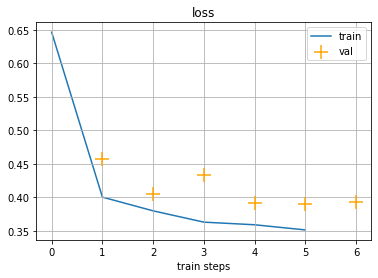

In [35]:
# Функция потерь
plot_history(summary['loss_train'], summary['loss_test'])

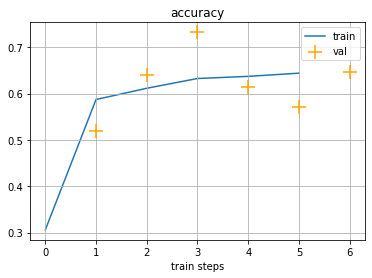

In [36]:
# Точность
plot_history(summary['accuracy_train'], summary['accuracy_test'], "accuracy")

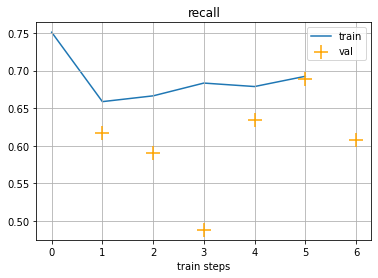

In [37]:
# Полнота
plot_history(summary['recall_train'], summary['recall_test'], "recall")

In [39]:
import gc

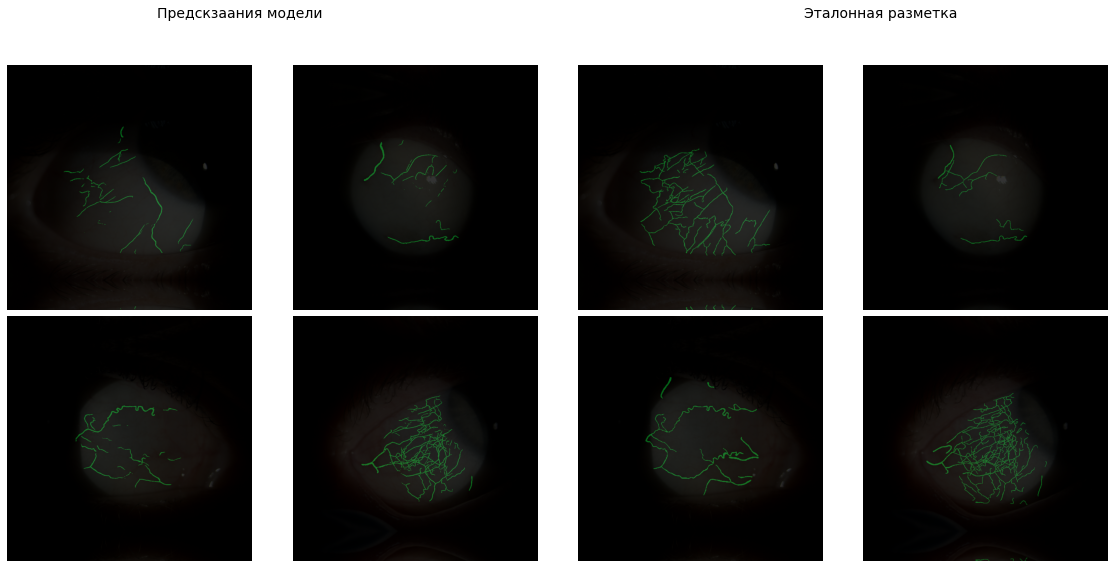

In [40]:
# Посмотрим на картинки предсказаний

fig, axs = plt.subplots(2, 4, figsize=(16,8))
fig.suptitle(f'Предскзаания модели {" "*105} Эталонная разметка', fontsize=14)

for i, sample in zip(range(4), valid_dataset):
    image = sample['image'].to("cuda")
    true_mask = sample['mask'].to("cuda")

    prediction = model_pretrain.eval()(image.unsqueeze(dim=0))
    image = (image.cpu() * 255).type(torch.uint8)
    pred_ask = (torch.exp(prediction[0]) > 0.4).cpu()

    image_with_mask = draw_segmentation_masks(image, pred_ask)
    image_with_mask = np.moveaxis(image_with_mask.cpu().numpy(), 0, -1)

    axs[i // 2, (i % 2)].imshow(image_with_mask)
    axs[i // 2, (i % 2)].axis('off')


    image_with_mask = draw_segmentation_masks(image, true_mask.type(torch.bool))
    image_with_mask = np.moveaxis(image_with_mask.cpu().numpy(), 0, -1)
    axs[i // 2, (i % 2)+2].imshow(image_with_mask)
    axs[i // 2, (i % 2)+2].axis('off')
    del image,true_mask,prediction,pred_ask,image_with_mask
    gc.collect()

fig.tight_layout()
fig.subplots_adjust(top=0.88)